# Introduction

This code generates the figures for the paper "Exploring controls on the timing of the phytoplankton bloom in western Baffin Bay, Canadian Arctic".

# Directory structure

binder, where is the .yml file for the conda virtual environment.

data, where are the outputs of the model NEMO-LIM3, the outputs of the model MITgcm and the observations from the Qikiqtarjuaq ice camps 2015 and 2016.

figures_timing_progress, where are the figures.

# Environment

This notebook was run in a conda virtual environment. The following commands will automatically create the environment and launch the Jupyter notebook:

```
cd <my_path>/gud_groups
conda env create -f binder/environment_timing.yml
conda activate timing
cd utils/python/MITgcmutils
python setup.py bdist_egg
cd build
pip install MITgcmutils
cd ../../../..
jupyter notebook
```

Once the environment timing is created, the Jupyter notebook can be launched simply with:

```
cd <my_path>/gud_groups
conda activate timing
jupyter notebook
```

# First, load libraries

Uncomment and run one time the cell below if you have the error:

```ModuleNotFoundError: No module named 'MITgcmutils'```

In [1]:
# import os
# import subprocess
## make sure the current working directory is gud_groups
# wd=%pwd
# os.chdir('utils/python/MITgcmutils')
# subprocess.call(['python', 'setup.py', 'bdist_egg'])
# os.chdir('build')
# subprocess.call(['pip', 'install', 'MITgcmutils'])
# os.chdir(wd)

In [2]:
%matplotlib inline

import cartopy
import cartopy.crs as ccrs
import collections
import datetime
import gudinfo
import math
import matplotlib as mpl
import matplotlib.colors
import matplotlib.patches
import matplotlib.projections
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import mpl_toolkits.axisartist.floating_axes as FA
import mpl_toolkits.axisartist.grid_finder as GF
import netcdf_tools
import numpy as np
import os
import os.path
import pandas as pd
import read_mitgcm
import scipy.io
import scipy.interpolate
import statsmodels.nonparametric.smoothers_lowess
import tarfile
import TaylorDiagram
import vstats_pos

# Parameters for the figures

In [3]:
# dpi='figure' # default dpi
dpi=600
# ext='png'
ext='jpeg'

# Maps

## Maps: Reference

Reference: https://github.com/poplarShift/ice-edge/blob/master/iceedge_analysis.ipynb.

## Maps: Function

In [4]:
'''latlon2xy convenience function to convert latlon to chosen projection,
and figure object'''
def latlon2xy(lon,lat,proj):
    xyz = proj.transform_points(ccrs.PlateCarree(),lon,lat).squeeze()
    x,y,_ = np.split(xyz,3,axis=len(xyz.shape)-1)
    x[np.isinf(x)]=np.nan
    y[np.isinf(y)]=np.nan
    return x.squeeze(),y.squeeze()

## Maps: stations

In [5]:
# STATIONS
Station=collections.namedtuple(
    'Station',
    'lon lat marker  markeredgecolor markerfacecolor markersize')
station1=Station(-60.3919999999999,68.3096,'o','none','red',5)
station2=Station(-61.463,68.0358,'o','none','red',5)
station3=Station(-62.355,67.8668,'o','none','red',5)
station4=Station(-63.5639999999999,67.54,'o','none','red',5)
# Qikiqtarjuaq SIC
station5=Station(-63.783,67.482,'*','black','yellow',30)
station6=Station(-64.638,67.239,'o','none','red',5)
# stations=[station1,station2,station3,station4,station5,station6]
stations=[station5]

# Plot

/var/folders/vq/5y09539n705gpb79d6ysx09r0000gr/T/ipykernel_84177/3488533566.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Greys')
/Users/maximebenoit-gagne/anaconda3/envs/timing/lib/python3.8/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/maximebenoit-gagne/anaconda3/envs/timing/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/maximebenoit-gagne/anaconda3/envs/timing/lib/python3.8/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/maximebenoit-gagne/anaconda3/envs/timing/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeW

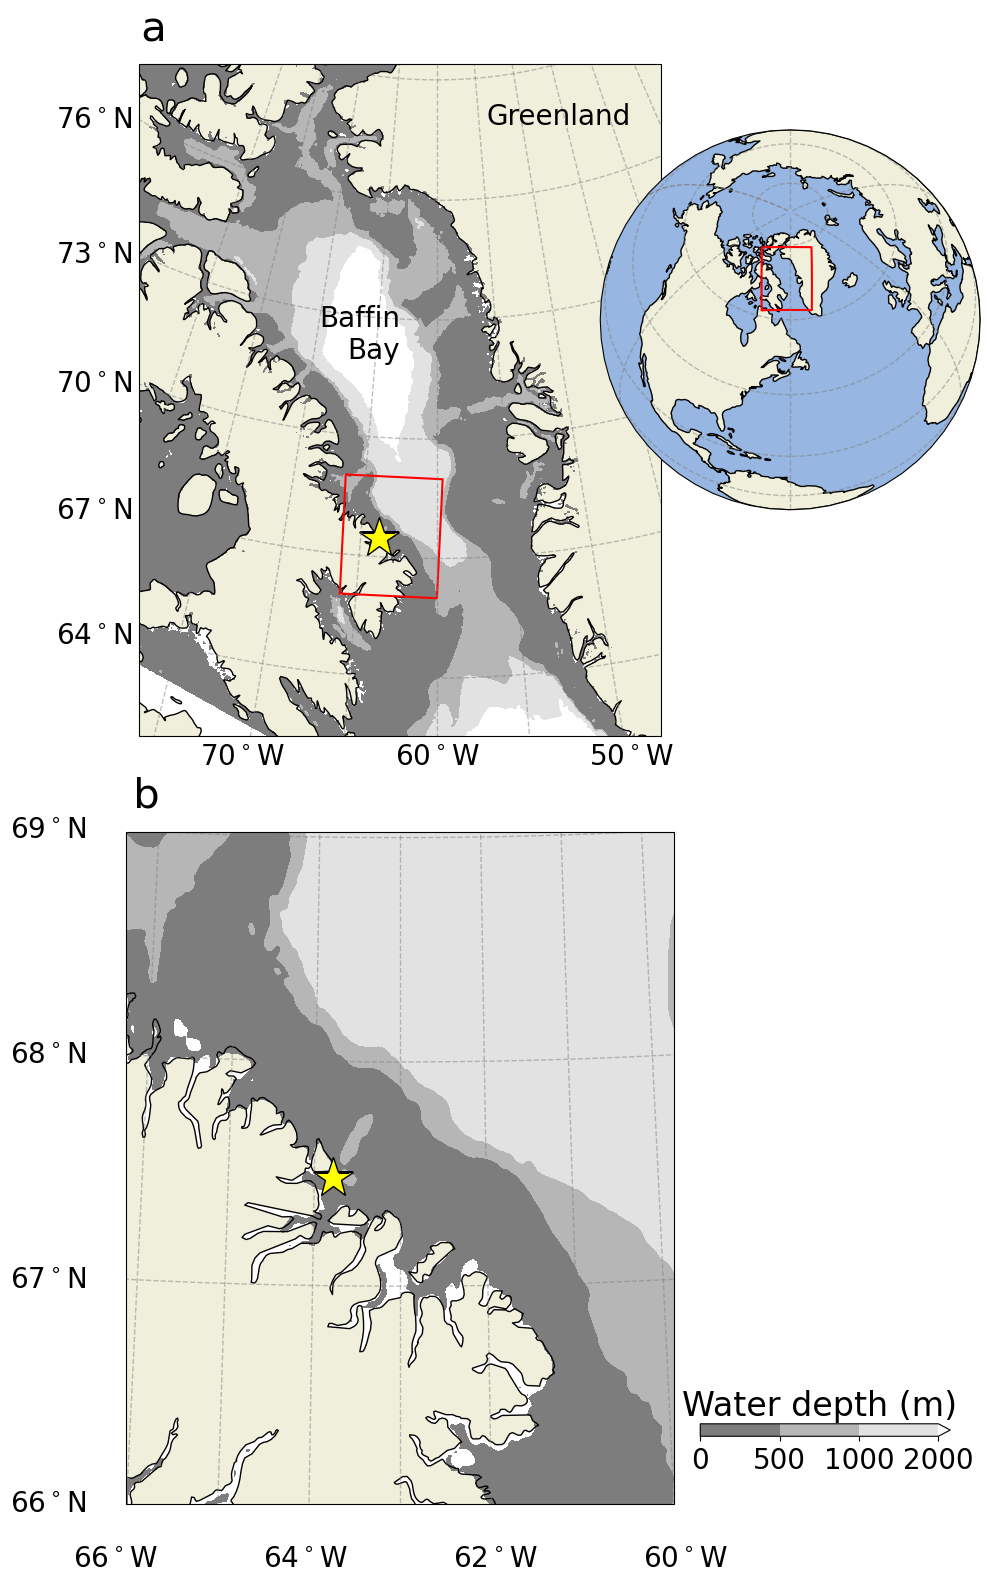

In [6]:
plotbathymetry=True
# plotbathymetry=False
with plt.style.context('mplstyles/maps.mplstyle'):
    fig=plt.figure(figsize=(10, 16))
    
    # --- CCGS AMUNDSEN 2018, LEG 2B
    proj_am=ccrs.LambertConformal(central_longitude=-63,
                                  central_latitude=67.5,
                                  standard_parallels=(67,68))
    ax_am=fig.add_subplot(223,projection = proj_am)
    ax_am.coastlines(resolution='10m')
    ax_am.add_feature(cartopy.feature.LAND)
    if not plotbathymetry:
        ax_am.add_feature(cartopy.feature.OCEAN)
    MapExtent = [-66,-60,66,69]
    ax_am.set_extent(MapExtent, ccrs.PlateCarree())
    gl = ax_am.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                         linewidth=1, color='gray', alpha=0.5,
                         linestyle='--')
    gl.xlocator = mticker.FixedLocator(np.arange(-68,-58))
    gl.ylocator = mticker.FixedLocator(np.arange(65,70))

    # stations
    for station in stations:
        xstation,ystation = latlon2xy(np.array([station.lon]),
                                      np.array([station.lat]),
                                      proj_am)
        marker=station.marker
        markerfacecolor=station.markerfacecolor
        markersize=station.markersize
        markeredgecolor=station.markeredgecolor
        ax_am.plot(xstation,ystation,marker,markeredgecolor=markeredgecolor,
                   markerfacecolor=markerfacecolor,markersize=markersize)
        
    # longitude labels
    y0,_ = ax_am.get_ylim()
    for lon in [-66,-64,-62,-60]:
        x0,_ = proj_am.transform_point(lon,MapExtent[2]-1,
                                       src_crs = ccrs.PlateCarree())
        plt.text(x0,y0-2e4,'{:2d}$^\circ$W'.format(-lon),
                 horizontalalignment = 'center',verticalalignment='top')

    # latitude labels
    x0,_ = ax_am.get_xlim()
    someLons = np.arange(-80,-50)
    for lat in np.arange(66,69+1):
        # interpolate latitude circle to map boundary
        xyzArray = proj_am.transform_points(ccrs.PlateCarree(),
                                            someLons,lat*np.ones_like(someLons))
        x = xyzArray[:,0]
        y = xyzArray[:,1]
        y0 = np.interp(x0,x,y)
        plt.text(x0-2e4,y0,'{:2d}$^\circ$N'.format(lat),
                 horizontalalignment = 'right',verticalalignment='center')
    
    if plotbathymetry:
        # color bar for bathymetry
        cmap = plt.cm.get_cmap('Greys')
        cmap = cmap.from_list('Custom cmap',
                              [cmap(i) for i in range(150,50,-1)], 100)
        cmap.set_over('white')
        bounds = [0,500,1000,2000]
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    # IBCAO bathymetry
    if plotbathymetry:
        top = scipy.io.loadmat('data/DataS1_observations_IBCAO_1min_bathy.mat')
        lon_ibcao,lat_ibcao=np.meshgrid(top['x'],top['y'])
        z_ibcao=-top['IBCAO_1min']
        hb_am=ax_am.contourf(*latlon2xy(lon_ibcao,lat_ibcao,proj_am),
                             z_ibcao,levels=[0,500,1000,2000],
                             cmap=cmap,norm=norm,extend='max')
        axcb_am= fig.colorbar(hb_am,ax=ax_am,orientation='horizontal')
        axcb_am.ax.set_title('Water depth (m)')
        axcb_am.ax.set_position([0.70,-0.10, 0.25,0.20])
    
#     # labels for stations
#     for i,station in enumerate(stations):
#         xstation,ystation = latlon2xy(np.array([station.lon]),
#                                       np.array([station.lat]),
#                                       proj_am)
#         ax_am.text(xstation+3e3,ystation+1e4,i+1,
#                    horizontalalignment = 'center',
#                    verticalalignment='center')
    # text
    b_lon,b_lat = -66.5, 69.1,
    ax_am.text(b_lon,b_lat,' b ',
               horizontalalignment = 'left',fontsize=30,
               transform=ccrs.PlateCarree())
    
    # --- BAFFIN BAY
    proj_bb=ccrs.LambertConformal(central_longitude=-60,
                                  central_latitude=70,
                                  standard_parallels=(65,75))
    ax_bb=fig.add_subplot(221,projection=proj_bb)
    ax_bb.coastlines(resolution='50m')
    ax_bb.add_feature(cartopy.feature.LAND)
    if not plotbathymetry:
        ax_bb.add_feature(cartopy.feature.OCEAN)
    MapExtent = [-76,-48,62,79]
    ax_bb.set_extent(MapExtent, ccrs.PlateCarree())
    gl = ax_bb.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                         linewidth=1, color='gray', alpha=0.5,
                         linestyle='--')
    gl.xlocator = mticker.FixedLocator([-80,-75,-70,-65,-60,
                                        -55,-50,-45,-40,-35])
    gl.ylocator = mticker.FixedLocator(np.arange(58,84,3))

    # stations
    for station in stations:
        xstation,ystation = latlon2xy(np.array([station.lon]),
                                      np.array([station.lat]),
                                      proj_bb)
        marker=station.marker
        markerfacecolor=station.markerfacecolor
        markersize=station.markersize
        markeredgecolor=station.markeredgecolor
        ax_bb.plot(xstation,ystation,marker,markeredgecolor=markeredgecolor,
                   markerfacecolor=markerfacecolor,markersize=markersize)

    # longitude labels
    y0,_ = ax_bb.get_ylim()
    for lon in [-70,-60,-50]:
        x0,_ = proj_bb.transform_point(lon,MapExtent[2]-1,
                                       src_crs = ccrs.PlateCarree())
        plt.text(x0,y0-2e4,'{:2d}$^\circ$W'.format(-lon),
                 horizontalalignment = 'center',verticalalignment='top',
                fontsize=20)

    # latitude labels
    x0,_ = ax_bb.get_xlim()
    someLons = np.arange(-120,-40,1)
    for lat in np.arange(64,78,3):
        # interpolate latitude circle to map boundary
        xyzArray = proj_bb.transform_points(ccrs.PlateCarree(),
                                            someLons,lat*np.ones_like(someLons))
        x = xyzArray[:,0]
        y = xyzArray[:,1]
        y0 = np.interp(x0,x,y)
        plt.text(x0-2e4,y0,'{:2d}$^\circ$N'.format(lat),
                 horizontalalignment = 'right',verticalalignment='center')
    
    # IBCAO bathymetry
    if plotbathymetry:
        hb_bb=ax_bb.contourf(*latlon2xy(lon_ibcao,lat_ibcao,proj_bb),
                             z_ibcao,levels=[0,500,1000,2000],
                             cmap=cmap,norm=norm,extend='max')

    # text
    a_lon,a_lat = -98, 77.5
    ax_bb.text(a_lon,a_lat,' a ',
               horizontalalignment = 'left',fontsize=30,
               transform=ccrs.PlateCarree())
    greenland_lon,greenland_lat = -38, 77
    ax_bb.text(greenland_lon,greenland_lat,'Greenland',
               horizontalalignment = 'right',
               transform=ccrs.PlateCarree())
    baffinbay_lon,baffinbay_lat = -63, 72
    ax_bb.text(baffinbay_lon,baffinbay_lat,'Baffin\nBay',
               horizontalalignment = 'right',
               transform=ccrs.PlateCarree())

    # rectangle
    extentStudyarea = ax_am.get_extent()
    vertices = np.array([
        [extentStudyarea[0], extentStudyarea[2]], # left, bottom
        [extentStudyarea[0], extentStudyarea[3]], # left, top
        [extentStudyarea[1], extentStudyarea[3]], # right, top
        [extentStudyarea[1], extentStudyarea[2]], # right, bottom
        [extentStudyarea[0], extentStudyarea[2]]
    ])
    xVert,yVert = vertices.transpose()
    xBox = np.interp(np.arange(0,4,.02),np.arange(0,4.1,1),xVert)
    yBox = np.interp(np.arange(0,4,.02),np.arange(0,4.1,1),yVert)
    xyzBoxLatlon = ccrs.PlateCarree().transform_points(ax_am.projection,
                                                       xBox,yBox)
    xBoxLatlon = xyzBoxLatlon[:,0]
    yBoxLatlon = xyzBoxLatlon[:,1]
    xyzBoxTransformed = proj_bb.transform_points(ccrs.PlateCarree(),
                                                 xBoxLatlon,yBoxLatlon)
    xBoxTransformed = xyzBoxTransformed[:,0]
    yBoxTransformed = xyzBoxTransformed[:,1]
    ax_bb.plot(xBoxTransformed,yBoxTransformed,'r')
    ax_bb.relim()
    
    # --- WORLD MAP
    proj_wm = ccrs.NearsidePerspective(central_longitude=-60,
                                       central_latitude=60)
    ax_wm = fig.add_subplot(222,projection = proj_wm)
    ax_wm.set_global()
    ax_wm.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
    ax_wm.add_feature(cartopy.feature.OCEAN)
    gl = ax_wm.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                         linewidth=1, color='gray', alpha=0.5,
                         linestyle='--')
    extentStudyarea = ax_bb.get_extent()
    vertices = np.array([
        [extentStudyarea[0], extentStudyarea[2]], # left, bottom
        [extentStudyarea[0], extentStudyarea[3]], # left, top
        [extentStudyarea[1], extentStudyarea[3]], # right, top
        [extentStudyarea[1], extentStudyarea[2]], # right, bottom
        [extentStudyarea[0], extentStudyarea[2]]
    ])
    xVert,yVert = vertices.transpose()
    xBox = np.interp(np.arange(0,4,.02),np.arange(0,4.1,1),xVert)
    yBox = np.interp(np.arange(0,4,.02),np.arange(0,4.1,1),yVert)
    xyzBoxLatlon = ccrs.PlateCarree().transform_points(ax_bb.projection,
                                                       xBox,yBox)
    xBoxLatlon = xyzBoxLatlon[:,0]
    yBoxLatlon = xyzBoxLatlon[:,1]
    xyzBoxTransformed = proj_wm.transform_points(ccrs.PlateCarree(),
                                                 xBoxLatlon,yBoxLatlon)
    xBoxTransformed = xyzBoxTransformed[:,0]
    yBoxTransformed = xyzBoxTransformed[:,1]
    ax_wm.plot(xBoxTransformed,yBoxTransformed,'r')
    
    ax_wm.set_position( [0.60,0.60 ,0.38,0.38])
    ax_bb.set_position( [0.10,0.53 ,0.60,0.42])
    ax_am.set_position( [0.10,0.05 ,0.60,0.42])

    # --- SAVE
    if plotbathymetry:
        plt.savefig('figures_timing_progress/maps.'+ext,dpi=dpi)
    else:
        plt.savefig('figures_timing_progress/maps_nobathy.'+ext,dpi=dpi)

Fig. \<maps\>.
Maps of Baffin Bay and the study site. The yellow star marker represents the Qikiqtarjuaq sea ice camp location (Oziel et al., 2019).
(a) Map of Baffin Bay.
(b) Map of the area around the Qikiqtarjuaq sea ice camp.

# Model

## Model: traits

Set indir.

In [7]:
indir_exp0='data/DataS6_output_mitgcm/exp0'

Create RunInfo object.

In [8]:
info=gudinfo.RunInfo(indir_exp0)

Equivalent spherical diameters ($ESD$, $\mathrm{ \mu m }$).

In [9]:
esd=info.f['esd'].to_numpy()

Maximum growth rate ($P^C_{max}$, $\mathrm{ d^{-1} }$).

In [10]:
stod=86400 # seconds to day
pcmax=info.f['pcmax'].to_numpy() # s^-1
pcmax=pcmax*stod                 # d^-1

Half saturation for growth on nitrate ($k_{NO_3}$,
$\mathrm{ mmol\ N\ m^{-3} }$).

In [11]:
ksatno3=info.f['ksatno3'].to_numpy()

Maximum grazing rate ($g_{max}$, $\mathrm{ d^{-1} }$).

In [12]:
stod=86400 # seconds to day
gmax=info.f['grazemax'].to_numpy() # s^-1
gmax=gmax*stod                     # d^-1

# Plot

## Plot: traits

In [13]:
type_id=np.arange(1,52)

pos_Prochlorococcus=np.arange( 0, 1)
pos_Synechococcus  =np.arange( 1, 2)
pos_smalleuk       =np.arange( 2, 4)
pos_cocco          =np.arange( 4, 9)
pos_diazo          =np.arange( 9,13)
pos_Trichodesmium  =np.arange(13,14)
pos_diatoms        =np.arange(14,23)
pos_mixodino       =np.arange(23,33)
pos_zoo            =np.arange(33,49)

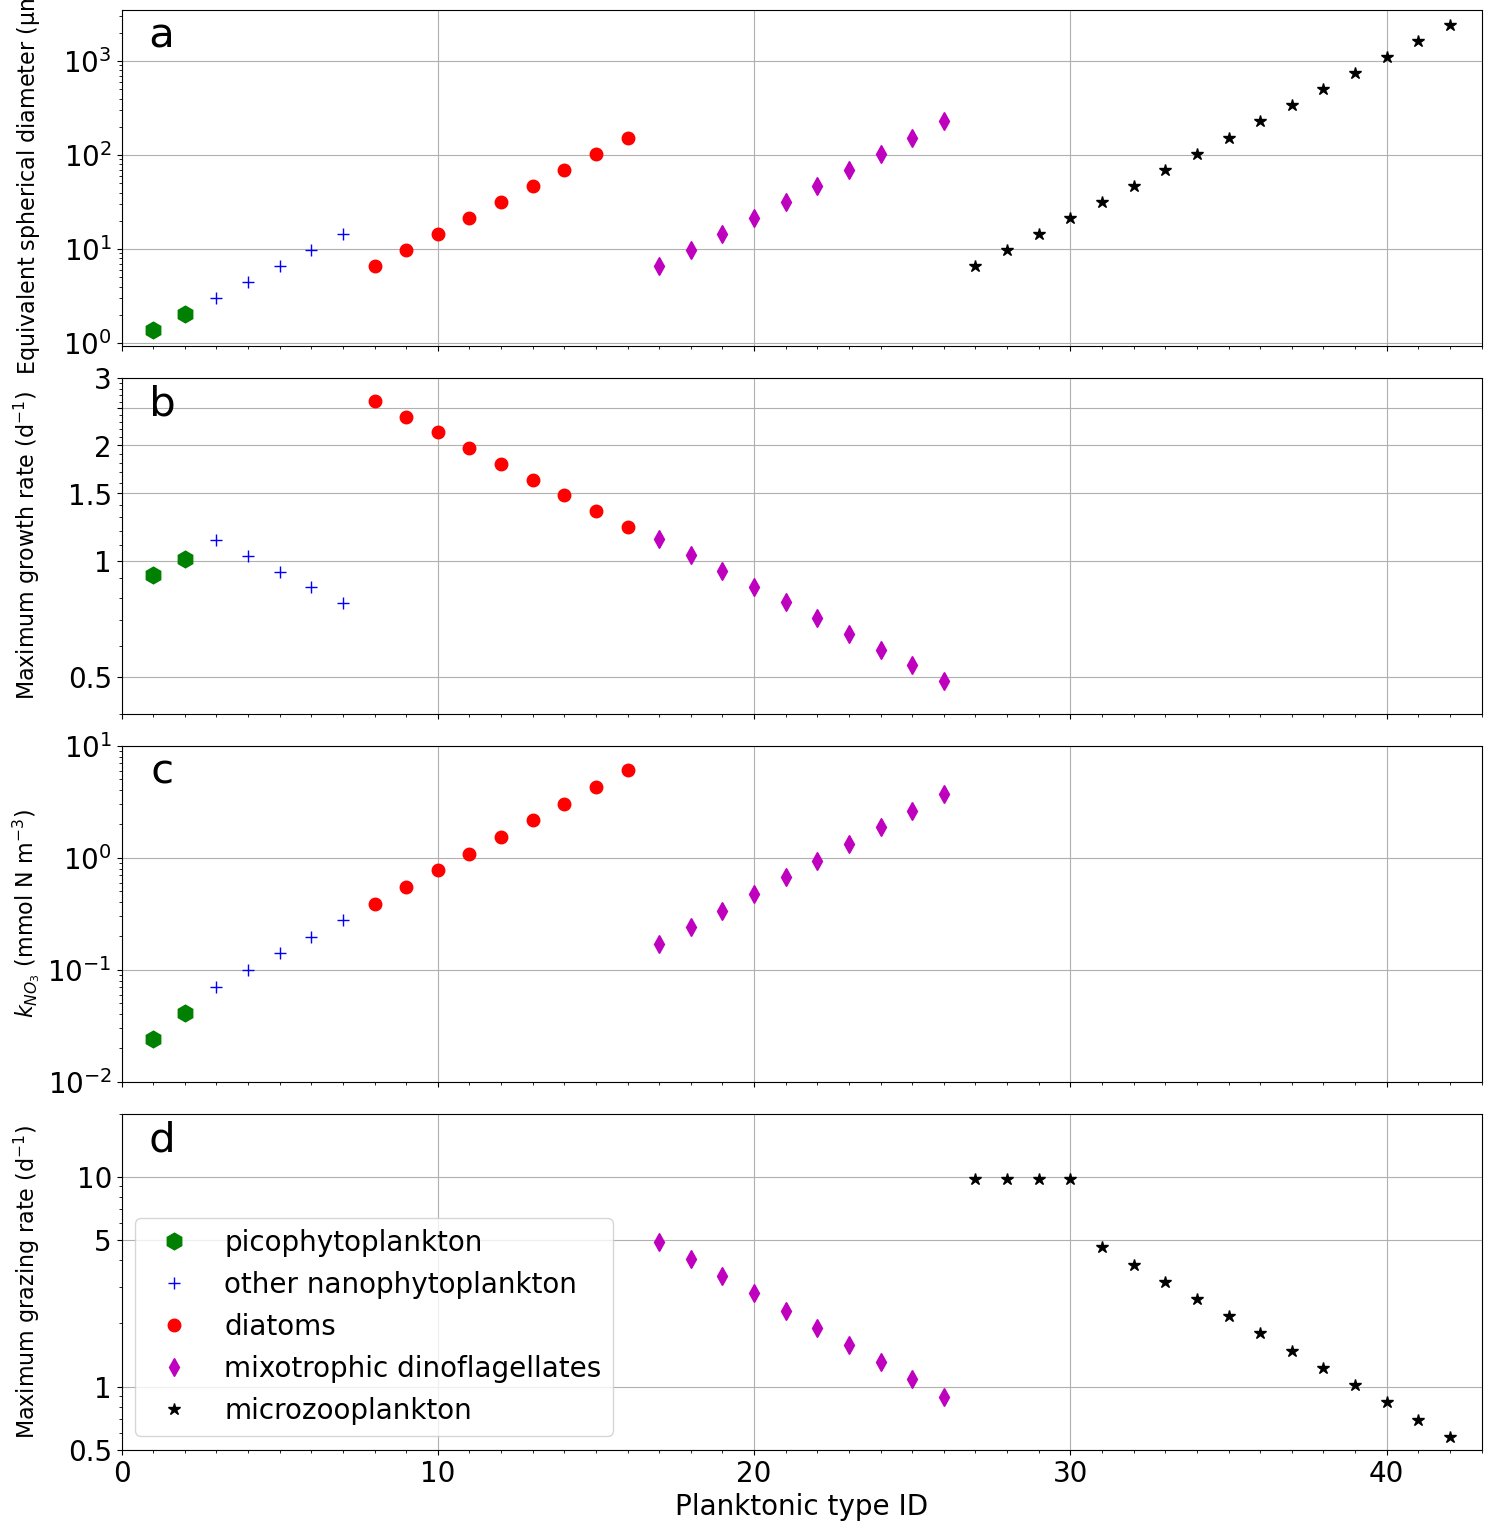

In [14]:
def make_plots(axs):
    box=dict(pad=5,alpha=0)
    
    # --- EQUIVALENT SPHERICAL DIAMETER (ESD)
    ax=axs[0]
    h3=ax.plot(type_id[pos_smalleuk]-2,  esd[pos_smalleuk],'gh',markersize=12)
    h4=ax.plot(type_id[pos_cocco]-2,     esd[pos_cocco],   'b+')
    h7=ax.plot(type_id[pos_diatoms]-2-5, esd[pos_diatoms], 'ro')
    h8=ax.plot(type_id[pos_mixodino]-2-5,esd[pos_mixodino],'md')
    h9=ax.plot(type_id[pos_zoo]-2-5,     esd[pos_zoo],     'k*')
    ax.set_xticklabels([])
    ax.xaxis.set_major_locator(mticker.MultipleLocator(10))
    ax.xaxis.set_minor_locator(mticker.MultipleLocator(1))
    ax.set_xlim([0,43])
    ax.set_ylabel('Equivalent spherical diameter ($\mathrm{ \mu m }$)')
    ax.set_yscale('log')
    ax.grid()
    plt.text(0.03,0.92,' a ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)

    # --- MAXIMUM GROWTH RATE (P^C_MAX)
    ax=axs[1]
    h3=ax.plot(type_id[pos_smalleuk]-2,  pcmax[pos_smalleuk],'gh',markersize=12)
    h4=ax.plot(type_id[pos_cocco]-2,     pcmax[pos_cocco],   'b+')
    h7=ax.plot(type_id[pos_diatoms]-2-5, pcmax[pos_diatoms], 'ro')
    h8=ax.plot(type_id[pos_mixodino]-2-5,pcmax[pos_mixodino],'md')
    h9=ax.plot(type_id[pos_zoo]-2-5,     pcmax[pos_zoo],     'k*')
    ax.set_xticklabels([])
    ax.xaxis.set_major_locator(mticker.MultipleLocator(10))
    ax.xaxis.set_minor_locator(mticker.MultipleLocator(1))
    ax.set_xlim([0,43])
    ax.set_ylabel('Maximum growth rate ($\mathrm{ d^{-1} }$)')
    ax.set_yscale('log')
    ax.yaxis.set_major_locator(plt.FixedLocator([0.5,1,1.5,2,2.5,3]))
    ax.yaxis.set_minor_locator(plt.FixedLocator([0.4,0.6,0.7,0.8,0.9,
                                                 1.1,1.2,1.3,1.4,1.6,1.7,1.8,1.9,
                                                 2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9]))
    ax.yaxis.set_major_formatter(plt.FixedFormatter([0.5,1,1.5,2,'',3]))
    ax.yaxis.set_minor_formatter(plt.FixedFormatter(['']))
    ax.set_ylim([0.4,3])
    ax.grid()
    plt.text(0.03,0.92,' b ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)

    # --- HALF SATURATION FOR GROWTH ON NITRATE (k_NO_3)
    ax=axs[2]
    h3=ax.plot(type_id[pos_smalleuk]-2,  ksatno3[pos_smalleuk],'gh',markersize=12)
    h4=ax.plot(type_id[pos_cocco]-2,     ksatno3[pos_cocco],   'b+')
    h7=ax.plot(type_id[pos_diatoms]-2-5, ksatno3[pos_diatoms], 'ro')
    h8=ax.plot(type_id[pos_mixodino]-2-5,ksatno3[pos_mixodino],'md')
    h9=ax.plot(type_id[pos_zoo]-2-5,     ksatno3[pos_zoo],     'k*')
    ax.set_xticklabels([])
    ax.xaxis.set_major_locator(mticker.MultipleLocator(10))
    ax.xaxis.set_minor_locator(mticker.MultipleLocator(1))
    ax.set_xlim([0,43])
    ax.set_ylabel('$k_{NO_3}$ ($\mathrm{ mmol\ N\ m^{-3} }$)')
    ax.set_yscale('log')
    ax.set_ylim([0.01,10])
    ax.grid()
    plt.text(0.03,0.92,' c ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)

    # --- MAXIMUM GRAZING RATE (G_MAX)
    ax=axs[3]
    h3=ax.plot(type_id[pos_smalleuk]-2,  gmax[pos_smalleuk],'gh',markersize=12,
               label='picophytoplankton')
    h4=ax.plot(type_id[pos_cocco]-2,     gmax[pos_cocco],   'b+',
               label='other nanophytoplankton')
    h7=ax.plot(type_id[pos_diatoms]-2-5, gmax[pos_diatoms], 'ro',
               label='diatoms')
    h8=ax.plot(type_id[pos_mixodino]-2-5,gmax[pos_mixodino],'md',
               label='mixotrophic dinoflagellates')
    h9=ax.plot(type_id[pos_zoo]-2-5,     gmax[pos_zoo],     'k*',
               label='microzooplankton')
    ax.set_xlabel('Planktonic type ID',fontsize=20)
    ax.xaxis.set_major_locator(mticker.MultipleLocator(10))
    ax.xaxis.set_minor_locator(mticker.MultipleLocator(1))
    ax.set_xlim([0,43])
    ax.set_ylabel('Maximum grazing rate ($\mathrm{ d^{-1} }$)')
    ax.set_yscale('log')
    ax.yaxis.set_major_locator(plt.FixedLocator([0.5,1,5,10]))
    ax.yaxis.set_minor_locator(plt.FixedLocator([0.6,0.7,0.8,0.9,2,3,4,6,7,8,9,20]))
    ax.yaxis.set_major_formatter(plt.FixedFormatter([0.5,1,5,10]))
    ax.set_ylim([0.5,20])
    ax.grid()
    ax.legend(loc=3)
    plt.text(0.03,0.92,' d ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)

    # --- POSITION
    axs[0].set_position( [0.10,0.76  ,0.85,0.21])
    axs[1].set_position( [0.10,0.53  ,0.85,0.21])
    axs[2].set_position( [0.10,0.30  ,0.85,0.21])
    axs[3].set_position( [0.10,0.07  ,0.85,0.21])

with plt.style.context('mplstyles/traits.mplstyle'):    
    # Plot
    fig,axs=plt.subplots(4,1,figsize=(16, 16))
    make_plots(axs)
    fig.align_ylabels(axs[:])

    # --- SAVE
    outfile='figures_timing_progress/traits.'+ext
    plt.savefig(outfile,dpi=dpi)

Figure \<traits\>.
Parameters for each numerical type (each numerical species).
(a) Size (Equivalent spherical diameter, $ESD$, $\mathrm{ \mu m }$).
(b) Maximum growth rate ($PC_{max}$, $\mathrm{ d^{-1} }$).
(c) Half saturation for growth on nitrate
($k_{NO_3}$, $\mathrm{ mmol\ N\ m^{-3} }$).
(d) Maximum grazing rate ($g_{max}$, $\mathrm{ d^{-1} }$).


# Grid

drF is the r cell face separation, meaning the thickness of each depth layer (in m).

It corresponds to delR on https://mitgcm.readthedocs.io/en/latest/getting_started/getting_started.html#grid

In [15]:
gridfile='data/DataS6_output_mitgcm/exp0/grid.t001.nc';
drF=netcdf_tools.read_netcdf(gridfile,'drF')

RC is the r coordiante of cell center (in m).
We switch sign to have positive depths.

In [16]:
RC=-netcdf_tools.read_netcdf(gridfile,'RC')

RF is the r coordinate of cell interface (in m). We switch sign to have positive depths.

In [17]:
RF=-netcdf_tools.read_netcdf(gridfile,'RF')

# Forcing fields for nutrients

## Forcing fields for nutrients: Observations

In [18]:
inNO3=np.fromfile('data/DataS2_forcing_fields_nutrients/no3.bin',
                  dtype='>f')
inPO4=np.fromfile('data/DataS2_forcing_fields_nutrients/po4.bin',
                  dtype='>f')
inSiOH4=np.fromfile('data/DataS2_forcing_fields_nutrients/sioh4.bin',
                    dtype='>f')

## Forcing fields for nutrients: EXP-1.3: differing nitrate before bloom initation

In [19]:
no3t0_25=np.fromfile('data/DataS2_forcing_fields_nutrients/no3_times0_25.bin',
                     dtype='>f')
no3t0_50=np.fromfile('data/DataS2_forcing_fields_nutrients/no3_times0_50.bin',
                     dtype='>f')
no3t1_00=np.fromfile('data/DataS2_forcing_fields_nutrients/no3_reference.bin',
                     dtype='>f')
no3t2_00=np.fromfile('data/DataS2_forcing_fields_nutrients/no3_times2_00.bin',
                     dtype='>f')
no3t4_00=np.fromfile('data/DataS2_forcing_fields_nutrients/no3_times4_00.bin',
                     dtype='>f')

## Forcing fields for nutrients: Plot

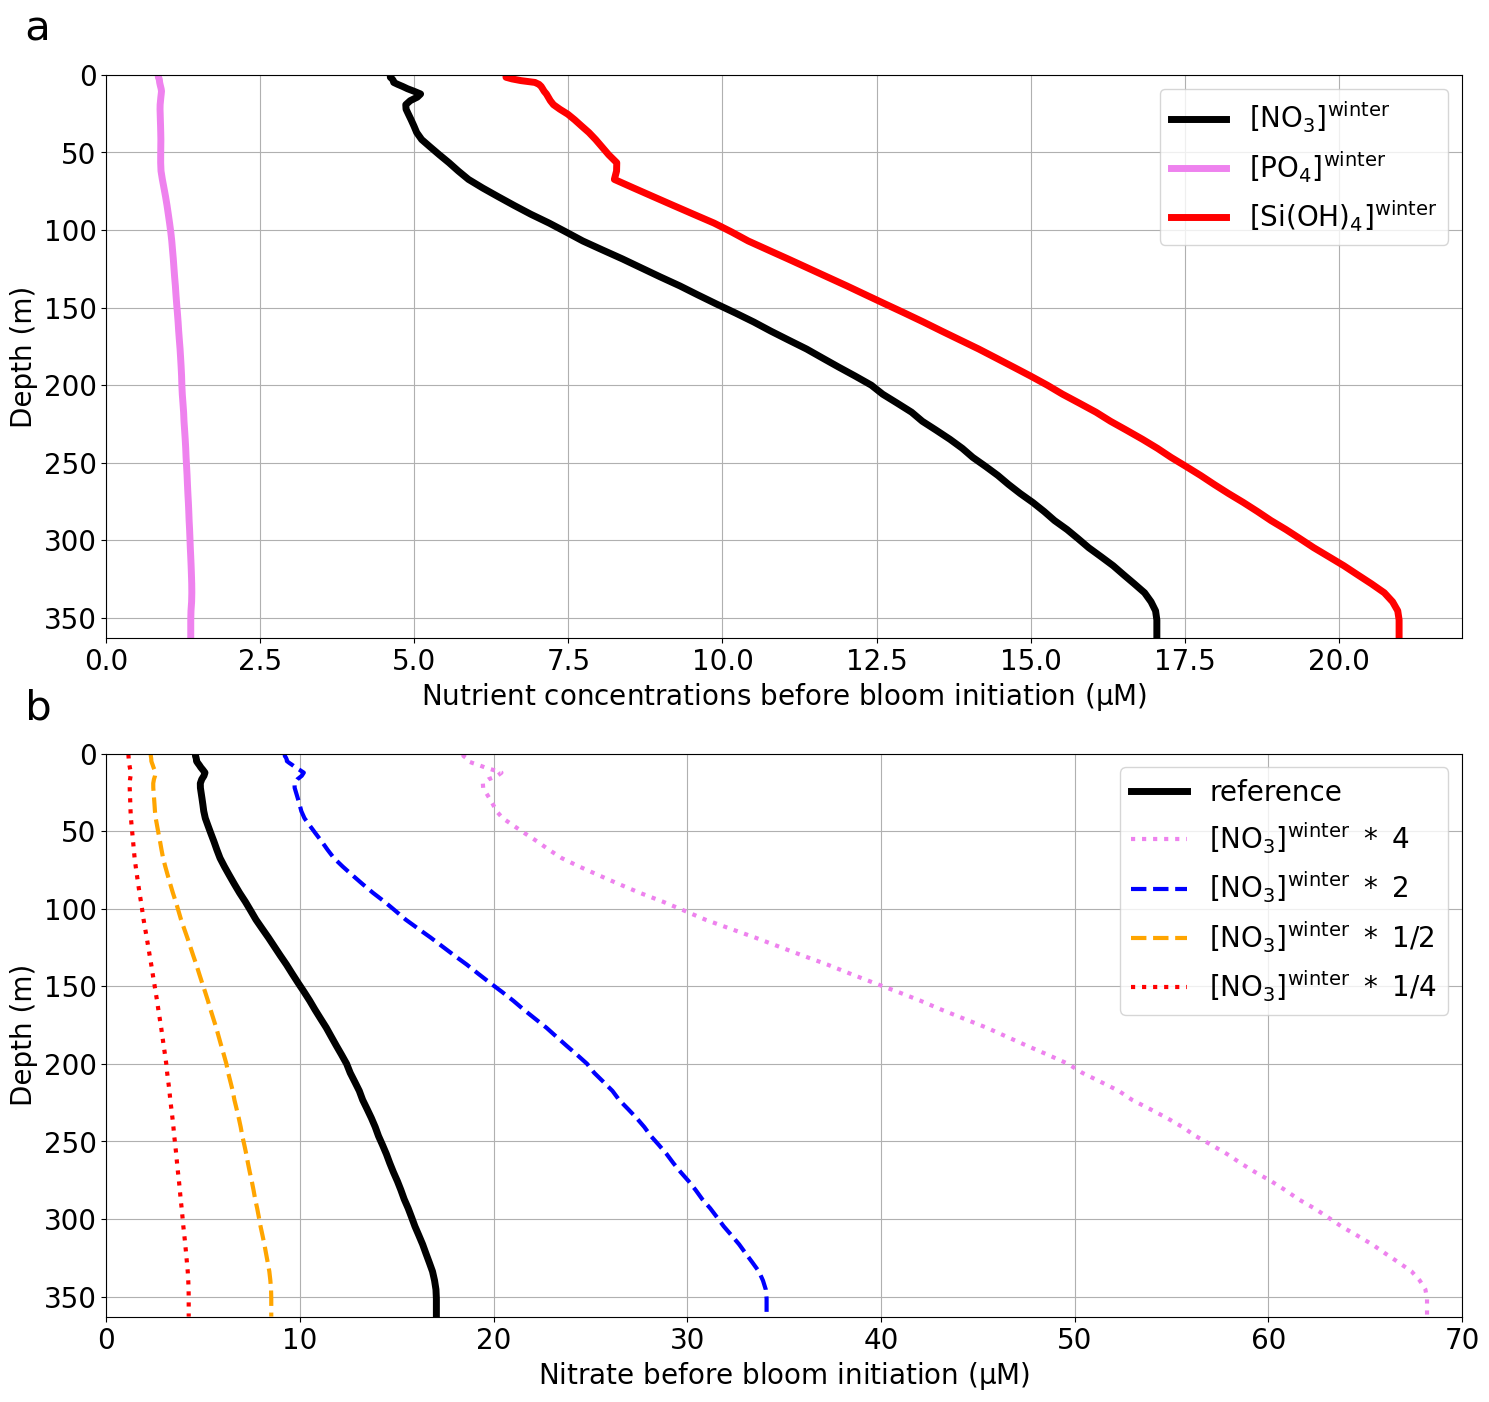

In [20]:
def make_plots(axs):
    box=dict(pad=5,alpha=0)
    
    # --- OBSERVATIONS
    ax=axs[0]
    h1=ax.plot(inNO3,RC,
              color='black',linewidth=5,
              label='$\mathrm{{ [NO_3]^{{winter}} }}$')
    ax.set_xlabel('Nutrient concentrations before bloom initiation '
                  '($\mathrm{ \mu M }$)')
    ax.set_ylabel('Depth (m)')
    ax.set_xlim(0,22)
    ax.set_ylim(0,363)
    ax.invert_yaxis()
    h2=ax.plot(inPO4,RC,
              color='violet',linewidth=5,
              label='$\mathrm{{ [PO_4]^{{winter}} }}$')
    h3=ax.plot(inSiOH4,RC,
              color='red',linewidth=5,
              label='$\mathrm{{ [Si{(OH)}_4]^{{winter}} }}$')
    ax.legend()
    ax.grid(True)
    plt.text(-0.05,1.08,' a ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    
    # --- EXP-1.3
    ax=axs[1]
    h1=ax.plot(no3t1_00,RC,
              '-',color='black',linewidth=5,
              label='reference')
    ax.set_xlabel('Nitrate before bloom initiation '
                  '($\mathrm{ \mu M }$)')
    ax.set_ylabel('Depth (m)')
    ax.set_xlim(0,70)
    ax.set_ylim(0,363)
    ax.invert_yaxis()
    h1=ax.plot(no3t4_00,RC,
              ':',color='violet',
              label='$\mathrm{ {[NO_3]}^{winter}\ *\ 4 }$')
    h1=ax.plot(no3t2_00,RC,
              '--',color='blue',
              label='$\mathrm{ {[NO_3]}^{winter}\ *\ 2 }$')
    h1=ax.plot(no3t0_50,RC,
              '--',color='orange',
              label='$\mathrm{ {[NO_3]}^{winter}\ *\ 1/2 }$')
    h1=ax.plot(no3t0_25,RC,
              ':',color='red',
              label='$\mathrm{ {[NO_3]}^{winter}\ *\ 1/4 }$')
    ax.legend()
    ax.grid(True)
    plt.text(-0.05,1.08,' b ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    

    # --- POSITION
    axs[0].set_position( [0.07,0.55  ,0.91,0.39])
    axs[1].set_position( [0.07,0.08  ,0.91,0.39])

with plt.style.context('mplstyles/relaxation_nutrients.mplstyle'):
    # Plot
    fig,axs=plt.subplots(2,1,figsize=(14.90,14.44))
    make_plots(axs)

    # --- SAVE
    outfile='figures_timing_progress/relaxation_nutrients.'+ext
    plt.savefig(outfile,dpi=dpi)

# Select year

In [21]:
years=range(1,11)
nbyears=len(years)
iyeartempo=nbyears
first_year=np.arange(0,365)
last_year=np.arange(365*(nbyears-1)+0,365*(nbyears-1)+365)
array1d_iT1y_iT=last_year
first_year366=np.arange(0,366) # first year for heatmaps

# Observations

## Observations: sea ice concentration

The values of observed sea ice concentrations were boolean values of 0
and 1 because sea ice melted suddenly in only one day.
Here, these values were retrieved from the file of the forcing fields
of sea ice concentration.
We made sure these values corresponded to the expected values.

In [22]:
infile_sic=\
'data/DataS3_observations_Qikiqtarjuaq/siarea.qik.2016.365.32bits.bin'
array1d_iT_sic=np.fromfile(infile_sic,dtype='>f')

Sea ice break-up was on 18 July 2016, doy (0-based)=199.

In [23]:
obs_breakup=next(i for i,v in list(enumerate(array1d_iT_sic)) if v==0)

assert obs_breakup==199,\
'the day of year (0-based) of break-up from the file %s (obs_breakup=%r)'\
' is different from the day of year of break-up'\
' from Oziel et al., 2019 in Elem. Sci. Anth. (July 18=199).'\
% (infile_sic,obs_breakup)

## Observations: snow and ice thickness

The file Ice thickness from https://www.seanoe.org/data/00487/59892/ contains $in\ situ$ snow and ice thickness at the Green Edge sea ice camps 2015 and 2016 ($67.48^\circ N$, $-63.79^\circ E$). Variable 'sample_thickness_cm_average' is the snow or ice thickness ($cm$).

### Observations: snow and ice thickness: load dataset

In [24]:
def load_thickness():
    fname='data/DataS3_observations_Qikiqtarjuaq/66407.csv'
    df = (
        pd.read_csv(
            fname,
            dtype={
                'mission': 'string',
                'date': str,
                'date_time': str,
                'latitude': np.float32,
                'longitude': np.float32,
                'sample_type': 'category',
                'sample_thickness_cm_average': np.float32,
                'sample_thickness_cm_sd': np.float32,
                'pi': 'category'
            },
            parse_dates=['date','date_time']
        )
    )
    df['doy']=df['date'].apply(lambda x:x.timetuple().tm_yday)
    df['sample_thickness_m_average']=df['sample_thickness_cm_average'] \
    .apply(lambda x:x/100)
    return df

In [25]:
thickness_df=load_thickness()

### Observations: snow and ice thickness: select

We select the observations of snow thickness at the ice camp 2016.

In [26]:
snow_thickness_df=thickness_df[(thickness_df.mission=='ice_camp_2016') \
                               & (thickness_df.sample_type=='snow')]
# snow_thickness_df[['date','sample_thickness_m_average']]

The start of the period without observed snow cover was defined as the
start of the melt pond period.
It was on 15 June 2016 (Oziel et al., 2019 in *Elem. Sci. Anth.*).

In [27]:
obs_nosnow=166 # 0-based

We select the observations of ice thickness at the ice camp 2016.

In [28]:
ice_thickness_df=thickness_df[(thickness_df.mission=='ice_camp_2016') \
                              & (thickness_df.sample_type=='ice')]

## Observations: PAR

In $\mathrm{ mol\ photons\ m^{-2}\ d^{-1} }$.

Conversion factor from
$\mathrm{ \mu mol\ photons\ m^{-2}\ s^{-1} }$
to
$\mathrm{ mol\ photons\ m^{-2}\ d^{-1} }$.

In [29]:
uEs2Ed=1E-6*86400

The file C-OPS from https://www.seanoe.org/data/00487/59892/ contains $in\ situ$ underwater PAR at the Qikiqtarjuaq sea ice camps 2015 and 2016 ($67.48^\circ N$, $-63.79^\circ E$). Variable 'averaged_par_d_fit_daily_ein_m_2_day_1' is the downwelling PAR (mol photons $\mathrm{ m^{-2} }$ $\mathrm{ d^{-1} }$).

Let $\mathrm{ I_i }$ the PAR just below sea ice.

PAR just below surface ($\mathrm{ 0^- }$) was observed only just
below sea ice ($\mathrm{ I_i }$).
PAR just below surface ($\mathrm{ 0^- }$) was not observed just
below open water ($\mathrm{ I_w }$).
Observed PAR ($\mathrm{ 0^- }$) was thus equivalent to 
observed PAR just below sea ice ($\mathrm{ I_i })$.

### Observations: PAR: load dataset

In [30]:
def load_par(fname):
    df = (
        pd.read_csv(
            fname,
            dtype={
                'mission': 'string',
                'station': 'category',
                'date': str,
                'snow_thickness': 'category',
                'depth_m': np.float32,
                'pi': 'category',
                'averaged_par_d_fit_muein_m_2_s_1': np.float32,
                'averaged_par_d_fit_percent_percent': np.float32,
                'averaged_par_d_fit_daily_ein_m_2_day_1': np.float32,
                'averaged_par_d_noon1hloc_ein_m_2_1h_1': np.float32,
                'averaged_par_d_p1h_ein_m_2_1h_1': np.float32,
                'averaged_par_d_p3h_ein_m_2_3h_1': np.float32,
                'averaged_par_d_p24h_ein_m_2_day_1': np.float32,
                'averaged_par_d_p48h_ein_m_2_48h_1': np.float32
            },
            parse_dates=['date']
        )
        .rename(
            columns=dict(
                depth_m='depth',
                averaged_par_d_fit_daily_ein_m_2_day_1='par',
            )
        )
    )
    df['doy']=df['date'].apply(lambda x:x.timetuple().tm_yday)
    return df

In [31]:
infile_PAR_iceFile='data/DataS3_observations_Qikiqtarjuaq/66399.csv'
par_df=load_par(infile_PAR_iceFile)

### Observations: PAR: select

In [32]:
par_df=par_df[par_df.mission=='ice_camp_2016']

find negative PAR

In [33]:
par_df['par'][par_df['par']<0]

Series([], Name: par, dtype: float32)

find duplicates

In [34]:
g=par_df.groupby('doy')['depth'].value_counts()
g.where(g>1).dropna()

Series([], Name: count, dtype: float64)

### Observations: PAR: calculate

The first value of simulated PAR had a depth=0 m even when there was sea ice. The first value of observed PAR had a depth equals to the thickness of sea ice in the water. For example, if there was 1 m of sea ice in the water, the first value of observed PAR would be at depth=1 m. We changed that for a depth=0 m to be coherent with the simulated values. Indeed, we wanted to compare observed and simulated PAR at the same distance from the bottom of sea ice and not at the same distance from the water surface.

In [35]:
parwater_df=(par_df.dropna(subset=['par'])).copy()
for doy in pd.unique(parwater_df['doy']):
    ice_thickness=parwater_df.loc[(parwater_df.doy==doy),('depth')].min() # m
    parwater_df.loc[parwater_df.doy==doy,'depth']\
    =parwater_df.loc[parwater_df.doy==doy,'depth']-ice_thickness

In [36]:
# mol photons m^-2 d^-1
array1d_iT_obsPAR0m=np.empty(365)
array1d_iT_obsPAR0m[:]=np.NaN
for doy in pd.unique(parwater_df['doy']):
    array1d_iT_obsPAR0m[doy-1]=\
    parwater_df.loc[(parwater_df.doy==doy) & (parwater_df.depth==0),
                    'par']

/var/folders/vq/5y09539n705gpb79d6ysx09r0000gr/T/ipykernel_84177/3263428819.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array1d_iT_obsPAR0m[doy-1]=\


The first observation of PAR under sea ice was on 4 May,
doy (0-based)=124.

In [37]:
first_obs_PAR=np.where(~np.isnan(array1d_iT_obsPAR0m))[0][0]
first_obs_PAR
assert first_obs_PAR==124,\
'the day of year (0-based) of the first observation of PAR under sea ice'\
' from the file %s (first_obs_PAR=%r)'\
' is different from the expected value of 124 (May 4).'\
% (infile_PAR_iceFile,first_obs_PAR)

### Observations: PAR: 3 m

In [38]:
array1d_iT_obsPAR3m=np.empty(365)
array1d_iT_obsPAR3m[:]=np.NaN
for doy in pd.unique(parwater_df['doy']):
    y_interp=scipy.interpolate.interp1d(
        parwater_df[parwater_df.doy==doy]['depth'],
        parwater_df[parwater_df.doy==doy]['par'])
    array1d_iT_obsPAR3m[doy-1]=y_interp(3)

### Observations: PAR: depth of the $\mathrm{ z_{0.415} }$ isolume

In [39]:
array1d_iT_obsisolume=np.empty(365)
array1d_iT_obsisolume[:]=np.NaN
c_isolume=0.415 # mol photons m^-2 d^-1
for doy in pd.unique(parwater_df['doy']):
    parwater_onedoy_df=parwater_df[parwater_df.doy==doy]
    if parwater_onedoy_df.iloc[0,:]['par'] > c_isolume:
        idx_isolume=vstats_pos.find_idx_nearest \
        (array=parwater_onedoy_df['par'],
         value=c_isolume)
        isolume=parwater_onedoy_df['depth'].iloc[idx_isolume]
        array1d_iT_obsisolume[doy-1]=isolume
# for i,v in enumerate(array1d_iT_obsisolume):
#     print(i,v)

In [40]:
array1d_iobs_doy\
=np.argwhere(np.logical_not(np.isnan(array1d_iT_obsisolume))).flatten()
array1d_iobs_obsisolume=array1d_iT_obsisolume[array1d_iobs_doy].flatten()
f=scipy.interpolate.interp1d(array1d_iobs_doy, array1d_iobs_obsisolume)
array1d_idomain_obsisolume_domain=np.arange(array1d_iobs_doy[0],
                                            array1d_iobs_doy[-1]+1)
array1d_idomain_obsisolume_interp=f(array1d_idomain_obsisolume_domain)
start=np.empty(array1d_iobs_doy[0])
start[:]=np.nan
end  =np.empty(365-1-array1d_iobs_doy[-1])
end  [:]=np.nan
array1d_iT_obsisolume_interp\
=np.concatenate((start,
                 array1d_idomain_obsisolume_interp,
                 end),
                axis=0)
# for i,v in enumerate(array1d_iT_obsisolume_interp):
#     print(i,v)

## Observations: nutrients

The file Nutrients from https://www.seanoe.org/data/00487/59892/ contains $in\ situ$ nutrients at the Qikiqtarjuaq sea ice camps 2015 and 2016 ($67.48^\circ N$, $-63.79^\circ E$). Variables 'no3_um_l', 'po4_um_l', and 'sioh4_um_l' are the nitrate, phosphate, and silicic acid concentrations, respectively ($\mathrm{ \mu }$M).

### Observations: nutrients: load dataset

In [41]:
def load_nutrients():
    fname='data/DataS3_observations_Qikiqtarjuaq/66412.csv'
    df = (
        pd.read_csv(
            fname,
            dtype={
                'mission': 'string',
                'date': str,
                'date_time': str,
                'latitude': np.float32,
                'longitude': np.float32,
                'sample_type': 'category',
                'sample_source': 'category',
                'snow_thickness': 'category',
                'code_operation': 'category',
                'station': 'category',
                'station_type': 'category',
                'cast': np.float32,
                'bottle': np.float32,
                'bottom_depth_m': np.float32,
                'target_depth_m': 'string',
                'depth_m': np.float32,
                'filter_type': 'category',
                'quality_flag': 'category',
                'dilution_factor': np.float32,
                'no3_um_l': np.float32,
                'no2_um_l': np.float32,
                'no2_and_no3': np.float32,
                'po4_um_l': np.float32,
                'sioh4_um_l': np.float32,
                'n_ice_samples_ice_camp_2016': np.float32,
                'method': 'category',
                'pi': 'category'
            },
            parse_dates=['date','date_time']
        )
        .rename(
            columns=dict(
                depth_m='depth',
                no3_um_l='no3',
                po4_um_l='po4',
                sioh4_um_l='sioh4'
            )
        )
    )
    df['doy']=df['date'].apply(lambda x:x.timetuple().tm_yday)
    return df

In [42]:
nutrients_df=load_nutrients()

### Observations: nutrients: select

We select the observations of nitrate at the ice camp 2016 in the water column made with a GFF filter.

In [43]:
nutrients_df=nutrients_df[(nutrients_df.mission=='ice_camp_2016') \
              & (nutrients_df.sample_type=='water') \
             & (nutrients_df.filter_type=='gff')]

Find duplicates.

In [44]:
g=nutrients_df.groupby('doy')['depth'].value_counts()
g.where(g>1).dropna()

Series([], Name: count, dtype: float64)

No duplicates.

### Observations: nutrients: 3 m

In [45]:
array1d_iT_obsnitrate3m=np.empty(365)
array1d_iT_obsnitrate3m[:]=np.NaN
array1d_iT_obssilica3m=np.empty(365)
array1d_iT_obssilica3m[:]=np.NaN
for doy in pd.unique(nutrients_df['doy']):
    y_interp=scipy.interpolate.interp1d(
        nutrients_df[nutrients_df.doy==doy]['depth'],
        nutrients_df[nutrients_df.doy==doy]['no3'])
    array1d_iT_obsnitrate3m[doy-1]=y_interp(3)
for doy in pd.unique(nutrients_df['doy']):
    y_interp=scipy.interpolate.interp1d(
        nutrients_df[nutrients_df.doy==doy]['depth'],
        nutrients_df[nutrients_df.doy==doy]['sioh4'])
    array1d_iT_obssilica3m[doy-1]=y_interp(3)

## Observations: $\mathrm{ \sum Chl\ } a$

$\mathrm{ \sum Chl\ } a$ is the vertically integrated Chl $a$ (0-100m)
in $\mathrm{ mg\ Chl\ m^{-2} }$.

The file Pigments, nutrients, Chlorophyll a and Phaeopigments (concentration) from https://www.seanoe.org/data/00487/59892/ contains $in\ situ$ chlorophyll *a* at the Qikiqtarjuaq sea ice camps 2015 and 2016 ($67.48^\circ N$, $-63.79^\circ E$). Variables 'conc_mg_m3' is the chlorophyll *a* concentration measured by HPLC (mg Chl $\mathrm{ m^{-3} }$).

### Observations: $\mathrm{ \sum Chl\ } a$: load dataset

In [46]:
def load_pigment():
    fname='data/DataS3_observations_Qikiqtarjuaq/66417.csv'
    df = (
        pd.read_csv(
            fname,
            dtype={
                'mission': 'string',
                'date': str,
                'date_time': str,
                'latitude': np.float32,
                'longitude': np.float32,
                'sample_id': 'string',
                'sample_code': 'string',
                'sample_type': 'category',
                'sample_source': 'category',
                'snow_thickness': 'category',
                'leg': 'category',
                'code_operation': 'category',
                'station': 'category',
                'station_type': 'category',
                'cast': np.float32,
                'bottle': np.float32,
                'target_depth_m': 'string',
                'depth_m': np.float32,
                'pigment': 'category',
                'conc_mg_m2': np.float32,
                'conc_ug_l': np.float32,
                'conc_mg_m3': np.float32,
                'filtered_vol_l': np.float32,
                'vol_after_melt_l': np.float32,
                'ice_added_vol_of_water': np.float32,
                'ice_total_vol_water': np.float32,
                'ice_calculated_vol_ice': np.float32,
                'dilution_factor': np.float32,
                'quality_control_peaks': 'category',
                'nb_core': np.float32,
                'nb_core_9cm_dia': np.float32,
                'core_area_9cm_dia': np.float32,
                'nb_core_14cm_dia': np.float32,
                'core_area_14cm_dia': np.float32,
                'area_m2': np.float32,
                'description_of_sample': 'category',
                'n': np.float32,
                'observations': 'category',
                'method': 'category',
                'pi': 'category'
            },
            parse_dates=['date','date_time']
        )
        .rename(
            columns=dict(
                depth_m='depth',
                conc_ug_l='chlfluo',
                conc_mg_m3='chlHPLC'
            )
        )
    )
    df['doy']=df['date'].apply(lambda x:x.timetuple().tm_yday)
    return df

In [47]:
chlHPLC_df=load_pigment()

### Observations: $\mathrm{ \sum Chl\ } a$: select

We select the observations of chlorophyll a concentrations at the ice camp 2016 measured by HPLC.

In [48]:
chlHPLC_df=chlHPLC_df[(chlHPLC_df.mission=='ice_camp_2016') \
              & (chlHPLC_df.sample_type=='water') \
             & (chlHPLC_df.pigment=='Total Chlorophyll a') \
             & (chlHPLC_df.method=='HPLC')]

Make sure there is no negative Chl $a$.

In [49]:
chlHPLC_df['chlHPLC'][ chlHPLC_df['chlHPLC']<0 ]

Series([], Name: chlHPLC, dtype: float32)

Find duplicates.

In [50]:
g=chlHPLC_df.groupby('doy')['depth'].value_counts()
g.where(g>1).dropna()

doy  depth
146  1.5      2.0
     10.0     2.0
Name: count, dtype: float64

Inspect duplicates for doy=146.

In [51]:
chlHPLC_oneday_df=chlHPLC_df[['depth','chlHPLC','doy']][(chlHPLC_df.doy==146) | (chlHPLC_df.doy==148)]
chlHPLC_oneday_df

,depth,chlHPLC,doy
20357,0.5,0.1056,146
20358,1.5,0.0899,146
20359,5.0,0.0906,146
20360,10.0,0.0905,146
20361,20.0,0.1011,146
20362,40.0,0.0633,146
20363,0.5,0.0971,148
20364,1.5,0.1483,146
20365,5.0,0.1086,148
20366,10.0,0.0890,146


By human judgement, I replace the doy of rows 20364 and 20366 with 148.

In [52]:
chlHPLC_df.loc[[20364,20366],'doy']=148

In [53]:
# chlHPLC_oneday_df=chlHPLC_df[['depth','chlHPLC','doy']][(chlHPLC_df.doy==146) | (chlHPLC_df.doy==148)]
# chlHPLC_oneday_df

Identify days of year for which the number of observations is less than or equal to 2. There are not measurements at enough depths to be able to calculate a meaningful vertical integration.

In [54]:
g=chlHPLC_df.groupby('doy')['doy'].value_counts()
g.where(g<=2).dropna()

doy
120    2.0
Name: count, dtype: float64

In [55]:
chlHPLC_oneday_df=chlHPLC_df[['depth','chlHPLC','doy']][(chlHPLC_df.doy==120)]
chlHPLC_oneday_df

,depth,chlHPLC,doy
20299,1.5,0.0355,120
20300,5.0,0.0253,120


By human judgement, I drop these observations.

In [56]:
chlHPLC_df=chlHPLC_df.drop(chlHPLC_df[(chlHPLC_df.doy==120)].index)

### Observations: $\mathrm{ \sum Chl\ } a$: vertically integrated chlorophyll *a* (0-100m)

in $\mathrm{ mg\ Chla\ m^{-2} }$

In [57]:
#doy: 123
depths_case1 =np.array([      1.5, 5,   10,   20,    40])
weights_case1=np.array([      3.25,4.25, 7.5, 15,    70])
#doys: 125,127
depths_case2 =np.array([0.5, 1.5, 5,          20,    40])
weights_case2=np.array([1,   2.25,9.25,       17.5,  70])
#doys:130,132,134,137,139,144,146,148,151,153,155,158,160,162,165,167,169,172,176
depths_case3 =np.array([0.5,1.5,  5,   10,   20,    40])
weights_case3=np.array([1,  2.25, 4.25, 7.5, 15,    70])
#doy: 141
depths_case4 =np.array([0.5,1.5,  5,   10,           40])
weights_case4=np.array([1,  2.25, 4.25,17.5,         75])
#doy: 174
depths_case5 =np.array([0.5,1.5,        10,   20,    40])
weights_case5=np.array([1,  4.75,        9.25,15,    70])
#doys: 179,181,183,186,188,190
depths_case6 =np.array([0.5,1.5,        10,   20,30,    60])
weights_case6=np.array([1,  4.75,        9.25,10,20,    55])
#doys: 193,195,200
depths_case7 =np.array([     1.5,        10,   20,30,    60,  75])
weights_case7=np.array([     5.75,        9.25,10,20,    22.5,32.5])
#doys: 197,204
depths_case8 =np.array([     1.5,        10,   20,30,  45,60])
weights_case8=np.array([     5.75,        9.25,10,12.5,15,47.5])

In [58]:
nT=365
array1d_iT_obsvintchlHPLC=np.full(nT,np.NaN)
for iT in np.arange(0,nT):
    obsvintchlHPLC=np.NaN
    chlHPLC=[]
    doy=iT+1
    chlHPLC_oneday_df=chlHPLC_df[['depth','chlHPLC']][(chlHPLC_df.doy==doy)]
    depths=chlHPLC_oneday_df['depth']
    if set(depths_case1).issubset(set(depths)):
        for depth in depths_case1:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case1)
    elif set(depths_case2).issubset(set(depths)):
        for depth in depths_case2:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case2)
    elif set(depths_case3).issubset(set(depths)):
        for depth in depths_case3:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case3)
    elif set(depths_case4).issubset(set(depths)):
        for depth in depths_case4:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case4)
    elif set(depths_case5).issubset(set(depths)):
        for depth in depths_case5:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case5)
    elif set(depths_case6).issubset(set(depths)):
        for depth in depths_case6:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case6)
    elif set(depths_case7).issubset(set(depths)):
        for depth in depths_case7:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case7)
    elif set(depths_case8).issubset(set(depths)):
        for depth in depths_case8:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case8)
    array1d_iT_obsvintchlHPLC[iT]=obsvintchlHPLC

## Observations: $\mathrm{ \sum C_{phyto} }$

$\mathrm{ \sum C_{phyto} }$ is the vertically integrated carbon (0-100m)
in $\mathrm{ mg\ C\ m^{-2} }$.

The dataset is available from https://www.seanoe.org/data/00487/59892/ : Photosynthetic picoeukaryotes (abundance) & Phytoplankton measured by Imaging FlowCytobot. The principal investigators were Joannie Ferland, Pierre-Luc Grondin and Marcel Babin.

Reference:
Massicotte, P., Amiraux, R., Amyot, M.-P., Archambault, P., Ardyna, M., Arnaud, L., Artigue, L., Aubry, C., Ayotte, P., Bécu, G., Bélanger, S., Benner, R., Bittig, H. C., Bricaud, A., Brossier, É., Bruyant, F., Chauvaud, L., Christiansen-Stowe, D., Claustre, H., Cornet-Barthaux, V., Coupel, P., Cox, C., Delaforge, A., Dezutter, T., Dimier, C., Domine, F., Dufour, F., Dufresne, C., Dumont, D., Ehn, J., Else, B., Ferland, J., Forget, M.-H., Fortier, L., Galí, M., Galindo, V., Gallinari, M., Garcia, N., Gérikas Ribeiro, C., Gourdal, M., Gourvil, P., Goyens, C., Grondin, P.-L., Guillot, P., Guilmette, C., Houssais, M.-N., Joux, F., Lacour, L., Lacour, T., Lafond, A., Lagunas, J., Lalande, C., Laliberté, J., Lambert-Girard, S., Larivière, J., Lavaud, J., LeBaron, A., Leblanc, K., Le Gall, F., Legras, J., Lemire, M., Levasseur, M., Leymarie, E., Leynaert, A., Lopes dos Santos, A., Lourenço, A., Mah, D., Marec, C., Marie, D., Martin, N., Marty, C., Marty, S., Massé, G., Matsuoka, A., Matthes, L., Moriceau, B., Muller, P.-E., Mundy, C.-J., Neukermans, G., Oziel, L., Panagiotopoulos, C., Pangrazi, J.-J., Picard, G., Picheral, M., Pinczon du Sel, F., Pogorzelec, N., Probert, I., Quéguiner, B., Raimbault, P., Ras, J., Rehm, E., Reimer, E., Rontani, J.-F., Rysgaard, S., Saint-Béat, B., Sampei, M., Sansoulet, J., Schmechtig, C., Schmidt, S., Sempéré, R., Sévigny, C., Shen, Y., Tragin, M., Tremblay, J.-É., Vaulot, D., Verin, G., Vivier, F., Vladoiu, A., Whitehead, J., and Babin, M.: Green Edge ice camp campaigns: understanding the processes controlling the under-ice Arctic phytoplankton spring bloom, Earth Syst. Sci. Data, 12, 151–176, https://doi.org/10.5194/essd-12-151-2020, 2020.

### Observations: $\mathrm{ \sum C_{phyto} }$: load dataset

In [59]:
def load_groups():
    fname='data/DataS3_observations_Qikiqtarjuaq/66408.csv'
    df = (
        pd.read_csv(
            fname,
            dtype={
                'mission': 'string',
                'date': str,
                'date_time': str,
                'latitude': np.float32,
                'longitude': np.float32,
                'sample_name': 'string',
                'sample_type': 'category',
                'depth_m': np.float32,
                'sample_source': 'category',
                'snow_thickness': 'category',
                'ml_analyzed': np.float32,
                'dilution_factor': np.float32,
                'taxonomy': 'category',
                'carbon_estimate_mg_c_m3': np.float32,
                'nb_images_img_ml': np.float32,
                'observations': 'category',
                'method': 'category',
                'pi': 'category'
            },
            parse_dates=['date','date_time']
        )
        .rename(
            columns=dict(
                depth_m='depth'
            )
        )
    )
    df['doy']=df['date'].apply(lambda x:x.timetuple().tm_yday)
    return df

In [60]:
groups_df=load_groups()

In [61]:
#doy: 120
depths_case1 =np.array([       1.5,  5])
weights_case1=np.array([       3.25, 96.75])
#doy: 123
depths_case2 =np.array([       1.5,  5,    10,    20,     40])
weights_case2=np.array([       3.25, 4.25,  7.5,  15,     70])
#doy: 125
depths_case3 =np.array([0,           5,    10,    20])
weights_case3=np.array([2.5,         5,     7.5,  85])
#doy: 127,130,134,141,144,153,155,158,160,162,165,167,169,172,174,176
depths_case4 =np.array([0,     1.5,  5,    10,    20,     40])
weights_case4=np.array([0.75,  2.5,  4.25,  7.5,  15,     70])
#doy: 132
depths_case5 =np.array([0,     1.5,  5,    10,            40])
weights_case5=np.array([0.75,  2.5,  4.25, 17.5,          75])
#doy: 137,139
depths_case6 =np.array([0,     1.5,  5,    10,    20])
weights_case6=np.array([0.75,  2.5,  4.25,  7.5,  85])
#doy: 179,181,183,186,188,190
depths_case7 =np.array([0,     1.5,        10,    20, 30,     60])
weights_case7=np.array([0.75,  5,           9.25, 10, 20,     55])
#doy: 193,195,200
depths_case8 =np.array([     1.5,         10,    20, 30,      60,   75])
weights_case8=np.array([     5.75,         9.25, 10, 20,      22.5, 32.5])
#doy: 197,182
depths_case9 =np.array([     1.5,        10,    20, 30,   45, 60])
weights_case9=np.array([     5.75,        9.25, 10, 12.5, 15, 47.5])

### Observations: $\mathrm{ \sum C_{phyto} }$: diatoms

We select the observations of diatoms at the Green Edge Sea Ice Camp in 2016.

In [62]:
diatomsnotgrouped_df=groups_df[(groups_df.mission=='ice_camp_2016') \
                               &  (groups_df.sample_type=='water') \
                               & (
    (groups_df.taxonomy=='Attheya') \
    | (groups_df.taxonomy=='Centric diatoms') \
    | (groups_df.taxonomy=='Centric diatoms chains') \
    | (groups_df.taxonomy=='Chaetoceros') \
    | (groups_df.taxonomy=='Cylindrotheca closterium') \
    | (groups_df.taxonomy=='Entomoneis') \
    | (groups_df.taxonomy=='Eucampia') \
    | (groups_df.taxonomy=='Fragilariopsis') \
    | (groups_df.taxonomy=='Gyro_Pleurosigma') \
    | (groups_df.taxonomy=='Licmophora') \
    | (groups_df.taxonomy=='Melosira') \
    | (groups_df.taxonomy=='Navicula') \
    | (groups_df.taxonomy=='Navicula pelagica') \
    | (groups_df.taxonomy=='Navicula septentrionalis') \
    | (groups_df.taxonomy=='Nitzschia frigida') \
    | (groups_df.taxonomy=='Pennate diatoms') \
    | (groups_df.taxonomy=='Pennate diatoms chains') \
    | (groups_df.taxonomy=='Porosira') \
    | (groups_df.taxonomy=='Pseudo-nitzschia') \
    | (groups_df.taxonomy=='Rhizosolenia') \
    | (groups_df.taxonomy=='Thalassiosira') \
    | (groups_df.taxonomy=='Thalassiosira nordenskioeldii') \
) \
                              ]

In [63]:
diatoms_df=diatomsnotgrouped_df.groupby(['doy','depth'])\
.agg({'carbon_estimate_mg_c_m3':'sum'}).reset_index()
diatomsobs_df=diatoms_df[diatoms_df.carbon_estimate_mg_c_m3!=0.0]

In [64]:
nT=365
array1d_iT_obsvintcphytodiatom=np.full(nT,np.NaN)
for iT in np.arange(0,nT):
    obsdiatomvint=np.NaN
    obsdiatom=[]
    doy=iT+1
    obsdiatom_oneday_df=diatoms_df[['depth','carbon_estimate_mg_c_m3']][(diatoms_df.doy==doy)]
    depths=obsdiatom_oneday_df['depth']
    # depths_case1 ([      1.5, 5]) is too shallow for extrapolation
#     if np.array_equal(depths.sort_values(),
#                       depths_case1):
#         for depth in depths:
#             obsdiatomtempo \
#             =obsdiatom_oneday_df['carbon_estimate_mg_c_m3'][(obsdiatom_oneday_df.depth==depth)]
#             assert obsdiatomtempo.size==1
#             obsdiatomtempo=obsdiatomtempo.iat[0]
#             obsdiatom.append(obsdiatomtempo)
#         obsdiatomvint=np.dot(obsdiatom,weights_case1)
    if np.array_equal(depths.sort_values(),
                      depths_case2):
        for depth in depths:
            obsdiatomtempo \
            =obsdiatom_oneday_df['carbon_estimate_mg_c_m3'][(obsdiatom_oneday_df.depth==depth)]
            assert obsdiatomtempo.size==1
            obsdiatomtempo=obsdiatomtempo.iat[0]
            obsdiatom.append(obsdiatomtempo)
        obsdiatomvint=np.dot(obsdiatom,weights_case2)
    if np.array_equal(depths.sort_values(),
                      depths_case3):
        for depth in depths:
            obsdiatomtempo \
            =obsdiatom_oneday_df['carbon_estimate_mg_c_m3'][(obsdiatom_oneday_df.depth==depth)]
            assert obsdiatomtempo.size==1
            obsdiatomtempo=obsdiatomtempo.iat[0]
            obsdiatom.append(obsdiatomtempo)
        obsdiatomvint=np.dot(obsdiatom,weights_case3)
    if np.array_equal(depths.sort_values(),
                      depths_case4):
        for depth in depths:
            obsdiatomtempo \
            =obsdiatom_oneday_df['carbon_estimate_mg_c_m3'][(obsdiatom_oneday_df.depth==depth)]
            assert obsdiatomtempo.size==1
            obsdiatomtempo=obsdiatomtempo.iat[0]
            obsdiatom.append(obsdiatomtempo)
        obsdiatomvint=np.dot(obsdiatom,weights_case4)
    if np.array_equal(depths.sort_values(),
                      depths_case5):
        for depth in depths:
            obsdiatomtempo \
            =obsdiatom_oneday_df['carbon_estimate_mg_c_m3'][(obsdiatom_oneday_df.depth==depth)]
            assert obsdiatomtempo.size==1
            obsdiatomtempo=obsdiatomtempo.iat[0]
            obsdiatom.append(obsdiatomtempo)
        obsdiatomvint=np.dot(obsdiatom,weights_case5)
    if np.array_equal(depths.sort_values(),
                      depths_case6):
        for depth in depths:
            obsdiatomtempo \
            =obsdiatom_oneday_df['carbon_estimate_mg_c_m3'][(obsdiatom_oneday_df.depth==depth)]
            assert obsdiatomtempo.size==1
            obsdiatomtempo=obsdiatomtempo.iat[0]
            obsdiatom.append(obsdiatomtempo)
        obsdiatomvint=np.dot(obsdiatom,weights_case6)
    if np.array_equal(depths.sort_values(),
                      depths_case7):
        for depth in depths:
            obsdiatomtempo \
            =obsdiatom_oneday_df['carbon_estimate_mg_c_m3'][(obsdiatom_oneday_df.depth==depth)]
            assert obsdiatomtempo.size==1
            obsdiatomtempo=obsdiatomtempo.iat[0]
            obsdiatom.append(obsdiatomtempo)
        obsdiatomvint=np.dot(obsdiatom,weights_case7)
    if np.array_equal(depths.sort_values(),
                      depths_case8):
        for depth in depths:
            obsdiatomtempo \
            =obsdiatom_oneday_df['carbon_estimate_mg_c_m3'][(obsdiatom_oneday_df.depth==depth)]
            assert obsdiatomtempo.size==1
            obsdiatomtempo=obsdiatomtempo.iat[0]
            obsdiatom.append(obsdiatomtempo)
        obsdiatomvint=np.dot(obsdiatom,weights_case8)
    if np.array_equal(depths.sort_values(),
                      depths_case9):
        for depth in depths:
            obsdiatomtempo \
            =obsdiatom_oneday_df['carbon_estimate_mg_c_m3'][(obsdiatom_oneday_df.depth==depth)]
            assert obsdiatomtempo.size==1
            obsdiatomtempo=obsdiatomtempo.iat[0]
            obsdiatom.append(obsdiatomtempo)
        obsdiatomvint=np.dot(obsdiatom,weights_case9)
    array1d_iT_obsvintcphytodiatom[iT]=obsdiatomvint

### Observations: $\mathrm{ \sum C_{phyto} }$: dinoflagellates

We select the observations of dinoflagellates at the Green Edge Sea
Ice Camp in 2016.

In [65]:
dinonotgrouped_df=groups_df[(groups_df.mission=='ice_camp_2016') \
                               &  (groups_df.sample_type=='water') \
                               & (
    (groups_df.taxonomy=='Cryptophytes') \
    | (groups_df.taxonomy=='Dinoflagellates') \
    | (groups_df.taxonomy=='Euglenozoa') \
    | (groups_df.taxonomy=='Neoceratium') \
    | (groups_df.taxonomy=='Peridiniella catenata') \
    | (groups_df.taxonomy=='Polarella glacialis')
) \
                              ]

In [66]:
dino_df=dinonotgrouped_df.groupby(['doy','depth'])\
.agg({'carbon_estimate_mg_c_m3':'sum'}).reset_index()
dinoobs_df=dino_df[dino_df.carbon_estimate_mg_c_m3!=0.0]

In [67]:
nT=365
array1d_iT_obsvintcphytodino=np.full(nT,np.NaN)
for iT in np.arange(0,nT):
    obsdinovint=np.NaN
    obsdino=[]
    doy=iT+1
    obsdino_oneday_df=dino_df[['depth','carbon_estimate_mg_c_m3']][(dino_df.doy==doy)]
    depths=obsdino_oneday_df['depth']
    # depths_case1 ([      1.5, 5]) is too shallow for extrapolation
#     if np.array_equal(depths.sort_values(ascending=False),
#                       depths_case1):
#         for depth in depths:
#             obsdinotempo \
#             =obsdino_oneday_df['carbon_estimate_mg_c_m3'][(obsdino_oneday_df.depth==depth)]
#             assert obsdinotempo.size==1
#             obsdinotempo=obsdinotempo.iat[0]
#             obsdino.append(obsdinotempo)
#         obsdinovint=np.dot(obsdino,weights_case1)
    if np.array_equal(depths.sort_values(),
                      depths_case2):
        for depth in depths:
            obsdinotempo \
            =obsdino_oneday_df['carbon_estimate_mg_c_m3'][(obsdino_oneday_df.depth==depth)]
            assert obsdinotempo.size==1
            obsdinotempo=obsdinotempo.iat[0]
            obsdino.append(obsdinotempo)
        obsdinovint=np.dot(obsdino,weights_case2)
    if np.array_equal(depths.sort_values(),
                      depths_case3):
        for depth in depths:
            obsdinotempo \
            =obsdino_oneday_df['carbon_estimate_mg_c_m3'][(obsdino_oneday_df.depth==depth)]
            assert obsdinotempo.size==1
            obsdinotempo=obsdinotempo.iat[0]
            obsdino.append(obsdinotempo)
        obsdinovint=np.dot(obsdino,weights_case3)
    if np.array_equal(depths.sort_values(),
                      depths_case4):
        for depth in depths:
            obsdinotempo \
            =obsdino_oneday_df['carbon_estimate_mg_c_m3'][(obsdino_oneday_df.depth==depth)]
            assert obsdinotempo.size==1
            obsdinotempo=obsdinotempo.iat[0]
            obsdino.append(obsdinotempo)
        obsdinovint=np.dot(obsdino,weights_case4)
    if np.array_equal(depths.sort_values(),
                      depths_case5):
        for depth in depths:
            obsdinotempo \
            =obsdino_oneday_df['carbon_estimate_mg_c_m3'][(obsdino_oneday_df.depth==depth)]
            assert obsdinotempo.size==1
            obsdinotempo=obsdinotempo.iat[0]
            obsdino.append(obsdinotempo)
        obsdinovint=np.dot(obsdino,weights_case5)
    if np.array_equal(depths.sort_values(),
                      depths_case6):
        for depth in depths:
            obsdinotempo \
            =obsdino_oneday_df['carbon_estimate_mg_c_m3'][(obsdino_oneday_df.depth==depth)]
            assert obsdinotempo.size==1
            obsdinotempo=obsdinotempo.iat[0]
            obsdino.append(obsdinotempo)
        obsdinovint=np.dot(obsdino,weights_case6)
    if np.array_equal(depths.sort_values(),
                      depths_case7):
        for depth in depths:
            obsdinotempo \
            =obsdino_oneday_df['carbon_estimate_mg_c_m3'][(obsdino_oneday_df.depth==depth)]
            assert obsdinotempo.size==1
            obsdinotempo=obsdinotempo.iat[0]
            obsdino.append(obsdinotempo)
        obsdinovint=np.dot(obsdino,weights_case7)
    if np.array_equal(depths.sort_values(),
                      depths_case8):
        for depth in depths:
            obsdinotempo \
            =obsdino_oneday_df['carbon_estimate_mg_c_m3'][(obsdino_oneday_df.depth==depth)]
            assert obsdinotempo.size==1
            obsdinotempo=obsdinotempo.iat[0]
            obsdino.append(obsdinotempo)
        obsdinovint=np.dot(obsdino,weights_case8)
    if np.array_equal(depths.sort_values(),
                      depths_case9):
        for depth in depths:
            obsdinotempo \
            =obsdino_oneday_df['carbon_estimate_mg_c_m3'][(obsdino_oneday_df.depth==depth)]
            assert obsdinotempo.size==1
            obsdinotempo=obsdinotempo.iat[0]
            obsdino.append(obsdinotempo)
        obsdinovint=np.dot(obsdino,weights_case9)
    array1d_iT_obsvintcphytodino[iT]=obsdinovint

### Observations: $\mathrm{ \sum C_{phyto} }$: other nanphytoplankton

We select the observations of dinoflagellates at the Green Edge Sea
Ice Camp in 2016.

In [68]:
othernotgrouped_df=groups_df[(groups_df.mission=='ice_camp_2016') \
                               &  (groups_df.sample_type=='water') \
                               & (
    (groups_df.taxonomy==  'Anabaena') \
    | (groups_df.taxonomy=='Ciliates') \
    | (groups_df.taxonomy=='Dictyocha') \
    | (groups_df.taxonomy=='Flagellates') \
    | (groups_df.taxonomy=='Other phytoplankton') \
    | (groups_df.taxonomy=='Phaeocystis')
) \
                              ]

In [69]:
other_df=othernotgrouped_df.groupby(['doy','depth'])\
.agg({'carbon_estimate_mg_c_m3':'sum'}).reset_index()
otherobs_df=other_df[other_df.carbon_estimate_mg_c_m3!=0.0]

In [70]:
nT=365
array1d_iT_obsvintcphytoother=np.full(nT,np.NaN)
for iT in np.arange(0,nT):
    obsothervint=np.NaN
    obsother=[]
    doy=iT+1
    obsother_oneday_df=other_df[['depth','carbon_estimate_mg_c_m3']][(other_df.doy==doy)]
    depths=obsother_oneday_df['depth']
    # depths_case1 ([      1.5, 5]) is too shallow for extrapolation
#     if np.array_equal(depths.sort_values(ascending=False),
#                       depths_case1):
#         for depth in depths:
#             obsothertempo \
#             =obsother_oneday_df['carbon_estimate_mg_c_m3'][(obsother_oneday_df.depth==depth)]
#             assert obsothertempo.size==1
#             obsothertempo=obsothertempo.iat[0]
#             obsother.append(obsothertempo)
#         obsothervint=np.dot(obsother,weights_case1)
    if np.array_equal(depths.sort_values(),
                      depths_case2):
        for depth in depths:
            obsothertempo \
            =obsother_oneday_df['carbon_estimate_mg_c_m3'][(obsother_oneday_df.depth==depth)]
            assert obsothertempo.size==1
            obsothertempo=obsothertempo.iat[0]
            obsother.append(obsothertempo)
        obsothervint=np.dot(obsother,weights_case2)
    if np.array_equal(depths.sort_values(),
                      depths_case3):
        for depth in depths:
            obsothertempo \
            =obsother_oneday_df['carbon_estimate_mg_c_m3'][(obsother_oneday_df.depth==depth)]
            assert obsothertempo.size==1
            obsothertempo=obsothertempo.iat[0]
            obsother.append(obsothertempo)
        obsothervint=np.dot(obsother,weights_case3)
    if np.array_equal(depths.sort_values(),
                      depths_case4):
        for depth in depths:
            obsothertempo \
            =obsother_oneday_df['carbon_estimate_mg_c_m3'][(obsother_oneday_df.depth==depth)]
            assert obsothertempo.size==1
            obsothertempo=obsothertempo.iat[0]
            obsother.append(obsothertempo)
        obsothervint=np.dot(obsother,weights_case4)
    if np.array_equal(depths.sort_values(),
                      depths_case5):
        for depth in depths:
            obsothertempo \
            =obsother_oneday_df['carbon_estimate_mg_c_m3'][(obsother_oneday_df.depth==depth)]
            assert obsothertempo.size==1
            obsothertempo=obsothertempo.iat[0]
            obsother.append(obsothertempo)
        obsothervint=np.dot(obsother,weights_case5)
    if np.array_equal(depths.sort_values(),
                      depths_case6):
        for depth in depths:
            obsothertempo \
            =obsother_oneday_df['carbon_estimate_mg_c_m3'][(obsother_oneday_df.depth==depth)]
            assert obsothertempo.size==1
            obsothertempo=obsothertempo.iat[0]
            obsother.append(obsothertempo)
        obsothervint=np.dot(obsother,weights_case6)
    if np.array_equal(depths.sort_values(),
                      depths_case7):
        for depth in depths:
            obsothertempo \
            =obsother_oneday_df['carbon_estimate_mg_c_m3'][(obsother_oneday_df.depth==depth)]
            assert obsothertempo.size==1
            obsothertempo=obsothertempo.iat[0]
            obsother.append(obsothertempo)
        obsothervint=np.dot(obsother,weights_case7)
    if np.array_equal(depths.sort_values(),
                      depths_case8):
        for depth in depths:
            obsothertempo \
            =obsother_oneday_df['carbon_estimate_mg_c_m3'][(obsother_oneday_df.depth==depth)]
            assert obsothertempo.size==1
            obsothertempo=obsothertempo.iat[0]
            obsother.append(obsothertempo)
        obsothervint=np.dot(obsother,weights_case8)
    if np.array_equal(depths.sort_values(),
                      depths_case9):
        for depth in depths:
            obsothertempo \
            =obsother_oneday_df['carbon_estimate_mg_c_m3'][(obsother_oneday_df.depth==depth)]
            assert obsothertempo.size==1
            obsothertempo=obsothertempo.iat[0]
            obsother.append(obsothertempo)
        obsothervint=np.dot(obsother,weights_case9)
    array1d_iT_obsvintcphytoother[iT]=obsothervint

### Observations: $\mathrm{ \sum C_{phyto} }$: all

In [71]:
array1d_iT_obsvintcphyto=\
array1d_iT_obsvintcphytodiatom+array1d_iT_obsvintcphytodino+array1d_iT_obsvintcphytoother

### Observations: $\mathrm{ \sum C_{phyto} }$: relative contribution

The relative contribution for validation purposes was calculated as a percentage of the biogeochemical functional group biomass vertically integrated (0-100m) from all the nanophytoplankton and microphytoplankton biomass.

In [72]:
array1d_iT_obsperccphytodiatom\
=array1d_iT_obsvintcphytodiatom/array1d_iT_obsvintcphyto*100
array1d_iT_obsperccphytodino\
=array1d_iT_obsvintcphytodino/array1d_iT_obsvintcphyto*100
array1d_iT_obsperccphytoother\
=array1d_iT_obsvintcphytoother/array1d_iT_obsvintcphyto*100

## Observations: mixing layer

The depth of the mixing layer was 25 m on June 23, 2016
(Oziel et al., 2019, in $Elem\ Sci\ Anth$).

In [73]:
obsKz=25
obsKz_date=174

## Observations: equivalent mixed layer depth

In m.

The equivalent mixed layer depth was calculated with the method of
Randelhoff et al. (2017) in $J\ Phys\ Ocean$.
doi:10.1175/JPO-D-16-0200.1.

The observations are plotted in the Figure 10 of 
Oziel et al., 2019, in $Elem\ Sci\ Anth$.
The values are from the file PARAMETERS_ZEU_HBD_TCHLA_FOR_LEO_2016.mat that Leo Lacour sent me on August 19, 2020.
The variable HBD was processed with my private project
https://github.com/maximebenoitgagne/hBD to smooth the values with the
parameter med=7.

In [74]:
def load_hBD(fname):
    df1 = (
        pd.read_csv(
            fname,
            dtype={
                'doy_1based': np.int32,
                'hBD_m': np.float32
            },
        )
        .rename(
            columns=dict(
                hBD_m='hBD'
            )
        )
    )
    df1['doy']=df1['doy_1based'].apply(lambda x:x-1) # 0-based
    df2=pd.DataFrame(df1[['doy','hBD']])
    return df2

In [75]:
infile_hBD='data/DataS3_observations_Qikiqtarjuaq/hBD.csv'
hBD_df=load_hBD(infile_hBD)

# NEMO-LIM3

## NEMO-LIM3: simulated sea ice freeze-up

In [76]:
infile_sicFile='data/DataS4_output_nemo_lim3/siarea.nemo.2016.365.32bits.bin'
array1d_iT_forsic=np.fromfile(infile_sicFile,dtype='>f4')

The simulated sea ice freeze-up was on 24 November, doy (0-based)=328.

In [77]:
sim_freezeup\
=next(i for i,v in reversed(list(enumerate(array1d_iT_forsic))) if v < 0.50)

In [78]:
sim_freezeup

328

# Model NEMO-LIM3: vertical turbulent diffusivity ($\mathrm{K_z}$)

In $\mathrm{ m^2\ s^{-1} }$.

In [79]:
indir='data/DataS4_output_nemo_lim3/NEMO_GE_2016'
if not os.path.isdir(indir):
    tar=tarfile.open(indir+'.tar')
    tar.extractall(path=os.path.dirname(indir))
    tar.close()
YYYY=2016
ndays=first_year.size
ndepths=RC.size
array2d_idepth_iT_Kz=np.empty((ndepths,ndays))
array2d_idepth_iT_Kz[:,:]=np.NaN
for iT in first_year:
    timestamp=(YYYY-1979)*ndays*36+(iT+1)*36
    Kzfile=os.path.join(indir,
                       'KPPdiffS.'+str(timestamp).zfill(10)+'.data')
    array1d_iT_Kz=np.fromfile(Kzfile,dtype='>f')
    array2d_idepth_iT_Kz[:,iT]=array1d_iT_Kz

In [80]:
depth_Kzmin=2
depth_Kzmax=350

### Model NEMO-LIM3: vertical turbulent diffusivity ($\mathrm{K_z}$): $\mathrm{ K_z=10^{-4}\ m^2\ s^{-1} }$

Depth with a $\mathrm{ K_z =10^{-4} }$.
In m.
This depth is relevant for the period of complete or partial sea ice
cover.

In [81]:
c_isoKz1=1E-4 # m^2 s^-1
array1d_iT_modisoKz1=np.empty(365)
array1d_iT_modisoKz1[:]=np.NaN
for iT in first_year:
    array1d_idepth_Kz=array2d_idepth_iT_Kz[:,iT]
    idx_isoKz1\
    =vstats_pos.find_idx_nearest(array=array1d_idepth_Kz,
                                 value=c_isoKz1)
    isoKz1=RC[idx_isoKz1]
    array1d_iT_modisoKz1[iT]=isoKz1
mask=(array1d_iT_modisoKz1<depth_Kzmin) \
| (array1d_iT_modisoKz1>depth_Kzmax)
array1d_iT_modisoKz1[mask]=np.NaN
# for i,v in enumerate(array1d_iT_modisoKz1):
#     print(i,v)

LOWESS.

In [82]:
x=first_year
y=array1d_iT_modisoKz1
# frac=2/3 is the default
y_hat=statsmodels.nonparametric.smoothers_lowess.lowess(y,x,frac=1/15)
# ------- Define interploation functions -------
# Linear - draws a line between the two nearest points
# and calculates y value based on the slope of that line
f_linear = scipy.interpolate.interp1d(y_hat[:,0],
                                      y=y_hat[:,1],
                                      bounds_error=False)
# Create a new set of points with x values
indices_not_nan=np.argwhere(~np.isnan(y)).flatten()
start=indices_not_nan[0]
end  =indices_not_nan[-1]
xnew=np.empty(end-start+1)
for iT in range(start,end+1):
    xnew[iT-start]=iT
# Find y values based on the interpolation method
array1d_iT_modisoKz1lowess=f_linear(xnew)
# Construct the array of length 365
start_edge=np.empty(start)
start_edge[:]=np.NaN
end_edge=np.empty(365-1-end)
end_edge[:]=np.NaN
array1d_iT_modisoKz1lowess=np.concatenate((start_edge,
                                           array1d_iT_modisoKz1lowess,
                                           end_edge))

# Model MITgcm

In [83]:
carfile='data/DataS6_output_mitgcm/exp0/car.0000000000.t001.nc'

## Model MITgcm: PAR

In [84]:
stod=86400 # 3600*24 s per d
array2d_idepth_iT_PARfullumolEonm2s\
=netcdf_tools.read_netcdf(carfile,'PAR').squeeze().transpose()
if np.all(array2d_idepth_iT_PARfullumolEonm2s==0):
    #define GUD_PARUICE
    array2d_idepth_iT_PAR_icefullumolEonm2s\
    =netcdf_tools.read_netcdf(carfile, 'PAR_ice').squeeze().transpose()
    array2d_idepth_iT_PAR_icefull\
    =array2d_idepth_iT_PAR_icefullumolEonm2s*1e-6*stod
    array2d_idepth_iT_PAR_owfullumolEonm2s\
    =netcdf_tools.read_netcdf(carfile, 'PAR_ow').squeeze().transpose()
    array2d_idepth_iT_PAR_owfull\
    =array2d_idepth_iT_PAR_owfullumolEonm2s*1e-6*stod
    (ndepths,ndays)=array2d_idepth_iT_PAR_icefull.shape
    array2d_idepth_iT_icefull\
    =np.tile(array1d_iT_sic,(ndepths,ndays//365))
    array2d_idepth_iT_meanPARfull\
    =array2d_idepth_iT_PAR_owfull*(1-array2d_idepth_iT_icefull)\
    +array2d_idepth_iT_PAR_icefull*array2d_idepth_iT_icefull
else:
    #undef GUD_PARUICE
    array2d_idepth_iT_meanPARfull\
    =array2d_idepth_iT_PARfullumolEonm2s*1e-6*stod
array2d_idepth_iT_meanPAR=array2d_idepth_iT_meanPARfull[:,array1d_iT1y_iT]

### Model MITgcm: PAR: 3 m

In [85]:
(ndepths,ndays)=array2d_idepth_iT_meanPAR.shape
array1d_iT_modPAR3m=np.zeros(ndays)
x=3
xp=[RC[2],RC[3]]
assert np.all(np.diff(xp)>0), "xp is in decreasing order: %r %r" % (xp[0],xp[1])
for iT in first_year:
    fp =[array2d_idepth_iT_meanPAR[3,iT],array2d_idepth_iT_meanPAR[2,iT]]
    PAR3m=np.interp(x,xp,fp)
    array1d_iT_modPAR3m[iT]=PAR3m

($\mathrm{ \mu mol\ photons\ m^{-2}\ s^{-1} }$)

In [86]:
array2d_idepth_iT_meanPARumolEonm2s=array2d_idepth_iT_meanPAR/1e-6/stod

### Model MITgcm: PAR: depth of the $\mathrm{ z_{0.415} }$ isolume

In m.

In [87]:
c_isolume=0.415 # mol photons m^-2 d^-1
(ndepths,ndays)=array2d_idepth_iT_meanPAR.shape
array1d_iT_modisolume=np.empty(ndays)
array1d_iT_modisolume[:]=np.NaN
for iT in first_year:
    array1d_idepth_meanPAR=array2d_idepth_iT_meanPAR[:,iT]
    if array1d_idepth_meanPAR[0]>c_isolume:
        idx_isolume=vstats_pos.find_idx_nearest(array=array1d_idepth_meanPAR,
                                                value=c_isolume)
        isolume=RC[idx_isolume]
        array1d_iT_modisolume[iT]=isolume

## Model MITgcm: nutrients

In [88]:
array2d_idepth_iT_modno3full=netcdf_tools.read_netcdf(carfile, 'TRAC04').squeeze().transpose()
array2d_idepth_iT_modno3=array2d_idepth_iT_modno3full[:,array1d_iT1y_iT]
array2d_idepth_iT_modsioh4full=netcdf_tools.read_netcdf(carfile, 'TRAC06').squeeze().transpose()
array2d_idepth_iT_modsioh4=array2d_idepth_iT_modsioh4full[:,array1d_iT1y_iT]
array2d_idepth_iT_modpo4full=netcdf_tools.read_netcdf(carfile, 'TRAC05').squeeze().transpose()
array2d_idepth_iT_modpo4=array2d_idepth_iT_modpo4full[:,array1d_iT1y_iT]

### Model MITgcm: nutrients: 3 m

in $\mathrm{ \mu M }$

In [89]:
(ndepths,ndays)=array2d_idepth_iT_modno3.shape
array1d_iT_modnitrate3m=np.zeros(ndays)
x=3
xp=[RC[2],RC[3]]
assert np.all(np.diff(xp)>0), "xp is in decreasing order: %r %r" % (xp[0],xp[1])
for iT in first_year:
    fp =[array2d_idepth_iT_modno3[3,iT],array2d_idepth_iT_modno3[2,iT]]
    nitrate3m=np.interp(x,xp,fp)
    array1d_iT_modnitrate3m[iT]=nitrate3m
(ndepths,ndays)=array2d_idepth_iT_modsioh4.shape
array1d_iT_silicicacid3m=np.zeros(ndays)
x=3
xp=[RC[2],RC[3]]
assert np.all(np.diff(xp)>0), "xp is in decreasing order: %r %r" % (xp[0],xp[1])
for iT in first_year:
    fp =[array2d_idepth_iT_modsioh4[3,iT],array2d_idepth_iT_modsioh4[2,iT]]
    silica3m=np.interp(x,xp,fp)
    array1d_iT_silicicacid3m[iT]=silica3m

# Model MITgcm: $\mathrm{ \sum Chl\ } a$

$\mathrm{ \sum Chl\ } a$ is the vertically integrated Chl $a$ (0-100m)
in $\mathrm{ mg\ Chl\ m^{-2} }$.

In [90]:
indir_exp0='data/DataS6_output_mitgcm/exp0'

In [91]:
chlfile=os.path.join(indir_exp0,'chl.0000000000.t001.nc')
array2d_idepth_iT_modchlfull=\
read_mitgcm.get_array2d_idepth_iT_chlfull(chlfile)
array2d_idepth_iT_modchl=array2d_idepth_iT_modchlfull[:,array1d_iT1y_iT]

In [92]:
# get vertically integrated Chl a for one year}
def get_array1d_iT_vintchl(indir,array1d_iT1y_iT,depth_end):
    chlfile=os.path.join(indir,'chl.0000000000.t001.nc')
    # mg Chl-a m^-3
    array2d_idepth_iT_chlfull=\
    read_mitgcm.get_array2d_idepth_iT_chlfull(chlfile)
    # mg Chl-a m^-2
    array1d_iT_vintchlfull\
    =vstats_pos.vint(
        array2d_idepth_iT_tracer=array2d_idepth_iT_chlfull,
        array1d_idepth_delR=drF,
        depth_end=depth_end)
    array1d_iT_vintchl=array1d_iT_vintchlfull[array1d_iT1y_iT]
    return array1d_iT_vintchl

### Model: $\mathrm{ \sum Chl\ } a$: vertically integrated chlorophyll *a* (0-100m)

in $\mathrm{ mg\ Chla\ m^{-2} }$

In [93]:
depth_end=100
array1d_iT_modvintchl\
=get_array1d_iT_vintchl(indir_exp0,array1d_iT1y_iT,depth_end)

### Model: $\mathrm{ \sum Chl\ } a$: date of bloom initiation

The bloom initiation was identified when the accumulation rates ($d^{-1}$) were positive for one week (Boss and Behrenfeld, 2010):

accumulation_rate=$\frac{chl_{iT}-chl_{iT-1}}{chl_{iT-1}}$

In [94]:
array1d_iT_acc=np.empty(365)
array1d_iT_acc[:]=np.NaN
for iT in np.arange(1,365):
    chl_iT=array1d_iT_modvintchl[iT]
    chl_iTm1=array1d_iT_modvintchl[iT-1]
    acc=(chl_iT-chl_iTm1)/chl_iTm1
    array1d_iT_acc[iT]=acc

In [95]:
found=False
iT=6
while not found and iT<=364:
    array1d_iT_accweekbefore=array1d_iT_acc[np.arange(iT-6,iT+1)]
    if(np.all(~np.isnan(array1d_iT_accweekbefore)) \
       and \
       np.all(array1d_iT_accweekbefore>0)):
        found=True
    else:
        iT=iT+1
date_initiation=iT
year=2016
# transform day of year into date
# https://stackoverflow.com/questions/2427555/python-question-year-and-day-of-year-to-date
# see answer of Ignacio Vazquez-Abrams
date_initiations=\
datetime.datetime(year,1,1) + datetime.timedelta(date_initiation)

Day of year

In [96]:
date_initiation+1

144

In [97]:
date_initiations.strftime("%B %d")

'May 23'

In [98]:
c_I=array1d_iT_modvintchl[date_initiation]

(in $mg\ Chl\ m^{-2}$)

In [99]:
c_I

2.0554721735792483

/var/folders/vq/5y09539n705gpb79d6ysx09r0000gr/T/ipykernel_84177/1069129123.py:72: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot(xlims,[0,0],'k--',color='gray')


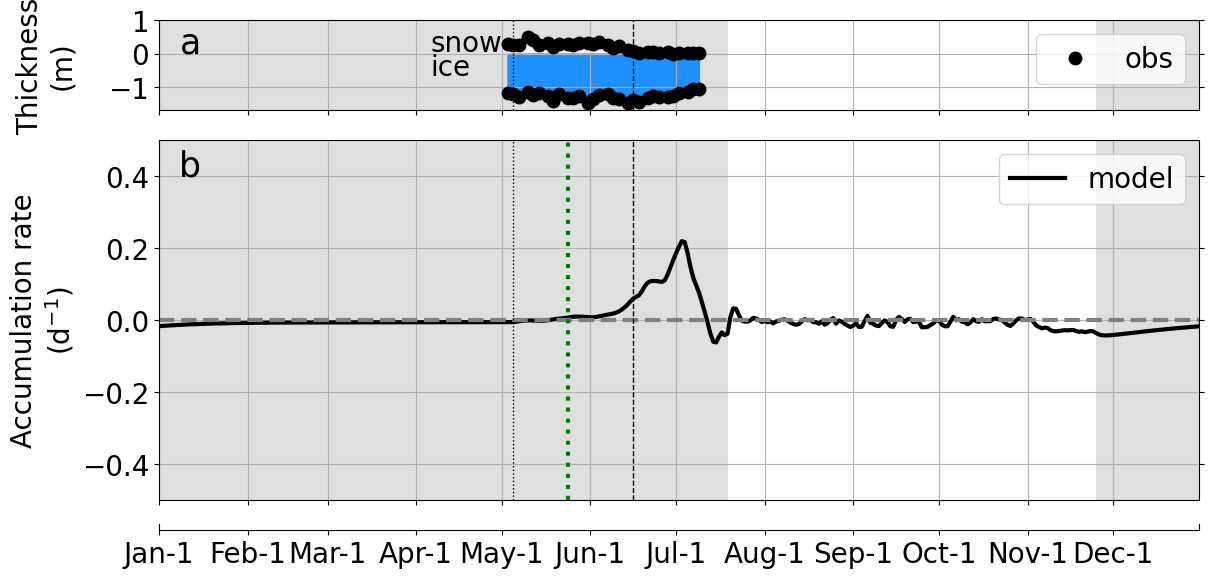

In [100]:
def make_plots(axs):
    box=dict(pad=5,alpha=0)
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    xlims=(first_year[0],first_year[-1])
    xmin=xlims[0]
    xmax=xlims[1]

    # --- SNOW AND ICE THICKNESS
    ax=axs[0]
    ymin=-1.7
    ymax=1.0
    xsnow=(snow_thickness_df['doy']-1).to_numpy()
    ysnow=snow_thickness_df['sample_thickness_m_average'].to_numpy()
    h1=ax.plot(xsnow,ysnow,
               'o',color='black',label='obs')
    xsnow_to_fill=np.arange(xsnow[0],xsnow[-1]+1)
    ysnow_to_fill=np.interp(xsnow_to_fill,xsnow,ysnow)
    h2=ax.fill_between(xsnow_to_fill,ysnow_to_fill,
                       linestyle='-',color='aliceblue')
    ax.text(95,0.3,'snow',
            horizontalalignment = 'left',verticalalignment = 'center')
    xice=(ice_thickness_df['doy']-1).to_numpy()
    yice=-ice_thickness_df['sample_thickness_m_average'].to_numpy()
    h3=ax.plot(xice,yice,'o',color='black')
    xice_to_fill=np.arange(xice[0],xice[-1]+1)
    yice_to_fill=np.interp(xice_to_fill,xice,yice)
    h4=ax.fill_between(xice_to_fill,yice_to_fill,
                       linestyle='-',color='dodgerblue')
    ax.text(95,-0.40,'ice',
            horizontalalignment = 'left',verticalalignment = 'center')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylim(ymin,ymax)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('Thickness\n(m)',bbox=box)
    ax.grid()
    ax.legend(loc='upper right')
    plt.text(0.03,0.75,' a ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linewidth=1,linestyle='--')

    # --- ACCUMULATION RATE
    ax=axs[1]
    ymin=-0.5
    ymax= 0.5
    h1=ax.plot(first_year,array1d_iT_acc,
               '-',color='black',lw=3,label='model')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylim(ymin,ymax)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('Accumulation rate\n($\mathrm{ d^{-1} }$)')
    ax.grid()
    ax.legend(loc='upper right')
    ax.plot(xlims,[0,0],'k--',color='gray')
    plt.text(0.03,0.93,' b ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linewidth=1,linestyle='--')
    ax.axvline(date_initiation,color='green',linestyle=':',
               label='bloom initiation')
    
    
    # --- ADDITIONAL X-AXIS
    ax=axs[2]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)

    # --- POSITION
    axs[0].set_position( [0.12,0.80  ,0.65,0.15])
    axs[1].set_position( [0.12,0.15  ,0.65,0.60])
    axs[2].set_position( [0.12,0.10  ,0.65,0.01])

with plt.style.context('mplstyles/validation.mplstyle'):
    # Plot
    fig,axs=plt.subplots(3,1,figsize=(16,6))
    make_plots(axs)
    fig.align_ylabels(axs[:])

    # --- SAVE
    outfile='figures_timing_sup_progress/chl.0000000000.t001.r.png'
#     plt.savefig(outfile)

Figure <exp0_r>.
Model accumulation rates.
(a) Observed snow and ice thickness.
(b) Model accumulation rates for the reference simulation (EXP-0).

The vertical black dotted line is the date of the first PAR observations.
The vertical black dashed line is the date of the snow melt completion.
The green dotted line is the date of the simulated bloom initiation. 
The grey rectangles represent the time of year before the observed sea ice break-up and after the simulated sea ice freeze-up.

### Model: $\mathrm{ \sum Chl\ } a$: date of bloom peak

The date of the bloom peak was the date of the maximum (vertically integrated, 0-100m) chlorophyll $a$.

In [101]:
date_peak=np.nanargmax(array1d_iT_modvintchl)
year=2016
# transform day of year into date
# https://stackoverflow.com/questions/2427555/python-question-year-and-day-of-year-to-date
# see answer of Ignacio Vazquez-Abrams
date_peaks=\
datetime.datetime(year,1,1) + datetime.timedelta(date_peak.item())

Day of year

In [102]:
date_peak+1

192

In [103]:
date_peaks.strftime("%B %d")

'July 10'

In [104]:
c_P=array1d_iT_modvintchl[date_peak]

(in $mg\ Chl\ m^{-2}$)

In [105]:
c_P

54.96791553265067

## Model MITgcm: $\mathrm{ C_{phyto} }$

$\mathrm{ C_{phyto} }$ is the biomass
in $\mathrm{ mg\ C\ m^{-3} }$.

In [106]:
cphytofile=os.path.join(indir_exp0,'car.0000000000.t001.nc')

### Model MITgcm: $\mathrm{ C_{phyto} }$: diatoms

$\mathrm{ C_{dia} }$ is the biomass of diatoms in
$\mathrm{ mg\ C\ m^{-3} }$.

In [107]:
# mg C m^-3
array2d_idepth_iT_modcphytodiatomfull\
=read_mitgcm.get_array2d_idepth_iT_diatombiofull(cphytofile)
array2d_idepth_iT_modcphytodiatom\
=array2d_idepth_iT_modcphytodiatomfull[:,array1d_iT1y_iT]

### Model MITgcm: $\mathrm{ C_{phyto} }$: dino

$\mathrm{ C_{dino} }$ is the biomass of dinoflagellates in
$\mathrm{ mg\ C\ m^{-3} }$.

In [108]:
# mg C m^-3
array2d_idepth_iT_modcphytodinofull\
=read_mitgcm.get_array2d_idepth_iT_dinobiofull(cphytofile)
array2d_idepth_iT_modcphytodino\
=array2d_idepth_iT_modcphytodinofull[:,array1d_iT1y_iT]

### Model MITgcm: $\mathrm{ C_{phyto} }$: other nanophytoplankton

$\mathrm{ C_{other} }$ is the biomass of other nanophytoplankton in
$\mathrm{ mg\ C\ m^{-3} }$.

In [109]:
# mg C m^-3
array2d_idepth_iT_modcphytootherfull\
=read_mitgcm.get_array2d_idepth_iT_otherbiofull(cphytofile)
array2d_idepth_iT_modcphytodiazofull\
=read_mitgcm.get_array2d_idepth_iT_diazobiofull(cphytofile)
array2d_idepth_iT_modcphytotrifull\
=read_mitgcm.get_array2d_idepth_iT_tribiofull(cphytofile)
array2d_idepth_iT_modcphytootherfull\
=array2d_idepth_iT_modcphytootherfull\
+array2d_idepth_iT_modcphytodiazofull\
+array2d_idepth_iT_modcphytotrifull
array2d_idepth_iT_modcphytoother\
=array2d_idepth_iT_modcphytootherfull[:,array1d_iT1y_iT]

### Model MITgcm: $\mathrm{ C_{phyto} }$: picophytoplankton

$\mathrm{ C_{pico} }$ is the biomass of picophytoplankton in
$\mathrm{ mg\ C\ m^{-3} }$.

In [110]:
# mg C m^-3
array2d_idepth_iT_modcphytoprofull\
=read_mitgcm.get_array2d_idepth_iT_probiofull(cphytofile)
array2d_idepth_iT_modcphytosynfull\
=read_mitgcm.get_array2d_idepth_iT_synbiofull(cphytofile)
array2d_idepth_iT_modcphytosmalleukfull\
=read_mitgcm.get_array2d_idepth_iT_smalleukbiofull(cphytofile)
array2d_idepth_iT_modcphytopicofull\
=array2d_idepth_iT_modcphytoprofull\
+array2d_idepth_iT_modcphytosynfull\
+array2d_idepth_iT_modcphytosmalleukfull
array2d_idepth_iT_modcphytopico\
=array2d_idepth_iT_modcphytopicofull[:,array1d_iT1y_iT]

## Model MITgcm: $\mathrm{ \sum C_{phyto} }$

$\mathrm{ \sum C_{phyto} }$ is the vertically integrated 
$\mathrm{ C_{phyto} }$ (0-100m)
in $\mathrm{ mg\ C\ m^{-2} }$.

In [111]:
depth_end=100

### Model MITgcm: $\mathrm{ \sum C_{phyto} }$: diatoms

In [112]:
# mg C a m^-2
array1d_iT_modvintcphytodiatom\
=vstats_pos.vint(
    array2d_idepth_iT_tracer=array2d_idepth_iT_modcphytodiatom,
    array1d_idepth_delR=drF,
    depth_end=depth_end)

### Model MITgcm: $\mathrm{ \sum C_{phyto} }$: dinoflagellates

In [113]:
# mg C m^-2
array1d_iT_modvintcphytodino\
=vstats_pos.vint(
    array2d_idepth_iT_tracer=array2d_idepth_iT_modcphytodino,
    array1d_idepth_delR=drF,
    depth_end=depth_end)

### Model MITgcm: $\mathrm{ \sum C_{phyto} }$: other nanophytoplankton

In [114]:
# mg C m^-2
array1d_iT_modvintcphytoother\
=vstats_pos.vint(
    array2d_idepth_iT_tracer\
    =array2d_idepth_iT_modcphytoother,
    array1d_idepth_delR=drF,
    depth_end=depth_end)

### Model MITgcm: $\mathrm{ \sum C_{phyto} }$: picophytoplankton

In [115]:
# mg C m^-2
array1d_iT_modvintcphytopico\
=vstats_pos.vint(
    array2d_idepth_iT_tracer\
    =array2d_idepth_iT_modcphytopico,
    array1d_idepth_delR=drF,
    depth_end=depth_end)

### Model MITgcm: $\mathrm{ \sum C_{phyto} }$: diatoms + dinoflagellates + other nanophytoplankton

Note that picophytoplankton are not included in the analysis of the integrated biomass as they were not part of the observations.

In [116]:
array1d_iT_modvintcphytodiatomdinoother\
=array1d_iT_modvintcphytodiatom\
+array1d_iT_modvintcphytodino\
+array1d_iT_modvintcphytoother

### Model MITgcm: $\mathrm{ \sum C_{phyto} }$: relative contribution

The relative contribution for validation purposes was calculated as a percentage of the biogeochemical functional group biomass vertically integrated (0-100m) from all the nanophytoplankton and microphytoplankton biomass.

In [117]:
array1d_iT_modvintcphyto\
=array1d_iT_modvintcphytodiatom+array1d_iT_modvintcphytodino\
+array1d_iT_modvintcphytoother
array1d_iT_modperccphytodiatom\
=array1d_iT_modvintcphytodiatom/array1d_iT_modvintcphyto*100
array1d_iT_modperccphytodino\
=array1d_iT_modvintcphytodino/array1d_iT_modvintcphyto*100
array1d_iT_modperccphytoother\
=array1d_iT_modvintcphytoother/array1d_iT_modvintcphyto*100

# Plot

## Plot: thickness, PAR, nutrients, $\mathrm{ \sum C_{phyto} }$, $\mathrm{ \sum Chl\ } a$, $\mathrm{ K_z}$, $\mathrm{ h_{BD} }$ and isolume

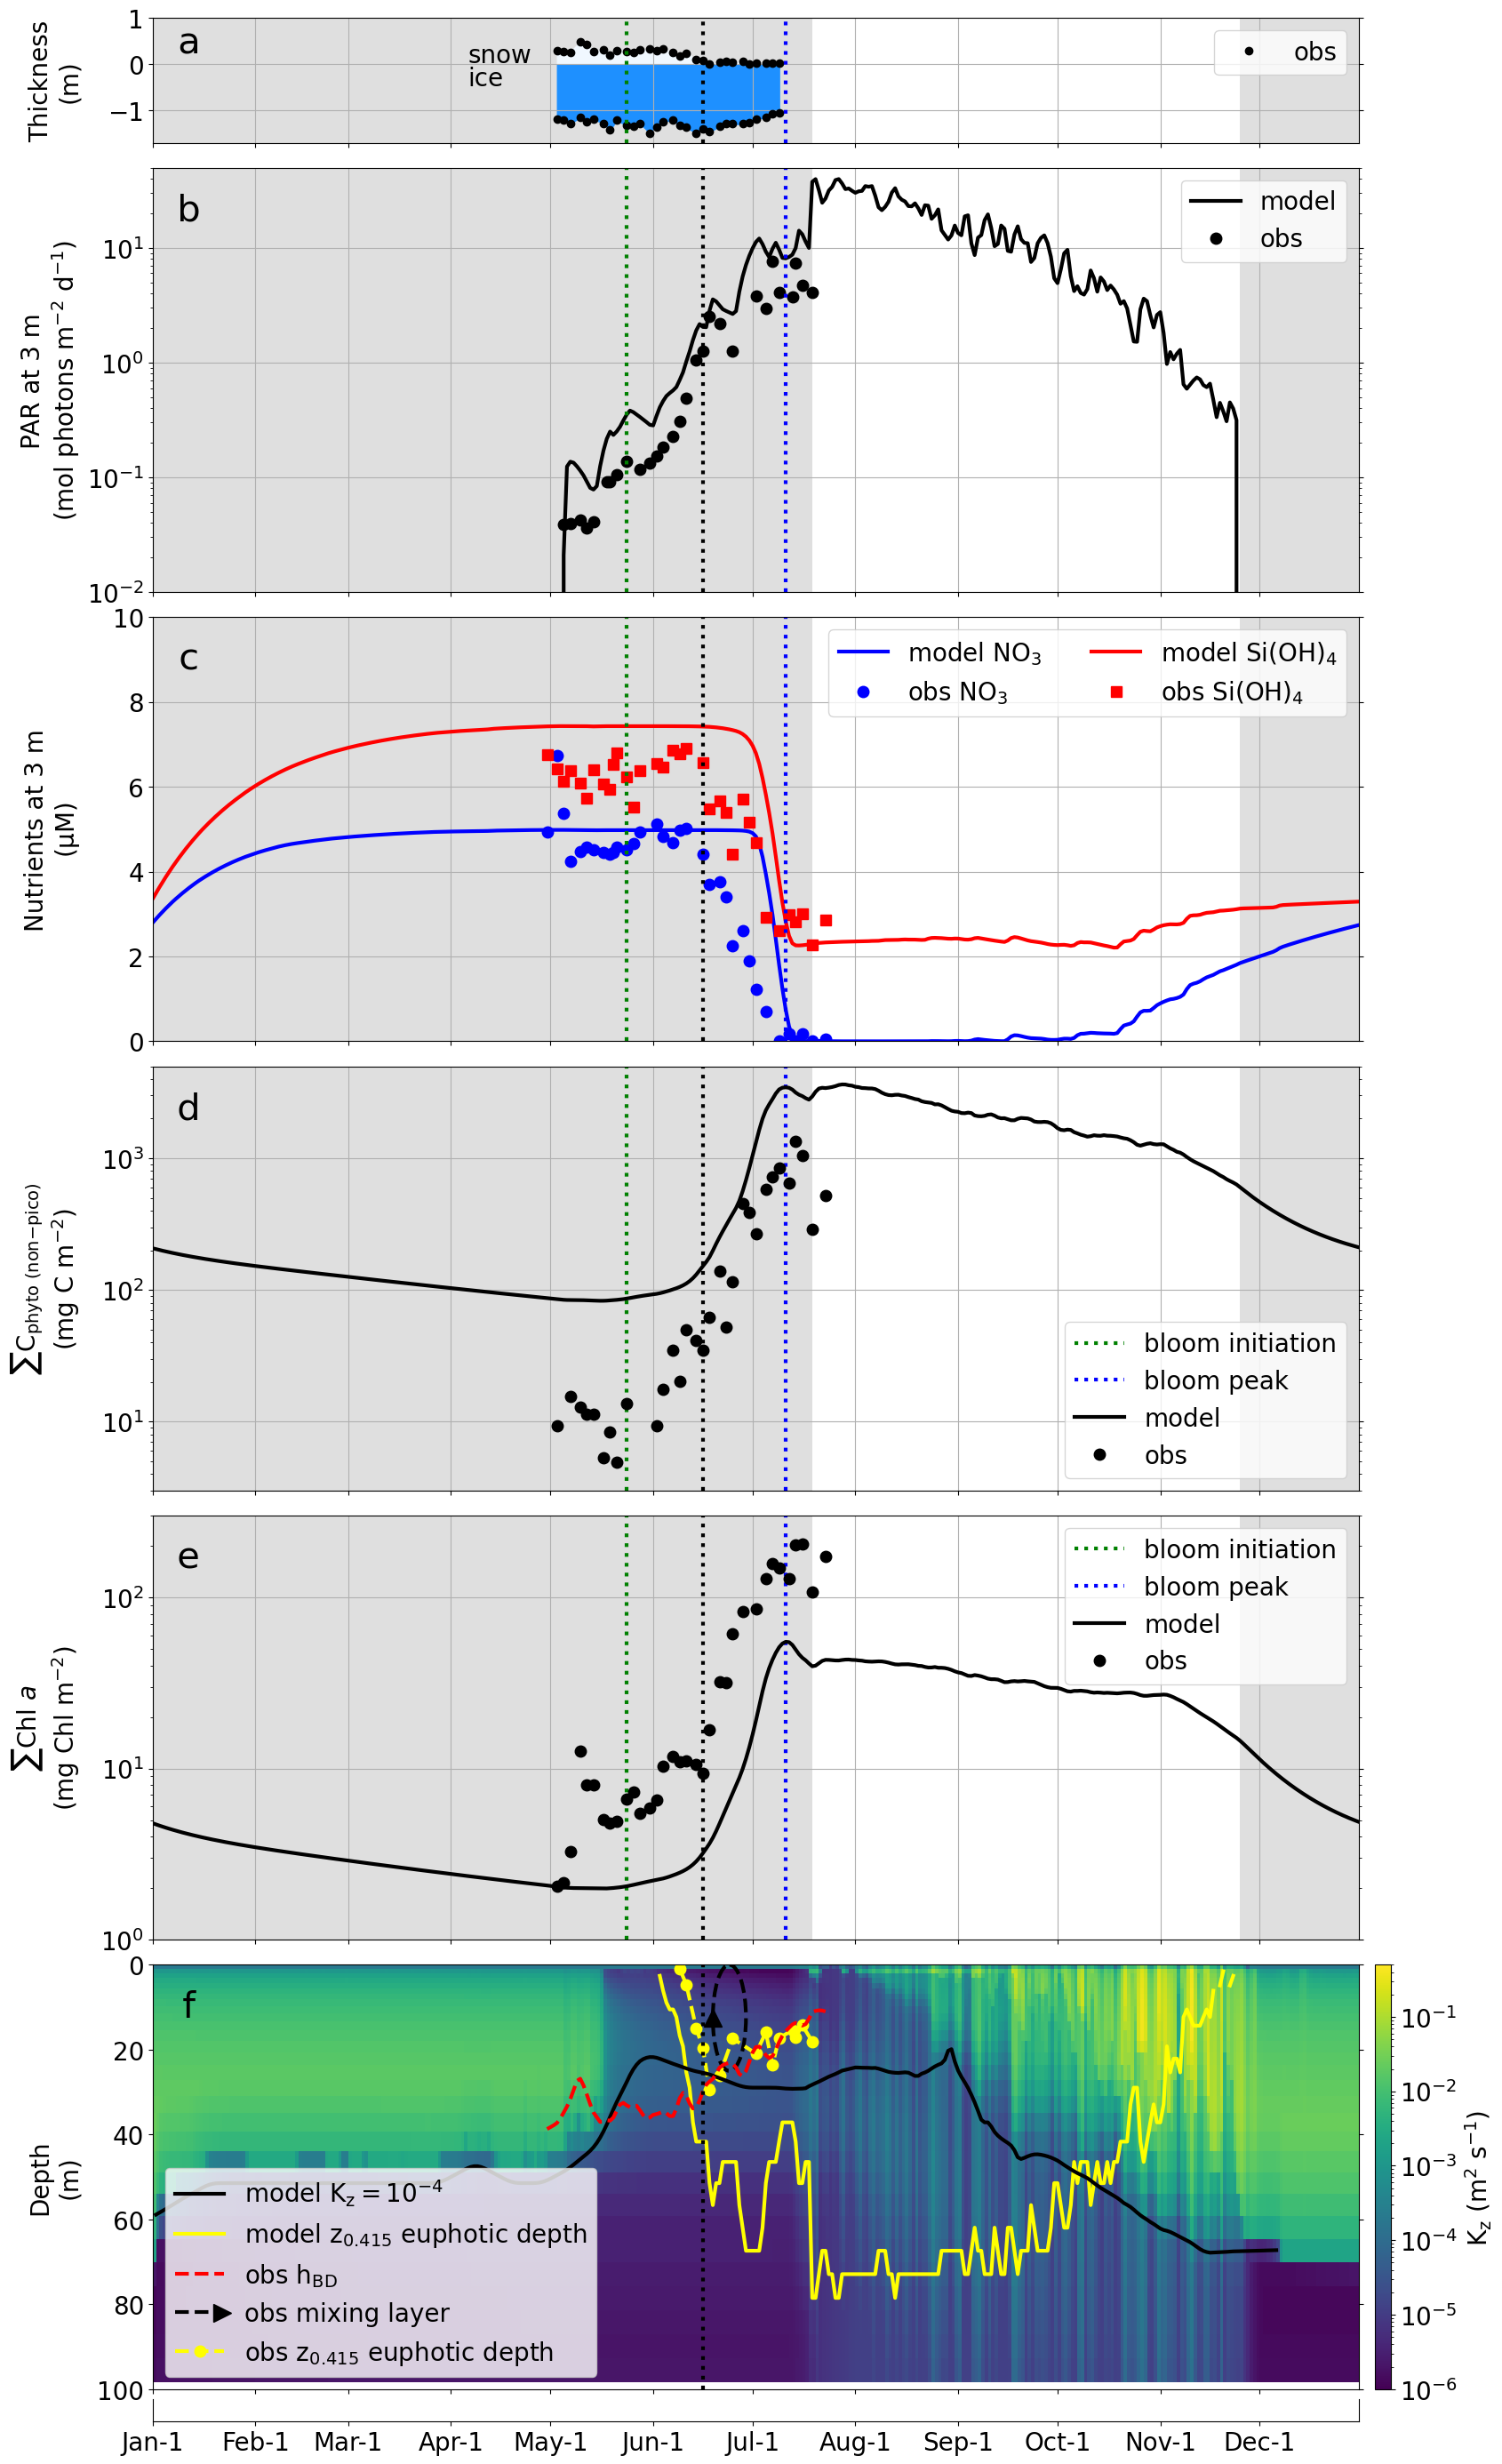

In [118]:
def make_plots(axs):
    box=dict(pad=5,alpha=0)
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    xlims=(first_year[0],first_year[-1])
    xmin=xlims[0]
    xmax=xlims[1]

    # --- SNOW AND ICE THICKNESS
    ax=axs[0]
    ymin=-1.7
    ymax=1.0
    xsnow=(snow_thickness_df['doy']-1).to_numpy()
    ysnow=snow_thickness_df['sample_thickness_m_average'].to_numpy()
    h1=ax.plot(xsnow,ysnow,
               'o',color='black',markersize=6,label='obs')
    xsnow_to_fill=np.arange(xsnow[0],xsnow[-1]+1)
    ysnow_to_fill=np.interp(xsnow_to_fill,xsnow,ysnow)
    h2=ax.fill_between(xsnow_to_fill,ysnow_to_fill,
                       linestyle='-',color='aliceblue')
    ax.text(95,0.2,'snow',
            horizontalalignment = 'left',verticalalignment = 'center')
    xice=(ice_thickness_df['doy']-1).to_numpy()
    yice=-ice_thickness_df['sample_thickness_m_average'].to_numpy()
    h3=ax.plot(xice,yice,'o',color='black',markersize=6)
    xice_to_fill=np.arange(xice[0],xice[-1]+1)
    yice_to_fill=np.interp(xice_to_fill,xice,yice)
    h4=ax.fill_between(xice_to_fill,yice_to_fill,
                       linestyle='-',color='dodgerblue')
    ax.text(95,-0.30,'ice',
            horizontalalignment = 'left',verticalalignment = 'center')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylim(ymin,ymax)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('Thickness\n(m)',bbox=box)
    ax.grid()
    ax.legend(loc='upper right')
    plt.text(0.03,0.80,' a ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
#     ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    ax.axvline(date_initiation,color='green',linestyle=':',
               label='bloom initiation')
    ax.axvline(date_peak,color='blue',linestyle=':',
               label='bloom peak')

    # --- PAR AT 3 m
    ax=axs[1]
    ymin=1E-2
    ymax=5E1
    h1=ax.plot(first_year,array1d_iT_modPAR3m,
               '-',color='black',label='model')
    ax.set_yscale('log')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylim(ymin,ymax)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('PAR at 3 m\n(mol photons m$^{-2}$ d$^{-1})$',bbox=box)
    ax.grid()
    h2=ax.plot(first_year,array1d_iT_obsPAR3m,
               'o',color='black',label='obs')
    ax.legend(loc='upper right')
    plt.text(0.03,0.90,' b ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
#     ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    ax.axvline(date_initiation,color='green',linestyle=':',
               label='bloom initiation')
    ax.axvline(date_peak,color='blue',linestyle=':',
               label='bloom peak')

    # --- NUTRIENTS
    ax=axs[2]
    ymin=0
    ymax=10
    h1=ax.plot(first_year,array1d_iT_modnitrate3m,'-',color='blue')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylim(ymin,ymax)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('Nutrients at 3 m\n($\mathrm{ \mu M }$)',bbox=box)
    ax.grid()
    h2=ax.plot(first_year,array1d_iT_silicicacid3m ,'-',color='red')
    h3=ax.plot(first_year,array1d_iT_obsnitrate3m,
               'o',color='blue')
    h4=ax.plot(first_year,array1d_iT_obssilica3m ,
               's',color='red')
    ax.legend([h1[0],h3[0],
               h2[0],h4[0]],
              ['model $\mathrm{ NO_3 }$','obs $\mathrm{ NO_3 }$',
               'model $\mathrm{ Si{(OH)}_4 }$','obs $\mathrm{ Si{(OH)}_4 }$'],
              loc='upper right', ncol=2)
    plt.text(0.03,0.90,' c ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
#     ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    ax.axvline(date_initiation,color='green',linestyle=':',
               label='bloom initiation')
    ax.axvline(date_peak,color='blue',linestyle=':',
               label='bloom peak')
    
    # -- SUM C_PHYTO
    ax=axs[3]
    # I considered doy=124 with an observed Sum C_phyto=0.3 as an outlier
    ymin=3
    ymax=5000
    ax.axvline(date_initiation,color='green',linestyle=':',
               label='bloom initiation')
    ax.axvline(date_peak,color='blue',linestyle=':',
               label='bloom peak')
    h1=ax.plot(first_year,array1d_iT_modvintcphytodiatomdinoother,
               '-',color='black',lw=3,label='model')
    h2=ax.plot(first_year,array1d_iT_obsvintcphyto,
               'o',color='black',label='obs')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_yscale('log')
    ax.set_ylim(ymin,ymax)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('$\mathrm{ \sum{} C_{phyto\ (non {-} pico)} }$\n'
                  '($\mathrm{ mg\ C\ m^{-2} }$)',
                  bbox=box)
    ax.grid()
    plt.text(0.03,0.90,' d ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
#     ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    ax.legend(loc='lower right')
    
    # --- SUM CHL A
    ax=axs[4]
    ymin=1
    ymax=300
    ax.axvline(date_initiation,color='green',linestyle=':',
               label='bloom initiation')
    ax.axvline(date_peak,color='blue',linestyle=':',
               label='bloom peak')
    h2=ax.plot(first_year,array1d_iT_modvintchl,
               '-',color='black',lw=3,label='model')
    h4=ax.plot(first_year,array1d_iT_obsvintchlHPLC,
               'o',color='black',label='obs')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_yscale('log')
    ax.set_ylim(ymin,ymax)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('$\mathrm{ \sum{} Chl\ }a$\n'
                  '($\mathrm{ mg\ Chl\ m^{-2} }$)',
                  bbox=box)
    ax.grid()
    plt.text(0.03,0.90,' e ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
#     ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    ax.legend(loc='upper right')
    
    # --- PHYSICAL VARIABLES
    ax=axs[5]
    ymin=0
    ymax=100
    RF_above100=RF[RF<100]
    
    # model Kz
    h=ax.pcolormesh(first_year366,
                    RF_above100,
                    array2d_idepth_iT_Kz[0:(RF_above100.size)-1,:],
                    cmap='viridis',
                    norm=mpl.colors.LogNorm(vmin=1E-6, vmax=0.5))
    
    # observed z_0415 euphotic depth
    h5=ax.plot(first_year,array1d_iT_obsisolume,
           'o',linewidth=3,color='yellow',linestyle='--',
           label='obs $\mathrm{ z_{0.415} }$ euphotic depth')
    ax.plot(first_year,array1d_iT_obsisolume_interp,
           linewidth=3,color='yellow',linestyle='--')
    
    # simulated z_0415 euphotic depth
    h2=ax.plot(first_year,array1d_iT_modisolume,
           linewidth=3,color='yellow',linestyle='-',
           label='model $\mathrm{ z_{0.415} }$ euphotic depth')
    
    # model Kz=10^-4
#     h1=ax.plot(first_year,array1d_iT_modisoKz1,
#             color='black',
#             label='model $\mathrm{ K_z=10^{-4} } $')
    h1=ax.plot(first_year,array1d_iT_modisoKz1lowess,
            color='black',
            label='model $\mathrm{ K_z=10^{-4} } $')
    cbaxes = fig.add_axes([0.88, 0.03, 0.01, 0.17])
    cbar=plt.colorbar(h,cax = cbaxes)
    cbar.set_label('$\mathrm{ K_z }$ ($\mathrm{ m^2\ s^{-1} }$)')
    
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylim(ymin,ymax)
    ax.yaxis.set_ticks_position('both')
    ax.invert_yaxis()
    ax.set_ylabel('Depth\n(m)')
    
    # observed mixing layer
    xy=obsKz_date,obsKz/2
    width,height=10,obsKz
    ellipse=mpl.patches.Ellipse(xy=xy,width=width,height=height,
                                fill=False,
                                linewidth=3,color='black',linestyle='--')
    ax.add_patch(ellipse)
    ax.plot(obsKz_date-width/2,obsKz/2,
            '^',color='black',markersize=15)
    h4=ax.plot(0,0,
            linewidth=3,color='black',linestyle='--',
            label='obs mixing layer')
    
    # observed hBD
    h3=ax.plot(np.array(hBD_df.doy),np.array(hBD_df.hBD),
            color='red',linestyle='--',
            label='obs $\mathrm{ h_{BD} }$')
    
    lns=h1+h2+h3+h4+h5
    labs = [l.get_label() for l in lns]
    legend=ax.legend(lns,labs,loc='lower left')
    legend.set_zorder(3)
    ax.plot(21,82,'>',color='black',markersize=15,zorder=4)
    plt.text(0.03,0.90,' f ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
#     ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    
    # --- ADDITIONAL X-AXIS
    ax=axs[6]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)

    # --- POSITION
    axs[0].set_position( [0.12,0.93  ,0.75,0.05])
    axs[1].set_position( [0.12,0.75  ,0.75,0.17])
    axs[2].set_position( [0.12,0.57  ,0.75,0.17])
    axs[3].set_position( [0.12,0.39  ,0.75,0.17])
    axs[4].set_position( [0.12,0.21  ,0.75,0.17])
    axs[5].set_position( [0.12,0.03  ,0.75,0.17])
    axs[6].set_position( [0.12,0.017,0.75,0.009])

with plt.style.context('mplstyles/validation.mplstyle'):
    # Plot
    fig,axs=plt.subplots(7,1,figsize=(18.1,28.08))
    make_plots(axs)
    fig.align_ylabels(axs[:])

    # --- SAVE
    outfile='figures_timing_progress/validation.'+ext
    plt.savefig(outfile,dpi=dpi)

Figure \<physical\>. Comparison to observations.
(a) Observed snow and ice thickness.
(b) Surface daily PAR at 3 m. Black dots are $in\ situ$ daily downwelling plane PAR.
Solid black line is the model daily scalar PAR from MITgcm.
(c) Surface nitrate concentration and surface silicic acid concentration at 3 m.
Dots are $in\ situ$ nutrient concentrations.
Lines are the model nutrient concentrations from MITgcm.
(d) Vertically integrated biomass of phytoplankton
($\mathrm{ \sum C_{phyto\ (non {-} pico)} }$, 0-100m).
Dots are $in\ situ$ biomass.
The line is the model biomass from MITgcm.
Note that picophytoplankton are not included in the analysis of the
integrated biomass as they were not part of the observations.
The observations from May 4th were 0.3 $\mathrm{ mg\ C\ m^{-2} }$.
This value was less than ten times less than the other lowest value.
Thus, this point was removed from the plot.
$\mathrm{ \sum C_{phyto\ (non {-} pico)} }$
is shown above
$\mathrm{ \sum\ Chl}\ a$
because the model needed the biomass to calculate the Chl $a$.
(e) Vertically integrated Chl a (0-100m).
Dots are $in\ situ$ Chl $a$.
The line is the model Chl $a$ from MITgcm.
(f) Physical variables.
The background is the model vertical turbulent diffusivity
($\mathrm{ K_z }$) from NEMO-LIM3.
The depth at which model
$\mathrm{ K_z=10^{-4}\ m^2\ s^{-1} }$
is the black solid line.
The depth of the model
$\mathrm{ z_{0.415}\ mol\ photons\ m^{-2}\ d^{-1} }$
isolume from MITgcm is the yellow complete line.
The depths of the observed equivalent mixed layer 
($\mathrm{ h_{BD} }$)
$sensu$ Randelhoff et al. (2017) is the red dashed line.
The depth of the observed mixing layer measured on June 23, 2016 as described in Oziel et al. (2019) is the black dashed arrow.
The depth of the observed
$\mathrm{ z_{0.415}\ mol\ photons\ m^{-2}\ d^{-1} }$
isolume is the yellow dashed line.

The vertical green, black and blue dotted lines are the dates of
the simulated bloom initiation,
the snow melt completion
and the simulated bloom peak, respectively.
The grey rectangles represent the time of year before the observed sea ice break-up and after the simulated sea ice freeze-up.

## Plot: groups

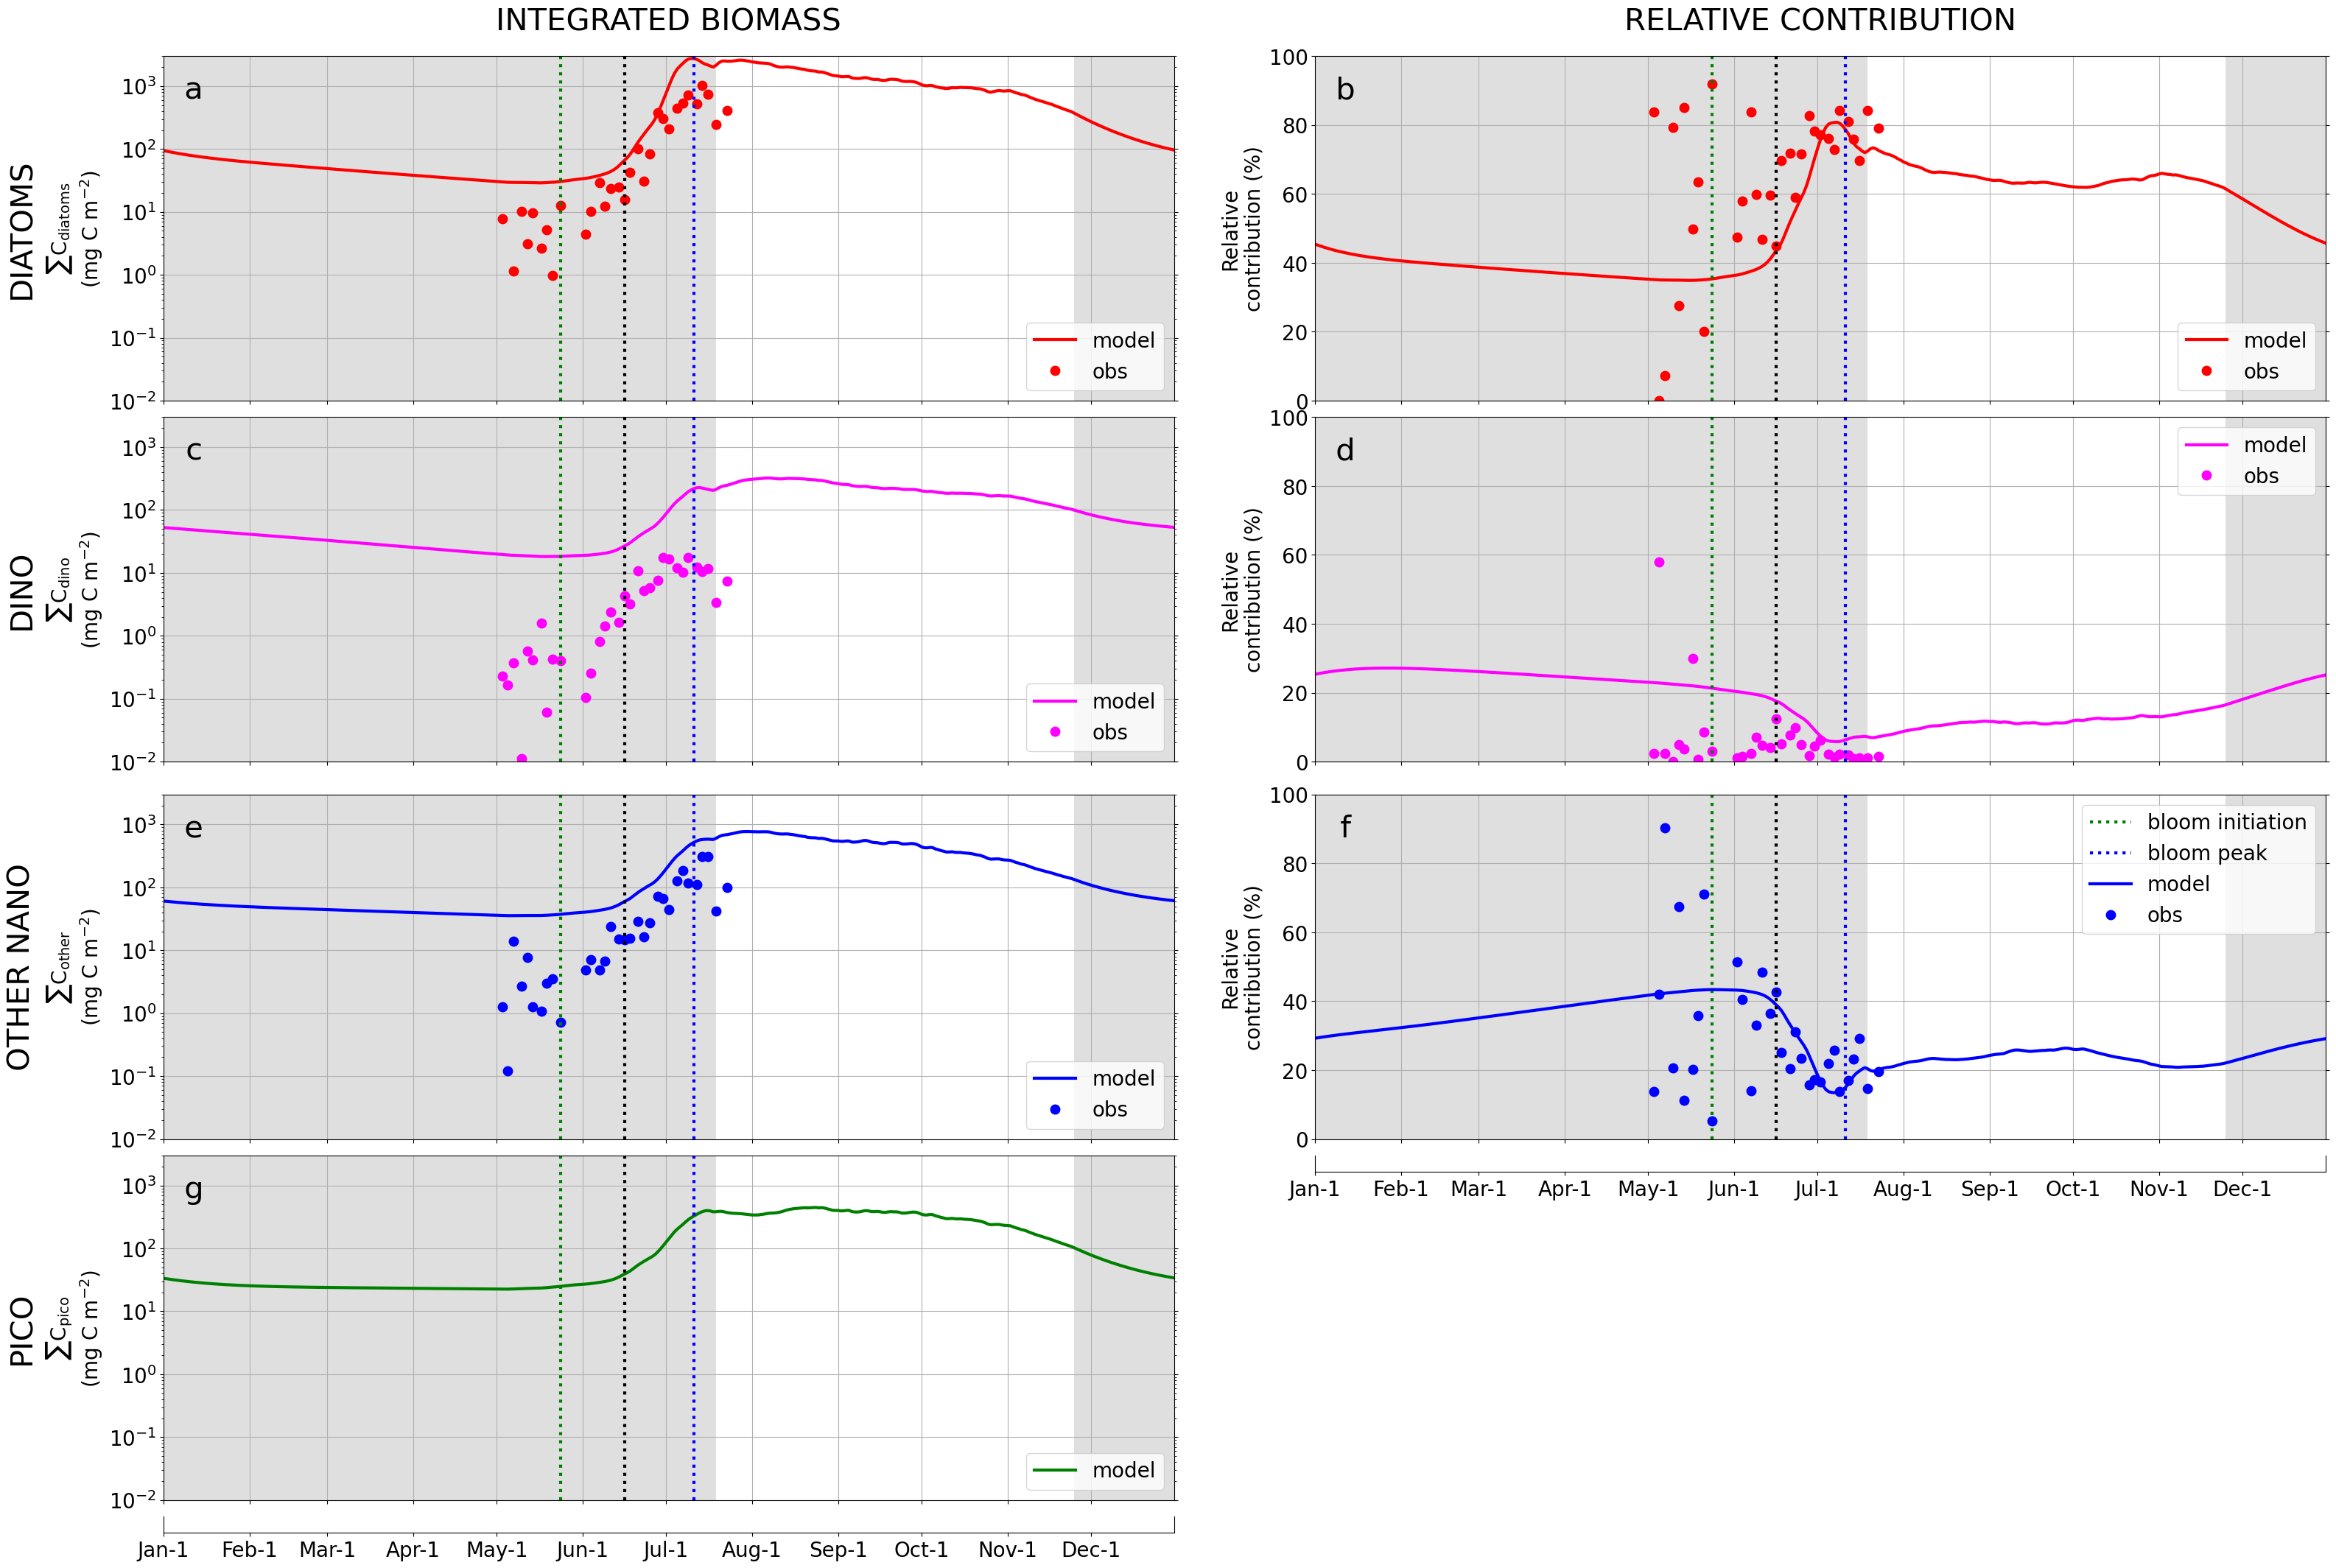

In [119]:
def make_plots(axs):
    box=dict(pad=5,alpha=0)
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    xlims=(first_year[0],first_year[-1])
    xmin=xlims[0]
    xmax=xlims[1]
    
    # --- SUM C_PHYTO DIATOMS
    ax=axs[0,0]
    ymin=0.01
    ymax=3000
    
    h1=ax.plot(first_year,array1d_iT_modvintcphytodiatom,
               '-',color='red',label='model')
    h2=ax.plot(first_year,array1d_iT_obsvintcphytodiatom,
               'o',color='red',label='obs')
    
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_yscale('log')
    ax.set_ylim(ymin,ymax)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('$\mathrm{ \sum{} C_{diatoms} }$\n'
                  '($\mathrm{ mg\ C\ m^{-2} }$)',
                  bbox=box)
    ax.grid()
    plt.text(0.03,0.90,' a ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
#     ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    ax.legend(loc='lower right')
    ax.axvline(date_initiation,color='green',linestyle=':',
               label='bloom initiation')
    ax.axvline(date_peak,color='blue',linestyle=':',
               label='bloom peak')
    plt.text(-0.14,0.50,'DIATOMS',rotation='vertical',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    plt.text(0.50,1.10,'INTEGRATED BIOMASS',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    
    # --- CONTRIBUTION DIATOMS
    ax=axs[0,1]
    ymin=0
    ymax=100
    
    h1=ax.plot(first_year,array1d_iT_modperccphytodiatom,
               '-',color='red',label='model')
    h2=ax.plot(first_year,array1d_iT_obsperccphytodiatom,
               'o',color='red',label='obs')
    
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylim(ymin,ymax)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('Relative\n'
                  'contribution (%)',
                  bbox=box)
    ax.grid()
    plt.text(0.03,0.90,' b ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
#     ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    ax.legend(loc='lower right')
    ax.axvline(date_initiation,color='green',linestyle=':',
               label='bloom initiation')
    ax.axvline(date_peak,color='blue',linestyle=':',
               label='bloom peak')
    plt.text(0.50,1.10,'RELATIVE CONTRIBUTION',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    
    # --- SUM C_PHYTO DINOFLAGELLATES
    ax=axs[1,0]
    ymin=0.01
    ymax=3000
    
    h1=ax.plot(first_year,array1d_iT_modvintcphytodino,
               '-',color='magenta',label='model')
    h2=ax.plot(first_year,array1d_iT_obsvintcphytodino,
               'o',color='magenta',label='obs')
    
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_yscale('log')
    ax.set_ylim(ymin,ymax)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('$\mathrm{ \sum{} C_{dino} }$\n'
                  '($\mathrm{ mg\ C\ m^{-2} }$)',
                  bbox=box)
    ax.grid()
    plt.text(0.03,0.90,' c ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
#     ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    ax.legend(loc='lower right')
    ax.axvline(date_initiation,color='green',linestyle=':',
               label='bloom initiation')
    ax.axvline(date_peak,color='blue',linestyle=':',
               label='bloom peak')
    plt.text(-0.14,0.50,'DINO',rotation='vertical',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    
    # --- CONTRIBUTION DINO
    ax=axs[1,1]
    ymin=0
    ymax=100
    
    h1=ax.plot(first_year,array1d_iT_modperccphytodino,
               '-',color='magenta',label='model')
    h2=ax.plot(first_year,array1d_iT_obsperccphytodino,
               'o',color='magenta',label='obs')
    
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylim(ymin,ymax)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('Relative\n'
                  'contribution (%)',
                  bbox=box)
    ax.grid()
    plt.text(0.03,0.90,' d ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
#     ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    ax.legend(loc='upper right')
    ax.axvline(date_initiation,color='green',linestyle=':',
               label='bloom initiation')
    ax.axvline(date_peak,color='blue',linestyle=':',
               label='bloom peak')
    
    # --- SUM C_PHYTO OTHER NANO
    ax=axs[2,0]
    ymin=0.01
    ymax=3000
    
    h1=ax.plot(first_year,array1d_iT_modvintcphytoother,
               '-',color='blue',label='model')
    h2=ax.plot(first_year,array1d_iT_obsvintcphytoother,
               'o',color='blue',label='obs')
    
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_yscale('log')
    ax.set_ylim(ymin,ymax)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('$\mathrm{ \sum{} C_{other} }$\n'
                  '($\mathrm{ mg\ C\ m^{-2} }$)',
                  bbox=box)
    ax.grid()
    plt.text(0.03,0.90,' e ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
#     ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    ax.legend(loc='lower right')
    ax.axvline(date_initiation,color='green',linestyle=':',
               label='bloom initiation')
    ax.axvline(date_peak,color='blue',linestyle=':',
               label='bloom peak')
    plt.text(-0.14,0.50,'OTHER NANO',rotation='vertical',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    
    # --- CONTRIBUTION OTHER NANO
    ax=axs[2,1]
    ymin=0
    ymax=100
    ax.axvline(date_initiation,color='green',linestyle=':',
               label='bloom initiation')
    ax.axvline(date_peak,color='blue',linestyle=':',
               label='bloom peak')
    
    h1=ax.plot(first_year,array1d_iT_modperccphytoother,
               '-',color='blue',label='model')
    h2=ax.plot(first_year,array1d_iT_obsperccphytoother,
               'o',color='blue',label='obs')
    
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylim(ymin,ymax)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('Relative\n'
                  'contribution (%)',
                  bbox=box)
    ax.grid()
    plt.text(0.03,0.90,' f ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
#     ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    ax.legend(loc='upper right')
    
    # --- NOTHING
    ax=axs[3,0]
    ax.axis('off')
    
    # --- ADDITIONAL X-AXIS
    ax=axs[3,1]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # --- SUM C_PHYTO PICO
    ax=axs[4,0]
    ymin=0.01
    ymax=3000
    
    h1=ax.plot(first_year,array1d_iT_modvintcphytopico,
               '-',color='green',label='model')
    
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_yscale('log')
    ax.set_ylim(ymin,ymax)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('$\mathrm{ \sum{} C_{pico} }$\n'
                  '($\mathrm{ mg\ C\ m^{-2} }$)',
                  bbox=box)
    ax.grid()
    plt.text(0.03,0.90,' g ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
#     ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    plt.text(-0.14,0.50,'PICO',rotation='vertical',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    ax.legend(loc='lower right')
    ax.axvline(date_initiation,color='green',linestyle=':',
               label='bloom initiation')
    ax.axvline(date_peak,color='blue',linestyle=':',
               label='bloom peak')
    
    # --- NOTHING
    ax=axs[4,1]
    ax.axis('off')
    
    # --- ADDITIONAL X-AXIS
    ax=axs[5,0]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # --- NOTHING
    ax=axs[5,1]
    ax.axis('off')
    
    
    # --- POSITION
    axs[0,0].set_position([0.07,0.72, 0.43,0.21])
    axs[0,1].set_position([0.56,0.72, 0.43,0.21])
    axs[1,0].set_position([0.07,0.50, 0.43,0.21])
    axs[1,1].set_position([0.56,0.50, 0.43,0.21])
    axs[2,0].set_position([0.07,0.27, 0.43,0.21])
    axs[2,1].set_position([0.56,0.27, 0.43,0.21])
    axs[3,0].set_position([0.07,0.25, 0.43,0.01])
    axs[3,1].set_position([0.56,0.25, 0.43,0.01])
    axs[4,0].set_position([0.07,0.05, 0.43,0.21])
    axs[4,1].set_position([0.56,0.05, 0.43,0.21])
    axs[5,0].set_position([0.07,0.03, 0.43,0.01])
    axs[5,1].set_position([0.56,0.02, 0.43,0.01])

with plt.style.context('mplstyles/groups.mplstyle'):
    # Plot
    fig,axs=plt.subplots(nrows=6,ncols=2,figsize=(31.90,22.28))
    make_plots(axs)

    # --- SAVE
    outfile='figures_timing_progress/groups.'+ext
    plt.savefig(outfile,dpi=dpi)

Figure <groups>.
Comparison to observations. Vertically integrated biomass of each functional group (0-100m, left). Relative contribution of each functional group to the total (diatoms+dinoflagellates+other nanophytoplankton) biomass (right). Note that picophytoplankton are not included in the analysis of the relative contribution as they were not part of the observations.
The vertical green, black and blue dotted lines are the dates of
the simulated bloom initiation,
the snow melt completion
and the simulated bloom peak, respectively.
The grey rectangles represent the time of year before the sea ice break-up and after the sea ice freeze-up.

# Taylor diagram

For values in $\mathrm{ mg\ C\ m^{-3} }$.

The values at 0.51 m on the model grid are extrapolated to 0 m. It is the only extrapolation.

In [120]:
no3mod_df=vstats_pos.project_mod_on_obs(
    obs_df=nutrients_df,
    array2d_idepth_iT_mod=array2d_idepth_iT_modno3,
    mod_varname='no3',
    array1d_idepth_delR=RC)
sioh4mod_df=vstats_pos.project_mod_on_obs(
    obs_df=nutrients_df,
    array2d_idepth_iT_mod=array2d_idepth_iT_modsioh4,
    mod_varname='sioh4',
    array1d_idepth_delR=RC)
po4mod_df=vstats_pos.project_mod_on_obs(
    obs_df=nutrients_df,
    array2d_idepth_iT_mod=array2d_idepth_iT_modpo4,
    mod_varname='po4',
    array1d_idepth_delR=RC)
nutrientsmod_df=pd.concat(
    [no3mod_df,
     sioh4mod_df['sioh4'],
     po4mod_df['po4']],
    axis=1)
chlmod_df=vstats_pos.project_mod_on_obs(
    obs_df=chlHPLC_df,
    array2d_idepth_iT_mod=array2d_idepth_iT_modchl,
    mod_varname='chl',
    array1d_idepth_delR=RC)
simdiatom_df=vstats_pos.project_mod_on_obs(
    obs_df=diatomsobs_df,
    array2d_idepth_iT_mod=array2d_idepth_iT_modcphytodiatom,
    mod_varname='carbon_estimate_mg_c_m3',
    array1d_idepth_delR=RC)
simdino_df=vstats_pos.project_mod_on_obs(
    obs_df=dinoobs_df,
    array2d_idepth_iT_mod=array2d_idepth_iT_modcphytodino,
    mod_varname='carbon_estimate_mg_c_m3',
    array1d_idepth_delR=RC)
simother_df=vstats_pos.project_mod_on_obs(
    obs_df=otherobs_df,
    array2d_idepth_iT_mod=array2d_idepth_iT_modcphytoother,
    mod_varname='carbon_estimate_mg_c_m3',
    array1d_idepth_delR=RC)

In [121]:
nstdlogno3,corrcoeflogno3=vstats_pos.get_nstd_corrcoef(
    obs_df=nutrients_df,
    obs_varname='no3',
    mod_df=nutrientsmod_df,
    mod_varname='no3')
nstdlogsioh4,corrcoeflogsioh4=vstats_pos.get_nstd_corrcoef(
    obs_df=nutrients_df,
    obs_varname='sioh4',
    mod_df=nutrientsmod_df,
    mod_varname='sioh4')
nstdlogpo4,corrcoeflogpo4=vstats_pos.get_nstd_corrcoef(
    obs_df=nutrients_df,
    obs_varname='po4',
    mod_df=nutrientsmod_df,
    mod_varname='po4')
nstdlogchl,corrcoeflogchl=vstats_pos.get_nstd_corrcoef(
    obs_df=chlHPLC_df,
    obs_varname='chlHPLC',
    mod_df=chlmod_df,
    mod_varname='chl')
nstdlogdiatom,corrcoeflogdiatom=vstats_pos.get_nstd_corrcoef(
    obs_df=diatomsobs_df,
    obs_varname='carbon_estimate_mg_c_m3',
    mod_df=simdiatom_df,
    mod_varname='carbon_estimate_mg_c_m3')
nstdlogdino,corrcoeflogdino=vstats_pos.get_nstd_corrcoef(
    obs_df=dinoobs_df,
    obs_varname='carbon_estimate_mg_c_m3',
    mod_df=simdino_df,
    mod_varname='carbon_estimate_mg_c_m3')
nstdlogother,corrcoeflogother=vstats_pos.get_nstd_corrcoef(
    obs_df=otherobs_df,
    obs_varname='carbon_estimate_mg_c_m3',
    mod_df=simother_df,
    mod_varname='carbon_estimate_mg_c_m3')

In [122]:
nstdlogno3,corrcoeflogno3

(0.8139236761639759, 0.7040137290147664)

In [123]:
nstdlogsioh4,corrcoeflogsioh4

(0.8867224241245579, 0.9123859204296801)

In [124]:
nstdlogpo4,corrcoeflogpo4

(0.7306836685428458, 0.8176780101827529)

In [125]:
nstdlogchl,corrcoeflogchl

(1.0526144082117586, 0.8898104820226214)

In [126]:
nstdlogdiatom,corrcoeflogdiatom

(1.0661032273915854, 0.8167521498057688)

In [127]:
nstdlogdino,corrcoeflogdino

(1.15267953709523, 0.6291044797746508)

In [128]:
nstdlogother,corrcoeflogother

(0.7531434362507821, 0.7530500201353136)

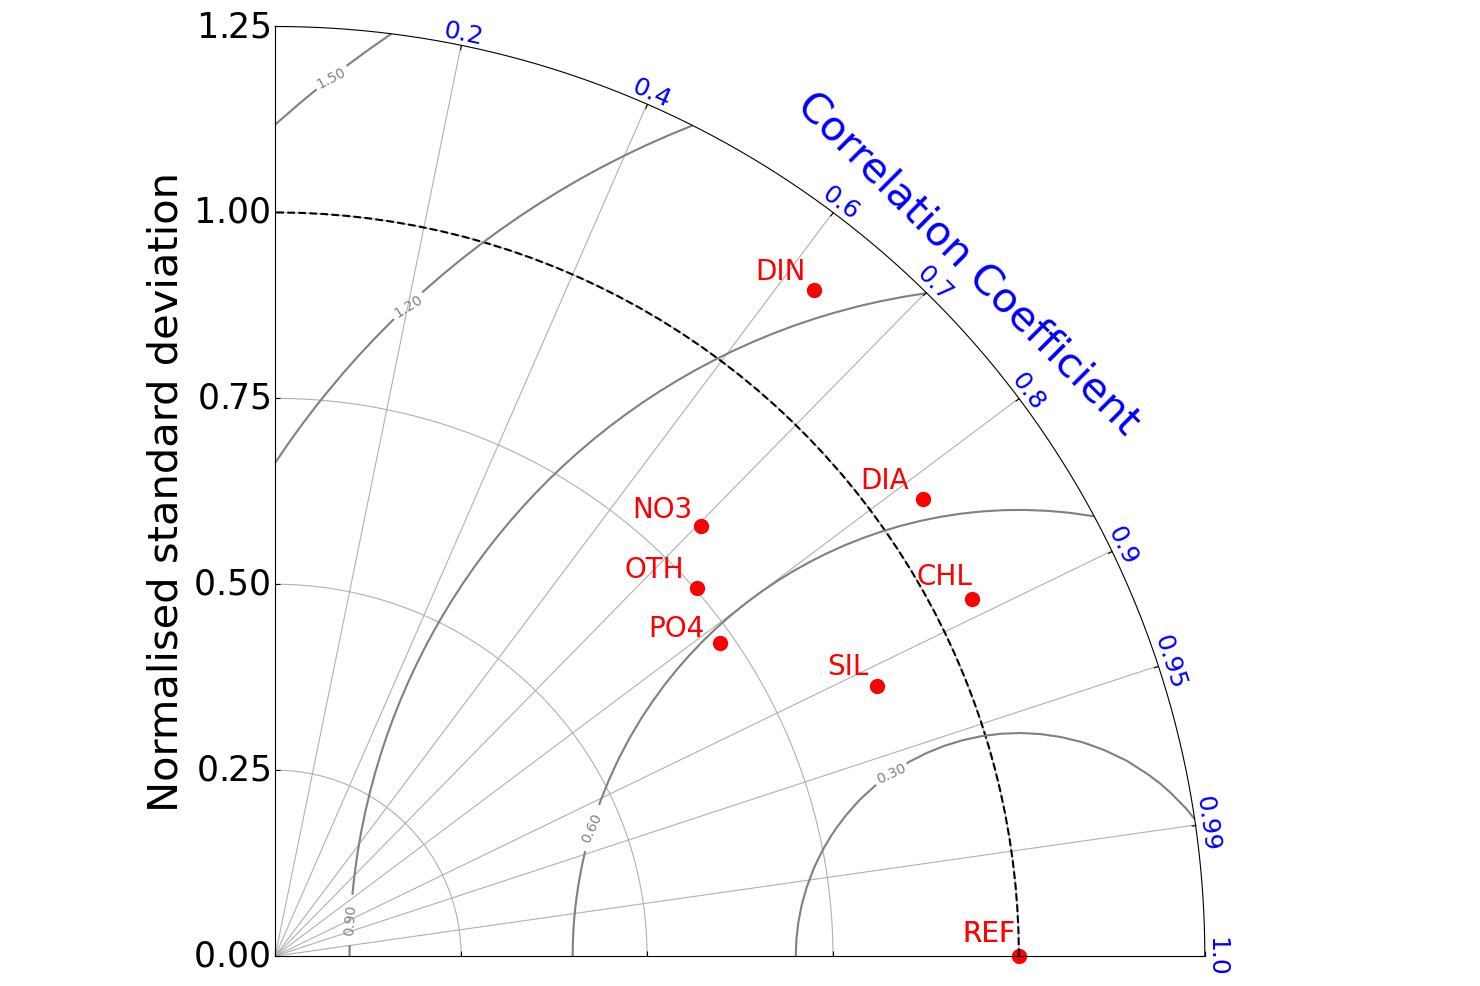

In [129]:
def make_plots(fig):
    plt.axis('off')
    refnstd=1
    rect=111
    extend=False
    
    dia=TaylorDiagram.TaylorDiagram(refnstd,
                                    fig=fig,
                                    rect=rect,
                                    label='Reference',
                                    srange=(0.00,1.25),
                                    extend=extend)
    dia.add_sample(nstdlogchl,
                   corrcoeflogchl,
                   marker='o',
                   ms=10,
                   ls='',
                   mfc='red',
                   mec='red')
    dia.add_sample(nstdlogno3,
                   corrcoeflogno3,
                   marker='o',
                   ms=10,
                   ls='',
                   mfc='red',
                   mec='red')
    dia.add_sample(nstdlogsioh4,
                   corrcoeflogsioh4,
                   marker='o',
                   ms=10,
                   ls='',
                   mfc='red',
                   mec='red')
    dia.add_sample(nstdlogpo4,
                   corrcoeflogpo4,
                   marker='o',
                   ms=10,
                   ls='',
                   mfc='red',
                   mec='red')
    dia.add_sample(nstdlogdiatom,
                   corrcoeflogdiatom,
                   marker='o',
                   ms=10,
                   ls='',
                   mfc='red',
                   mec='red',
                   label='DIA')
    dia.add_sample(nstdlogdino,
                   corrcoeflogdino,
                   marker='o',
                   ms=10,
                   ls='',
                   mfc='red',
                   mec='red',
                   label='DIN')
    dia.add_sample(nstdlogother,
                   corrcoeflogother,
                   marker='o',
                   ms=10,
                   ls='',
                   mfc='red',
                   mec='red',
                   label='OTH')
    dia.add_grid()
    contours=dia.add_contours(colors='0.5')
    plt.clabel(contours, inline=1, fontsize=10, fmt='%.2f')

    plt.text(0.90,0.51,'CHL',
             horizontalalignment = 'center',verticalalignment='center',
             color='red', fontsize=20)
    plt.text(0.52,0.60,'NO3',
             horizontalalignment = 'center',verticalalignment='center',
             color='red', fontsize=20)
    plt.text(0.77,0.39,'SIL',
             horizontalalignment = 'center',verticalalignment='center',
             color='red', fontsize=20)
    plt.text(0.54,0.44,'PO4',
             horizontalalignment = 'center',verticalalignment='center',
             color='red', fontsize=20)
    plt.text(0.82,0.64,'DIA',
             horizontalalignment = 'center',verticalalignment='center',
             color='red', fontsize=20)
    plt.text(0.68,0.92,'DIN',
             horizontalalignment = 'center',verticalalignment='center',
             color='red', fontsize=20)
    plt.text(0.51,0.52,'OTH',
             horizontalalignment = 'center',verticalalignment='center',
             color='red', fontsize=20)
    plt.text(0.96,0.03,'REF',
             horizontalalignment = 'center',verticalalignment='center',
             color='red', fontsize=20)
    plt.text(0.96,0.03,'REF',
             horizontalalignment = 'center',verticalalignment='center',
             color='red', fontsize=20)
    plt.tight_layout()

with plt.style.context('mplstyles/taylor.mplstyle'):   
    # PLOT
    fig=plt.figure(figsize=(14.90,10.00))
    make_plots(fig)

    # --- SAVE
    plt.savefig('figures_timing_progress/taylor.'+ext,dpi=dpi)

# EXP-1, differing minimum biomass

## EXP-1: directories

In [130]:
indir_EXP1_2grp_Xmin_1Eminus0\
='data/DataS6_output_mitgcm/exp1_Cmin1Eminus0'
indir_EXP1_2grp_Xmin_1Eminus1\
='data/DataS6_output_mitgcm/exp1_Cmin1Eminus1'
indir_EXP1_2grp_Xmin_1Eminus2_default\
='data/DataS6_output_mitgcm/exp1_Cmin1Eminus2'
indir_EXP1_2grp_Xmin_1Eminus3\
='data/DataS6_output_mitgcm/exp1_Cmin1Eminus3'
indir_EXP1_2grp_Xmin_0\
='data/DataS6_output_mitgcm/exp1_Cmin0'

## EXP-1: $\mathrm{ \sum C_{phyto} }$

$\mathrm{ \sum C_{phyto} }$ was the vertically integrated 
$\mathrm{ C_{phyto} }$ (0-100m)
in $\mathrm{ mg\ C\ m^{-2} }$.
It included all groups of numerical phytoplankton (diatoms+dinoflagellates+other nanophytoplankton+picophytoplankton).
Note that picophytoplankton were included.
Picophytoplankton were not included for the validation due to the 
lower limit in size for the observations with the Imaging FlowCytobot
(IFCB).
Nonetheless, picophytoplankton were included in the sensitivity
experiment to take into account possible variations in picophytoplankton
biomasses between simulations.

In [131]:
# get vertically integrated C_phyto
def get_array1d_iT_vintcphyto(indir,array1d_iT1y_iT,depth_end):
    cphytofile=os.path.join(indir,'car.0000000000.t001.nc')
    # mg Chl-a m^-3
    array2d_idepth_iT_cphytofull=\
    read_mitgcm.get_array2d_idepth_iT_phytobiofull(cphytofile)
    # mg Chl-a m^-2
    array1d_iT_vintcphytofull\
    =vstats_pos.vint(
        array2d_idepth_iT_tracer=array2d_idepth_iT_cphytofull,
        array1d_idepth_delR=drF,
        depth_end=depth_end)
    array1d_iT_vintcphyto=array1d_iT_vintcphytofull[array1d_iT1y_iT]
    return array1d_iT_vintcphyto

In [132]:
depth_end=100
array1d_iT_modvintcphyto_EXP1_2grp_Xmin_1Eminus0\
=get_array1d_iT_vintcphyto(indir_EXP1_2grp_Xmin_1Eminus0,
                           array1d_iT1y_iT,
                           depth_end)
array1d_iT_modvintcphyto_EXP1_2grp_Xmin_1Eminus1\
=get_array1d_iT_vintcphyto(indir_EXP1_2grp_Xmin_1Eminus1,
                           array1d_iT1y_iT,
                           depth_end)
array1d_iT_modvintcphyto_EXP1_2grp_Xmin_1Eminus2_default\
=get_array1d_iT_vintcphyto(indir_EXP1_2grp_Xmin_1Eminus2_default,
                           array1d_iT1y_iT,
                           depth_end)
array1d_iT_modvintcphyto_EXP1_2grp_Xmin_1Eminus3\
=get_array1d_iT_vintcphyto(indir_EXP1_2grp_Xmin_1Eminus3,
                           array1d_iT1y_iT,
                           depth_end)
array1d_iT_modvintcphyto_EXP1_2grp_Xmin_0\
=get_array1d_iT_vintcphyto(indir_EXP1_2grp_Xmin_0,
                           array1d_iT1y_iT,
                           depth_end)

## EXP-1: $\mathrm{ \sum Chl\ }a$

In [133]:
depth_end=100
array1d_iT_modvintchl_EXP1_2grp_Xmin_1Eminus0\
=get_array1d_iT_vintchl(indir_EXP1_2grp_Xmin_1Eminus0,
                        array1d_iT1y_iT,
                        depth_end)
array1d_iT_modvintchl_EXP1_2grp_Xmin_1Eminus1\
=get_array1d_iT_vintchl(indir_EXP1_2grp_Xmin_1Eminus1,
                        array1d_iT1y_iT,
                        depth_end)
array1d_iT_modvintchl_EXP1_2grp_Xmin_1Eminus2_default\
=get_array1d_iT_vintchl(indir_EXP1_2grp_Xmin_1Eminus2_default,
                        array1d_iT1y_iT,
                        depth_end)
array1d_iT_modvintchl_EXP1_2grp_Xmin_1Eminus3\
=get_array1d_iT_vintchl(indir_EXP1_2grp_Xmin_1Eminus3,
                        array1d_iT1y_iT,
                        depth_end)
array1d_iT_modvintchl_EXP1_2grp_Xmin_0\
=get_array1d_iT_vintchl(indir_EXP1_2grp_Xmin_0,
                        array1d_iT1y_iT,
                        depth_end)

## EXP-1: Plot

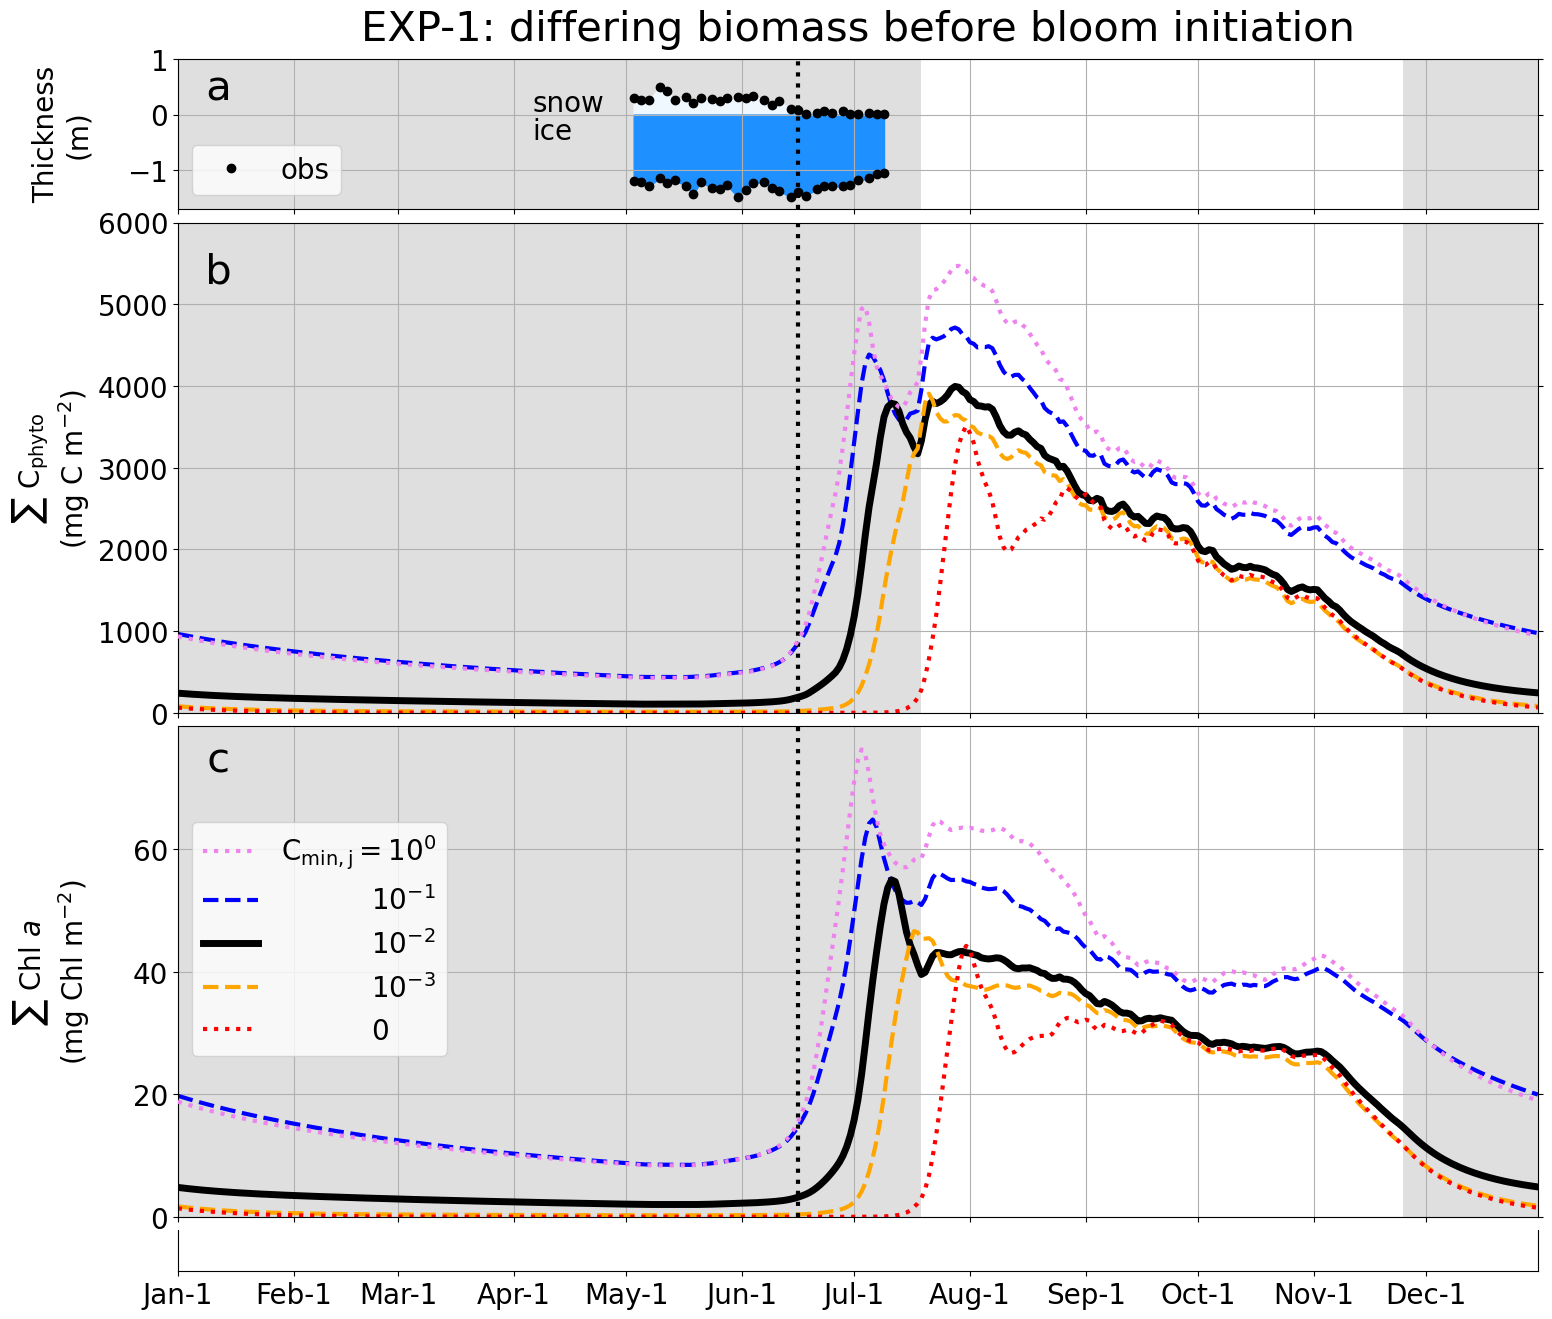

In [134]:
def make_plots(axs):
    box=dict(pad=5,alpha=0)
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    xlims=(first_year[0],first_year[-1])
    xmin=xlims[0]
    xmax=xlims[1]

    # --- SNOW AND ICE THICKNESS
    ax=axs[0]
    ymin=-1.7
    ymax=1.0
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    xsnow=(snow_thickness_df['doy']-1).to_numpy()
    ysnow=snow_thickness_df['sample_thickness_m_average'].to_numpy()
    h1=ax.plot(xsnow,ysnow,
               'o',color='black',markersize=6,label='obs')
    xsnow_to_fill=np.arange(xsnow[0],xsnow[-1]+1)
    ysnow_to_fill=np.interp(xsnow_to_fill,xsnow,ysnow)
    h2=ax.fill_between(xsnow_to_fill,ysnow_to_fill,
                       linestyle='-',color='aliceblue')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Thickness\n(m)',bbox=box)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(ymin,ymax)
    ax.grid()
    ax.text(95,0.2,'snow',
            horizontalalignment = 'left',verticalalignment = 'center',
            fontsize=20)
    xice=(ice_thickness_df['doy']-1).to_numpy()
    yice=-ice_thickness_df['sample_thickness_m_average'].to_numpy()
    h3=ax.plot(xice,yice,'o',color='black',markersize=6)
    xice_to_fill=np.arange(xice[0],xice[-1]+1)
    yice_to_fill=np.interp(xice_to_fill,xice,yice)
    h4=ax.fill_between(xice_to_fill,yice_to_fill,
                       linestyle='-',color='dodgerblue')
    ax.text(95,-0.30,'ice',
            horizontalalignment = 'left',verticalalignment = 'center',
            fontsize=20)
    ax.legend(loc='lower left')
    plt.text(0.03,0.80,' a ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    plt.text(0.5,1.2,'EXP-1: differing biomass before bloom initiation',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
#     ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    
    # --- EXP-1.2: SUM C PHYTO
    ax=axs[1]
    h_EXP1_2grp_Xmin_1Eminus0=ax.plot(
        first_year,
        array1d_iT_modvintcphyto_EXP1_2grp_Xmin_1Eminus0,
        ':',color='violet',zorder=10)
    h_EXP1_2grp_Xmin_1Eminus1=ax.plot(
        first_year,
        array1d_iT_modvintcphyto_EXP1_2grp_Xmin_1Eminus1,
        '--',color='blue')
    h_EXP1_2grp_Xmin_1Eminus2_default=ax.plot(
        first_year,
        array1d_iT_modvintcphyto_EXP1_2grp_Xmin_1Eminus2_default,
        '-',color='black',linewidth=5)
    h_EXP1_2grp_Xmin_1Eminus3=ax.plot(
        first_year,
        array1d_iT_modvintcphyto_EXP1_2grp_Xmin_1Eminus3,
        '--',color='orange')
    h_EXP1_2grp_Xmin0=ax.plot(
        first_year,
        array1d_iT_modvintcphyto_EXP1_2grp_Xmin_0,
        ':',color='red')

    # log
    # ax.set_yscale('log')
    # ymin=9E-3
    # ymax=7000
    # linear
    ymin=0
    ymax=6000
    ax.set_yticks(range(0,7000,1000))
    
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('$\mathrm{ \sum\ C_{phyto} }$\n'
                  '($\mathrm{ mg\ C\ m^{-2} }$)')
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(ymin,ymax)
    ax.grid()
    plt.text(0.03,0.90,' b ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
#     ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    
    # --- EXP-1.2: SUM CHL A
    ax=axs[2]
    h_EXP1_2grp_Xmin_1Eminus0=ax.plot(
        first_year,
        array1d_iT_modvintchl_EXP1_2grp_Xmin_1Eminus0,
        ':',color='violet',zorder=10,
        label='$\mathrm{ C_{min,j}=10^{0} }$')
    h_EXP1_2grp_Xmin_1Eminus1=ax.plot(
        first_year,
        array1d_iT_modvintchl_EXP1_2grp_Xmin_1Eminus1,
        '--',color='blue',
        label='$\mathrm{ \ \ \ \ \ \ \ \ \ \ 10^{-1} }$')
    h_EXP1_2grp_Xmin_1Eminus2_default=ax.plot(
        first_year,
        array1d_iT_modvintchl_EXP1_2grp_Xmin_1Eminus2_default,
        '-',color='black',linewidth=5,
        label='$\mathrm{ \ \ \ \ \ \ \ \ \ \ 10^{-2} }$')
    h_EXP1_2grp_Xmin_1Eminus3=ax.plot(
        first_year,
        array1d_iT_modvintchl_EXP1_2grp_Xmin_1Eminus3,
        '--',color='orange',
        label='$\mathrm{ \ \ \ \ \ \ \ \ \ \ 10^{-3} }$')
    h_EXP1_2grp_Xmin_0=ax.plot(
        first_year,
        array1d_iT_modvintchl_EXP1_2grp_Xmin_0,
        ':',color='red',
        label='$\mathrm{ \ \ \ \ \ \ \ \ \ \ 0       }$')
#     h_obs=ax.plot(
#         first_year,
#         array1d_iT_obsvintchlHPLC,
#         'o',color='black',zorder=10,label='obs')

    # log
    # ax.set_yscale('log')
    # ymin=1E-4
    # ymax=100
    # ax.legend(loc='lower right',bbox_to_anchor=(0.90,0.00))
    # linear
    ymin=0
    ymax=80
    ax.set_yticks(range(0,80,20))
    ax.legend(loc='lower left',bbox_to_anchor=(0.00,0.30))
    
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('$\mathrm{ \sum\ Chl\ }a$\n'
                  '($\mathrm{ mg\ Chl\ m^{-2} }$)')
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(ymin,ymax)
    ax.grid()
    plt.text(0.03,0.93,' c ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
#     ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    
    # --- ADDITIONAL X-AXIS
    ax=axs[3]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)

    # --- POSITION
    axs[0].set_position( [0.13,0.82 ,0.85,0.11])
    axs[1].set_position( [0.13,0.45 ,0.85,0.36])
    axs[2].set_position( [0.13,0.08 ,0.85,0.36])
    axs[3].set_position( [0.13,0.04 ,0.85,0.03])

with plt.style.context('mplstyles/exp1.mplstyle'):
    # Plot
    fig,axs=plt.subplots(4,1,figsize=(16,13.62))
    make_plots(axs)
    fig.align_ylabels(axs[:])

    # --- SAVE
    outfile='figures_timing_progress/exp1_total.'+ext
    plt.savefig(outfile,dpi=dpi)

Fig. \<exp1_total\>.
Sensitivity simulations: EXP-1 prescribed minimum biomass
($\mathrm{ C_{min} }$)
at $\mathrm{ 0 }$,
$\mathrm{ 10^{-3} }$,
$\mathrm{ 10^{-2} }$,
$\mathrm{ 10^{-1} }$ and
$\mathrm{ 10^{ 0}\ mmol\ C\ m^{-3}\ type^{-1} }$
for each of the 26 numerical phytoplankton types.
$\mathrm{ 10^{-2}\ mmol\ C\ m^{-3}\ type^{-1} }$
was the minimum biomass for the reference simulation
(complete black line).
This complete black line is the same output as shown in Fig.
\<validation\>d and e for the original ("reference") simulation.
(a) Observed snow and ice thickness.
(b) Vertically integrated biomass of phytoplankton (0-100m).
    Only model biomass is shown.
(c) Vertically integrated Chl a (0-100m).
    Dots are in situ Chl a.
    The lines are the model Chl a.
The vertical black dotted line is the date of
the snow melt completion.
The grey rectangles represent the time of year before the sea ice
break-up and after the sea ice freeze-up.

# EXP-2, differing light under sea ice

## EXP-2: Forcing fields for PAR($\mathrm{ 0^- }$)

In $\mathrm{ mol\ photons\ m^{-2}\ d^{-1} }$.

In [135]:
infile_PAR_EXP0\
='data/DataS5_forcing_fields_light/1D_obs_PARice_EXP0_y2016.365.32bits.bin'
infile_PAR_EXP1_1_1\
='data/DataS5_forcing_fields_light/1D_obs_PARice_EXP1_1_1_y2016.365.32bits.bin'
infile_PAR_EXP1_1_2\
='data/DataS5_forcing_fields_light/1D_obs_PARice_EXP1_1_2_y2016.365.32bits.bin'
infile_PAR_Iw\
='data/DataS5_forcing_fields_light/1D_GDPS_PAR_y2016.365.32bits.bin'
array1d_iT_modPAR0m_EXP0    =np.fromfile(infile_PAR_EXP0,dtype='>f4')
array1d_iT_modPAR0m_EXP1_1_1=np.fromfile(infile_PAR_EXP1_1_1,dtype='>f4')
array1d_iT_modPAR0m_EXP1_1_2=np.fromfile(infile_PAR_EXP1_1_2,dtype='>f4')
array1d_iT_modPAR0m_Iw      =np.fromfile(infile_PAR_Iw,dtype='>f4')
array1d_iT_modPAR0m_EXP0    =array1d_iT_modPAR0m_EXP0    *uEs2Ed
array1d_iT_modPAR0m_EXP1_1_1=array1d_iT_modPAR0m_EXP1_1_1*uEs2Ed
array1d_iT_modPAR0m_EXP1_1_2=array1d_iT_modPAR0m_EXP1_1_2*uEs2Ed
array1d_iT_modPAR0m_Iw      =array1d_iT_modPAR0m_Iw      *uEs2Ed
array1d_iT_modPAR0m_EXP0    [obs_breakup:sim_freezeup]             =np.nan
array1d_iT_modPAR0m_EXP1_1_1[obs_breakup:sim_freezeup]             =np.nan
array1d_iT_modPAR0m_EXP1_1_2[obs_breakup:sim_freezeup]             =np.nan
array1d_iT_modPAR0m_Iw      [np.r_[0:obs_breakup,sim_freezeup:365]]=np.nan

## EXP-2: directories

In [136]:
indir_EXP0\
='data/DataS6_output_mitgcm/exp0'
indir_EXP1_1_1\
='data/DataS6_output_mitgcm/exp2_1'
indir_EXP1_1_2\
='data/DataS6_output_mitgcm/exp2_2'

## EXP-2: $\mathrm{ \sum C_{phyto} }$

In [137]:
depth_end=100
array1d_iT_modvintcphyto_EXP0\
=get_array1d_iT_vintcphyto(indir_EXP0,
                           array1d_iT1y_iT,
                           depth_end)
array1d_iT_modvintcphyto_EXP1_1_1\
=get_array1d_iT_vintcphyto(indir_EXP1_1_1,
                           array1d_iT1y_iT,
                           depth_end)
array1d_iT_modvintcphyto_EXP1_1_2\
=get_array1d_iT_vintcphyto(indir_EXP1_1_2,
                        array1d_iT1y_iT,
                        depth_end)

## EXP-2: $\mathrm{ \sum Chl\ }a$

In [138]:
depth_end=100
array1d_iT_modvintchl_EXP0\
=get_array1d_iT_vintchl(indir_EXP0,
                        array1d_iT1y_iT,
                        depth_end)
array1d_iT_modvintchl_EXP1_1_1\
=get_array1d_iT_vintchl(indir_EXP1_1_1,
                        array1d_iT1y_iT,
                        depth_end)
array1d_iT_modvintchl_EXP1_1_2\
=get_array1d_iT_vintchl(indir_EXP1_1_2,
                        array1d_iT1y_iT,
                        depth_end)

## EXP-2: Plot

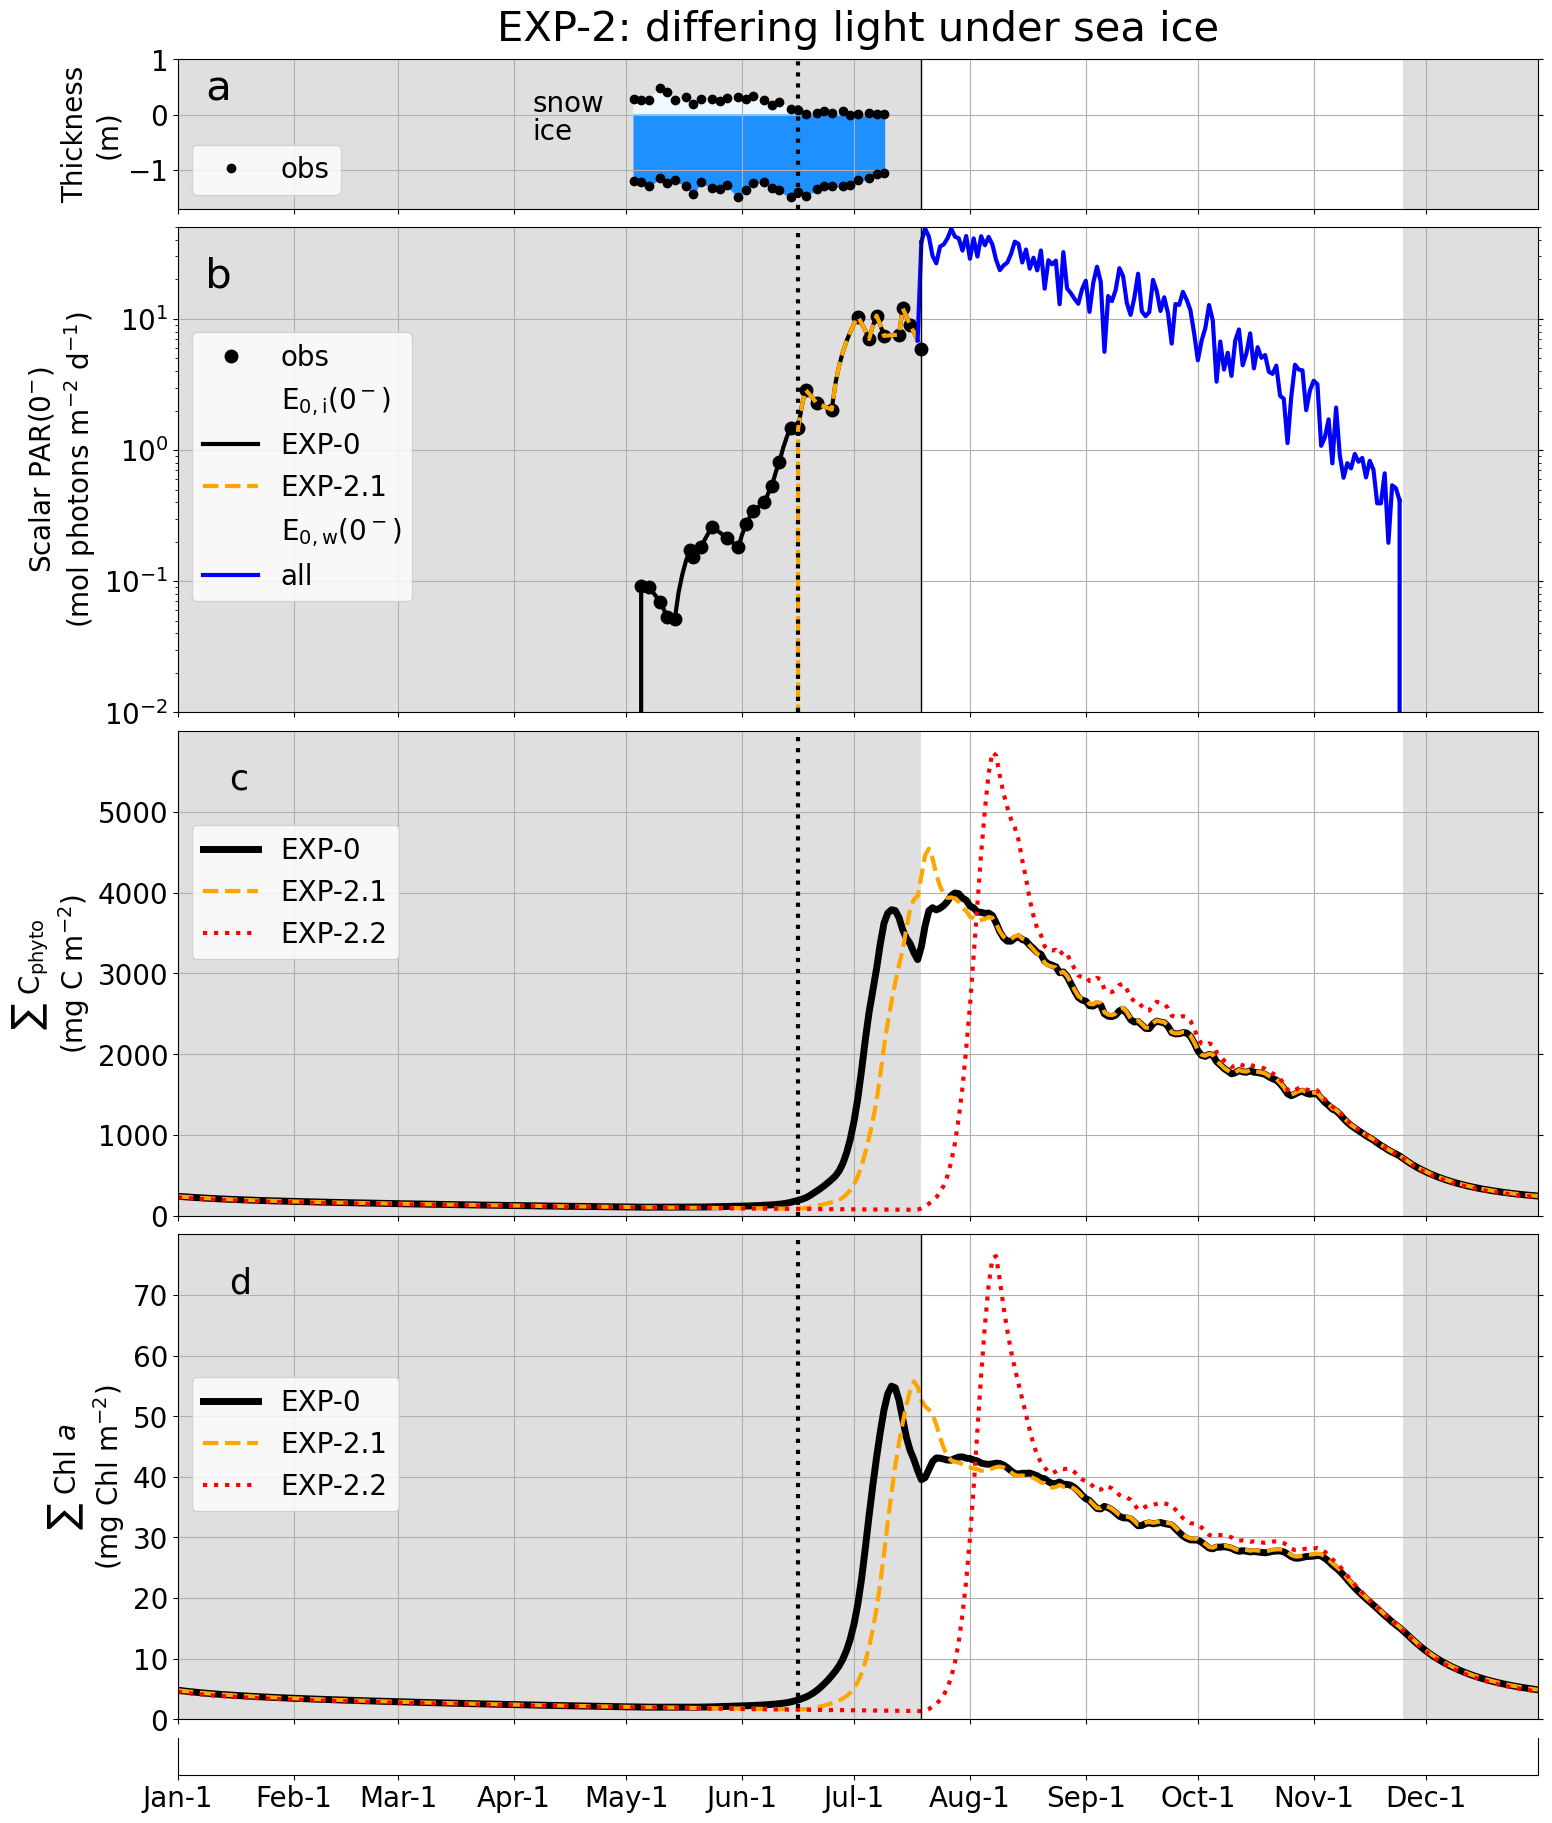

In [139]:
def make_plots(axs):
    box=dict(pad=5,alpha=0)
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    xlims=(first_year[0],first_year[-1])
    xmin=xlims[0]
    xmax=xlims[1]

    # --- SNOW AND ICE THICKNESS
    ax=axs[0]
    ymin=-1.7
    ymax=1.0
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    xsnow=(snow_thickness_df['doy']-1).to_numpy()
    ysnow=snow_thickness_df['sample_thickness_m_average'].to_numpy()
    h1=ax.plot(xsnow,ysnow,
               'o',color='black',markersize=6,label='obs')
    xsnow_to_fill=np.arange(xsnow[0],xsnow[-1]+1)
    ysnow_to_fill=np.interp(xsnow_to_fill,xsnow,ysnow)
    h2=ax.fill_between(xsnow_to_fill,ysnow_to_fill,
                       linestyle='-',color='aliceblue')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Thickness\n(m)',bbox=box)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(ymin,ymax)
    ax.grid()
    ax.text(95,0.2,'snow',
            horizontalalignment = 'left',verticalalignment = 'center',
            fontsize=20)
    xice=(ice_thickness_df['doy']-1).to_numpy()
    yice=-ice_thickness_df['sample_thickness_m_average'].to_numpy()
    h3=ax.plot(xice,yice,'o',color='black',markersize=6)
    xice_to_fill=np.arange(xice[0],xice[-1]+1)
    yice_to_fill=np.interp(xice_to_fill,xice,yice)
    h4=ax.fill_between(xice_to_fill,yice_to_fill,
                       linestyle='-',color='dodgerblue')
    ax.text(95,-0.30,'ice',
            horizontalalignment = 'left',verticalalignment = 'center',
            fontsize=20)
    ax.legend(loc='lower left')
    plt.text(0.03,0.80,' a ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    plt.text(0.5,1.2,'EXP-2: differing light under sea ice',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
#     ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    ax.axvline(obs_breakup,color='black',linewidth=1,linestyle='-')

    # --- SCALAR PAR AT 0- in mol photons m^-2 d^-1
    ax=axs[1]
    h6=ax.plot(first_year,array1d_iT_obsPAR0m,
               'o',color='black',label='obs')
    h_off_I_i=ax.plot(0,1,
                      '-',color='black',alpha=0,
                      label='$\mathrm{ E_{0,i}(0^-) }$')
    h1=ax.plot(first_year,array1d_iT_modPAR0m_EXP0,
               '-',color='black',label='EXP-0')
    h2=ax.plot(first_year,array1d_iT_modPAR0m_EXP1_1_1,
               '--',color='orange',label='EXP-2.1')
    # h3=ax.plot(first_year,array1d_iT_modPAR0m_EXP1_1_2,
    #            ':',color='red',label='EXP-2.2')
    h_off_I_w=ax.plot(0,1,
                      '-',color='black',alpha=0,
                      label='$\mathrm{ E_{0,w}(0^-) }$')
    h4=ax.plot(first_year,array1d_iT_modPAR0m_Iw,
               '-',color='blue',label='all')
    x1=obs_breakup
    x2=sim_freezeup
    h5=ax.plot(np.array([x1-1,
                         x1]),
               np.array([array1d_iT_modPAR0m_EXP0[x1-1],
                         array1d_iT_modPAR0m_Iw  [x1]]),
               '-',color='blue'
              )
    h6=ax.plot(np.array([x2-1,x2]),
               np.array([array1d_iT_modPAR0m_Iw  [x2-1],
                         array1d_iT_modPAR0m_EXP0[x2]]),
               '-',color='blue'
              )
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_yscale('log')
    ax.set_ylabel('$\mathrm{ Scalar\ PAR(0^{-}) }$\n'
                  '($\mathrm{ mol\ photons\ m^{-2}\ d^{-1} }$)',
                  bbox=box)
    ax.yaxis.set_ticks_position('both')
    ymin=1E-2
    ymax=50
    ax.set_ylim(ymin,ymax)
    ax.grid()
    ax.legend(loc='lower left',bbox_to_anchor=(0.00,0.20))
    plt.text(0.03,0.90,' b ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
#     ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    ax.axvline(obs_breakup,color='black',linewidth=1,linestyle='-')
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    
    # --- EXP-1.1: SUM C_PHYTO
    ax=axs[2]
    h_EXP0=ax.plot(
        first_year,
        array1d_iT_modvintcphyto_EXP0,
        '-',color='black',linewidth=5,
        label='EXP-0')
    h_EXP01_1_1=ax.plot(
        first_year,
        array1d_iT_modvintcphyto_EXP1_1_1,
        '--',color='orange',
        label='EXP-2.1')
    h_EXP01_1_2=ax.plot(
        first_year,
        array1d_iT_modvintcphyto_EXP1_1_2,
        ':',color='red',
        label='EXP-2.2')
    
    # log
    # ax.set_yscale('log')
    # ymin=70
    # ymax=7000
    # linear
    ymin=0
    ymax=6000
    ax.set_yticks(range(0,6000,1000))
    
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('$\mathrm{ \sum\ C_{phyto} }$\n'
                  '($\mathrm{ mg\ C\ m^{-2} }$)')
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(ymin,ymax)
    ax.grid()
    ax.legend(loc='lower left',bbox_to_anchor=(0.00,0.50))
    plt.text(0.03,0.90,' c ',
             horizontalalignment = 'left',verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
#     ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    
    # --- EXP-1.1: SUM CHL A
    ax=axs[3]
#     h_obs=ax.plot(
#         first_year,
#         array1d_iT_obsvintchlHPLC,
#         'o',color='black',label='obs')
    h_EXP0=ax.plot(
        first_year,
        array1d_iT_modvintchl_EXP0,
        '-',color='black',linewidth=5,
        label='EXP-0')
    h_EXP01_1_1=ax.plot(
        first_year,
        array1d_iT_modvintchl_EXP1_1_1,
        '--',color='orange',
        label='EXP-2.1')
    h_EXP01_1_2=ax.plot(
        first_year,
        array1d_iT_modvintchl_EXP1_1_2,
        ':',color='red',
        label='EXP-2.2')
    # log
    # ax.set_yscale('log')
    # ymin=1E0
    # ymax=100
    # linear
    ymin=0
    ymax=80
    ax.set_yticks(range(0,80,10))
    
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('$\mathrm{ \sum\ Chl\ }a$\n'
                  '($\mathrm{ mg\ Chl\ m^{-2} }$)')
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(ymin,ymax)
    ax.grid()
    ax.legend(loc='lower left',bbox_to_anchor=(0.00,0.40))
    plt.text(0.03,0.90,' d ',
             horizontalalignment = 'left',verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
#     ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    ax.axvline(obs_breakup,color='black',linewidth=1,linestyle='-')
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    
    # --- ADDITIONAL X-AXIS
    ax=axs[4]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)

    # --- POSITION
    axs[0].set_position( [0.13,0.87  ,0.85,0.08])
    axs[1].set_position( [0.13,0.60  ,0.85,0.26])
    axs[2].set_position( [0.13,0.33  ,0.85,0.26])
    axs[3].set_position( [0.13,0.06  ,0.85,0.26])
    axs[4].set_position( [0.13,0.03  ,0.85,0.02])

with plt.style.context('mplstyles/exp1.mplstyle'):
    # Plot
    fig,axs=plt.subplots(5,1,figsize=(16,18.65))
    make_plots(axs)

    # --- SAVE
    outfile='figures_timing_progress/exp2_total.'+ext
    plt.savefig(outfile,dpi=dpi)

Fig. \<exp2_total\>. Sensitivity simulations EXP-2 with differing light under sea ice. EXP-0 (reference simulation, solid black line) had light under snow-covered sea ice and under bare sea ice. EXP-2.1 (orange dashed line) had no light under snow-covered sea ice but had light under bare sea ice. EXP-2.2 (red dotted line) had no light under snow-covered sea ice and no light under bare sea ice. Note that this line is not visible on panel b because its value was 0 and the y-axis is logarithmic. All the simulations had the same light under open water (solid blue line in panel b).
(a) Observed snow and ice thickness.
(b) Scalar PAR irradiance just below the surface ($\mathrm{ E_0(0^-) }$).
Dots are $in\ situ$ scalar PAR irradiance just below sea ice.
$\mathrm{ E_{0,i}(0^-) }$ is the forcing field of scalar PAR
irradiance just below sea ice given as input to the model.
$\mathrm{ E_{0,w}(0^-) }$ is the forcing field of scalar PAR
irradiance just below open water given as input to the model.
(c) Vertically integrated biomass of phytoplankton (0-100m).
Only model biomass is shown.
(d) Vertically integrated Chl $a$ (0-100m).
Dots are $in\ situ$ Chl $a$.
The lines are the model Chl $a$.
The vertical black dotted line is the date of
the snow melt completion.
The grey rectangles represent the time of year before the sea ice break-up and after the sea ice freeze-up.

In [140]:
x=range(1000,6000,1000)
x

range(1000, 6000, 1000)

# EXP-3, differing winter nitrate

## EXP-3: directories

In [141]:
indir_EXP1_3_no3_times_1_00_default\
='data/DataS6_output_mitgcm/exp3_times1_00'
indir_EXP1_3_no3_times_4_00\
='data/DataS6_output_mitgcm/exp3_times4_00'
indir_EXP1_3_no3_times_2_00\
='data/DataS6_output_mitgcm/exp3_times2_00'
indir_EXP1_3_no3_times_0_50\
='data/DataS6_output_mitgcm/exp3_times0_50'
indir_EXP1_3_no3_times_0_25\
='data/DataS6_output_mitgcm/exp3_times0_25'

## EXP-3: $\mathrm{ \sum C_{phyto} }$

In [142]:

depth_end=100
array1d_iT_modvintcphyto_EXP1_3_no3_times_1_00_default\
=get_array1d_iT_vintcphyto(indir_EXP1_3_no3_times_1_00_default,
                           array1d_iT1y_iT,
                           depth_end)
array1d_iT_modvintcphyto_EXP1_3_no3_times_4_00\
=get_array1d_iT_vintcphyto(indir_EXP1_3_no3_times_4_00,
                           array1d_iT1y_iT,
                           depth_end)
array1d_iT_modvintcphyto_EXP1_3_no3_times_2_00\
=get_array1d_iT_vintcphyto(indir_EXP1_3_no3_times_2_00,
                           array1d_iT1y_iT,
                           depth_end)
array1d_iT_modvintcphyto_EXP1_3_no3_times_0_50\
=get_array1d_iT_vintcphyto(indir_EXP1_3_no3_times_0_50,
                           array1d_iT1y_iT,
                           depth_end)
array1d_iT_modvintcphyto_EXP1_3_no3_times_0_25\
=get_array1d_iT_vintcphyto(indir_EXP1_3_no3_times_0_25,
                           array1d_iT1y_iT,
                           depth_end)

## EXP-3: $\mathrm{ \sum Chl\ }a$

In [143]:
depth_end=100
array1d_iT_modvintchl_EXP1_3_no3_times_4_00\
=get_array1d_iT_vintchl(indir_EXP1_3_no3_times_4_00,
                        array1d_iT1y_iT,
                        depth_end)
array1d_iT_modvintchl_EXP1_3_no3_times_2_00\
=get_array1d_iT_vintchl(indir_EXP1_3_no3_times_2_00,
                        array1d_iT1y_iT,
                        depth_end)
array1d_iT_modvintchl_EXP1_3_no3_times_1_00_default\
=get_array1d_iT_vintchl(indir_EXP1_3_no3_times_1_00_default,
                        array1d_iT1y_iT,
                        depth_end)
array1d_iT_modvintchl_EXP1_3_no3_times_0_50\
=get_array1d_iT_vintchl(indir_EXP1_3_no3_times_0_50,
                        array1d_iT1y_iT,
                        depth_end)
array1d_iT_modvintchl_EXP1_3_no3_times_0_25\
=get_array1d_iT_vintchl(indir_EXP1_3_no3_times_0_25,
                        array1d_iT1y_iT,
                        depth_end)

## EXP-3: Plot

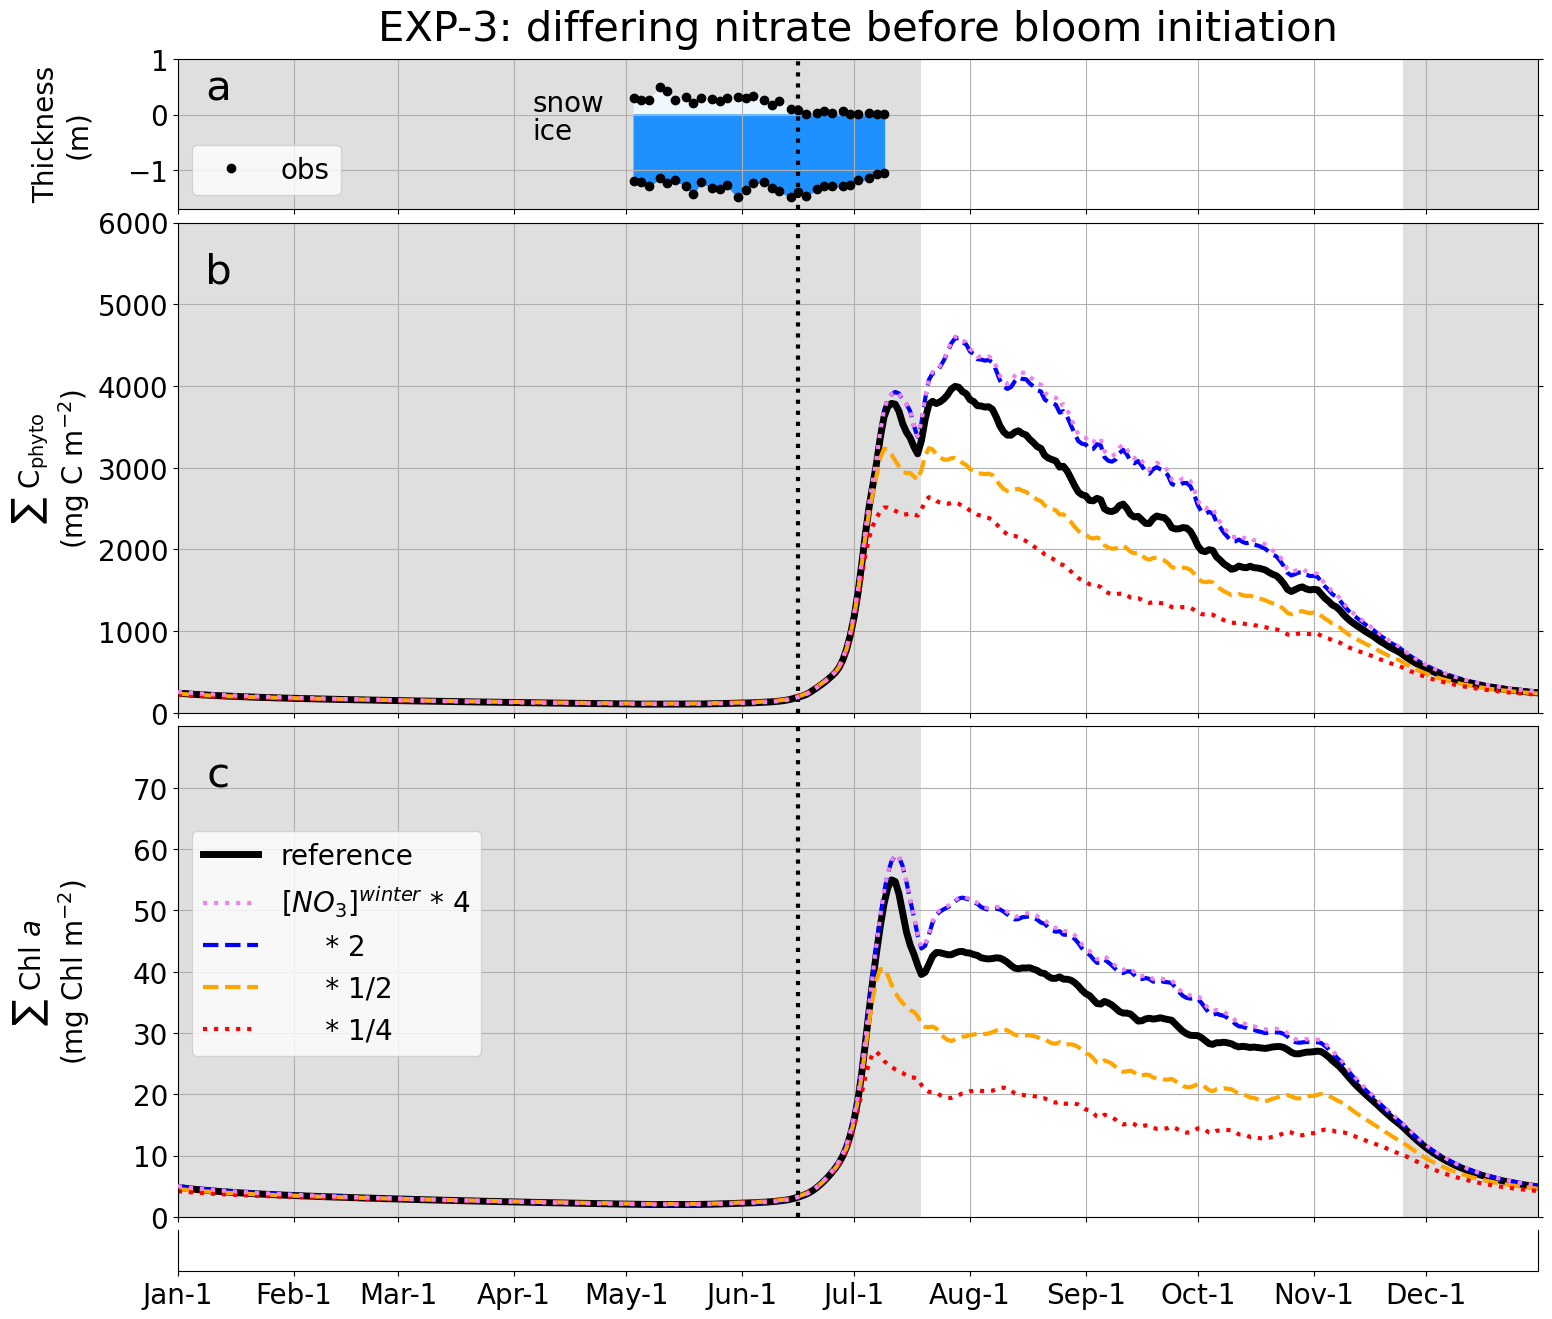

In [144]:
def make_plots(axs):
    box=dict(pad=5,alpha=0)
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    xlims=(first_year[0],first_year[-1])
    xmin=xlims[0]
    xmax=xlims[1]

    # --- SNOW AND ICE THICKNESS
    ax=axs[0]
    ymin=-1.7
    ymax=1.0
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    xsnow=(snow_thickness_df['doy']-1).to_numpy()
    ysnow=snow_thickness_df['sample_thickness_m_average'].to_numpy()
    h1=ax.plot(xsnow,ysnow,
               'o',color='black',markersize=6,label='obs')
    xsnow_to_fill=np.arange(xsnow[0],xsnow[-1]+1)
    ysnow_to_fill=np.interp(xsnow_to_fill,xsnow,ysnow)
    h2=ax.fill_between(xsnow_to_fill,ysnow_to_fill,
                       linestyle='-',color='aliceblue')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Thickness\n(m)',bbox=box)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(ymin,ymax)
    ax.grid()
    ax.text(95,0.2,'snow',
            horizontalalignment = 'left',verticalalignment = 'center',
            fontsize=20)
    xice=(ice_thickness_df['doy']-1).to_numpy()
    yice=-ice_thickness_df['sample_thickness_m_average'].to_numpy()
    h3=ax.plot(xice,yice,'o',color='black',markersize=6)
    xice_to_fill=np.arange(xice[0],xice[-1]+1)
    yice_to_fill=np.interp(xice_to_fill,xice,yice)
    h4=ax.fill_between(xice_to_fill,yice_to_fill,
                       linestyle='-',color='dodgerblue')
    ax.text(95,-0.30,'ice',
            horizontalalignment = 'left',verticalalignment = 'center',
            fontsize=20)
    ax.legend(loc='lower left')
    plt.text(0.03,0.80,' a ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    plt.text(0.5,1.2,'EXP-3: differing nitrate before bloom initiation',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
#     ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    
    # --- EXP-1.3: SUM C PHYTO
    ax=axs[1]
    h_off_model=ax.plot(0,1,
                  '-',color='black',alpha=0,label='model')
    h_EXP1_3_no3_times_4_00=ax.plot(
        first_year,
        array1d_iT_modvintcphyto_EXP1_3_no3_times_4_00,
        ':',color='violet',zorder=20)
    h_EXP1_3_no3_times_2_00=ax.plot(
        first_year,
        array1d_iT_modvintcphyto_EXP1_3_no3_times_2_00,
        '--',color='blue')
    h_EXP1_3_no3_times_1_00_default=ax.plot(
        first_year,
        array1d_iT_modvintcphyto_EXP1_3_no3_times_1_00_default,
        '-',color='black',linewidth=5)
    h_EXP1_3_no3_times_0_50=ax.plot(
        first_year,
        array1d_iT_modvintcphyto_EXP1_3_no3_times_0_50,
        '--',color='orange')
    h_EXP1_3_no3_times_0_25=ax.plot(
        first_year,
        array1d_iT_modvintcphyto_EXP1_3_no3_times_0_25,
        ':',color='red')

    # log
    # ax.set_yscale('log')
    # ymin=70
    # ymax=7000
    # linear
    ymin=0
    ymax=6000
    
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('$\mathrm{ \sum\ C_{phyto} }$\n'
                  '($\mathrm{ mg\ C\ m^{-2} }$)')
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(ymin,ymax)
    ax.grid()
    plt.text(0.03,0.90,' b ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
#     ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    
    # --- EXP-1.3: SUM CHL A
    ax=axs[2]
    h_EXP1_3_no3_times_1_00_default=ax.plot(
        first_year,
        array1d_iT_modvintchl_EXP1_3_no3_times_1_00_default,
        '-',color='black',linewidth=5,
        label='reference')
    h_EXP1_3_no3_times_4_00=ax.plot(
        first_year,
        array1d_iT_modvintchl_EXP1_3_no3_times_4_00,
        ':',color='violet',zorder=10,
        label='${[NO_3]}^{winter}$ * 4')
    h_EXP1_3_no3_times_2_00=ax.plot(
        first_year,
        array1d_iT_modvintchl_EXP1_3_no3_times_2_00,
        '--',color='blue',
        label='     * 2')
    h_EXP1_3_no3_times_0_50=ax.plot(
        first_year,
        array1d_iT_modvintchl_EXP1_3_no3_times_0_50,
        '--',color='orange',
        label='     * 1/2')
    h_EXP1_3_no3_times_0_25=ax.plot(
        first_year,
        array1d_iT_modvintchl_EXP1_3_no3_times_0_25,
        ':',color='red',
        label='     * 1/4')
#     h_obs=ax.plot(
#         first_year,
#         array1d_iT_obsvintchlHPLC,
#         'o',color='black',zorder=10,label='obs')

    # log
    # ax.set_yscale('log')
    # ymin=1
    # ymax=100
    # ax.legend(loc='lower left',bbox_to_anchor=(0.00,0.35))
    # linear
    ymin=0
    ymax=80
    ax.set_yticks(range(0,80,10))
    ax.legend(loc='lower left',bbox_to_anchor=(0.00,0.30))

    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('$\mathrm{ \sum\ Chl\ }a$\n'
                  '($\mathrm{ mg\ Chl\ m^{-2} }$)')
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(ymin,ymax)
    ax.grid()
    plt.text(0.03,0.90,' c ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
#     ax.axvline(first_obs_PAR,color='black',linewidth=1,linestyle=':')
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    
    # --- ADDITIONAL X-AXIS
    ax=axs[3]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)

    # --- POSITION
    axs[0].set_position( [0.13,0.82 ,0.85,0.11])
    axs[1].set_position( [0.13,0.45 ,0.85,0.36])
    axs[2].set_position( [0.13,0.08 ,0.85,0.36])
    axs[3].set_position( [0.13,0.04 ,0.85,0.03])

with plt.style.context('mplstyles/exp1.mplstyle'):
    # Plot
    fig,axs=plt.subplots(4,1,figsize=(16,13.62))
    make_plots(axs)
    fig.align_ylabels(axs[:])

    # --- SAVE
    outfile='figures_timing_progress/exp3_total.'+ext
    plt.savefig(outfile,dpi=dpi)

Fig \<exp3_total\>.
Sensitivity simulations: EXP-3 prescribed nitrate concentrations
before the bloom initiation
at 4, 2, 1/2 and 1/4 times that in the default simulation
(solid black line).
This solid black line is the same output as shown in
Fig. \<validation\>d and e for the original ("reference") simulation.
(a) Observed snow and ice thickness.
(b) Vertically integrated biomass of phytoplankton (0-100m). Only model biomass is shown.
(c) Vertically integrated Chl a (0-100m). Dots are in situ Chl a. The lines are the model Chl a.
The vertical black dotted line is the date of
the snow melt completion.
The grey rectangles represent the time of year before the sea ice break-up and after the sea ice freeze-up.